In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import selfies as sf
import exmol
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor

rdDepictor.SetPreferCoordGen(True)
sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
        "figure.dpi": 300,
    },
)
color_cycle = ["#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
np.random.seed(0)

2021-11-15 11:39:50.557399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from tensorflow.python.client import device_lib
print("TF Version: ",tf.__version__)
print("List of local devices:", device_lib.list_local_devices())
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("List GPUs:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 
print("GPU Device Name:", tf.test.gpu_device_name())

TF Version:  2.4.0
List of local devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13629831023457132175
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1098252288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9964607472893936639
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 750 Ti, pci bus id: 0000:01:00.0, compute capability: 5.0"
]
Built with CUDA: True
List GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPU Device Name: /device:GPU:0


2021-11-15 11:39:58.955613: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-15 11:39:59.026650: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-15 11:39:59.187524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 11:39:59.187857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 750 Ti computeCapability: 5.0
coreClock: 1.15GHz coreCount: 5 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 80.47GiB/s
2021-11-15 11:39:59.187879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-15 11:39:59.322965: I tensorflow/stream_executor/platform/def

In [3]:
# scramble them
# Reduced for CI!
#soldata = soldata.sample(frac=1, random_state=1).reset_index(drop=True)
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [4]:
selfies_list = [sf.encoder(exmol.sanitize_smiles(s)[1]) for s in soldata.SMILES]

In [5]:
len(selfies_list)

9982

In [6]:
basic = set(exmol.get_basic_alphabet())
data_vocab = set(sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None]))
vocab = ['[nop]']
vocab.extend(sorted(list(data_vocab.union(basic))))
vocab_stoi = {o:i for o,i in zip(vocab, range(len(vocab)))}
#vocab_stoi['[nop]'] = 0 

def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue #?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            #print('Warning')
    return result

def ints2selfies(v):
    return ''.join([vocab[i] for i in v])

# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s.replace('.','') #make sure '.' is removed from Selfies string during assertion

selfies: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][N+expl][Branch1_1][C][C][Branch1_1][C][C][C].[Br-expl]
selfies2ints: [78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 141, 66, 78, 78, 66, 78, 78, 78, 64]
ints2selfes: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][N+expl][Branch1_1][C][C][Branch1_1][C][C][C][Br-expl]


In [7]:
print(vocab)
print()
print(vocab_stoi)
print()

['[nop]', '[#C]', '[#N+expl]', '[#N]', '[#O+expl]', '[#S]', '[=Asexpl]', '[=B]', '[=C-expl]', '[=C]', '[=Caexpl]', '[=Cdexpl]', '[=Ceexpl]', '[=Coexpl]', '[=Crexpl]', '[=Cuexpl]', '[=Feexpl]', '[=I]', '[=Mnexpl]', '[=Moexpl]', '[=N+expl]', '[=N-expl]', '[=NH+expl]', '[=N]', '[=Nbexpl]', '[=Niexpl]', '[=O+expl]', '[=O]', '[=P+expl]', '[=PHexpl]', '[=P]', '[=Pbexpl]', '[=S+expl]', '[=S]', '[=Seexpl]', '[=Siexpl]', '[=SnH2expl]', '[=Snexpl]', '[=Srexpl]', '[=Teexpl]', '[=Tiexpl]', '[=V+2expl]', '[=Vexpl]', '[=Wexpl]', '[=Yexpl]', '[=Znexpl]', '[=Zrexpl]', '[Ag+expl]', '[Agexpl]', '[Al+3expl]', '[Alexpl]', '[As+3expl]', '[Asexpl]', '[Au+3expl]', '[Au+expl]', '[Auexpl]', '[B+3expl]', '[B-expl]', '[B]', '[Ba+2expl]', '[Beexpl]', '[Bexpl]', '[Bi+3expl]', '[Biexpl]', '[Br-expl]', '[Br]', '[Branch1_1]', '[Branch1_2]', '[Branch1_3]', '[Branch2_1]', '[Branch2_2]', '[Branch2_3]', '[Branch3_1]', '[Branch3_2]', '[Branch3_3]', '[C+expl]', '[C-expl]', '[CH-expl]', '[C]', '[Ca+2expl]', '[CaH2expl]', '[

In [8]:
vocab_stoi['[nop]']

0

In [9]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int


config = Config(
    vocab_size=len(vocab),
    example_number=len(selfies_list),
    batch_size=16,
    buffer_size=10000,
    embedding_dim=256,
    hidden_dim=128,
    rnn_units=128,
)

In [10]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")
print("pad seqs shape: ",padded_seqs.shape)


# Now build dataset
data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values)
).shuffle(len(padded_seqs))
# now split into val, test, train and batch
N = len(data)
print("N: ", N)
split = int(0.1 * N)
print("split: ", split)
test_data = data.take(split).batch(config.batch_size)
print("len test_data: ", len(test_data))
nontest = data.skip(split)
print("len nontest: ", len(nontest))
val_data, train_data = nontest.take(split).batch(config.batch_size), nontest.skip(
    split
).shuffle(config.buffer_size).batch(config.batch_size).prefetch(
    tf.data.experimental.AUTOTUNE
)

print("len val_data: ",len(val_data))
print("len train_data: ",len(train_data))
print("these lengths show number of batches in the data")

pad seqs shape:  (9982, 615)
N:  9982
split:  998
len test_data:  63
len nontest:  8984
len val_data:  63
len train_data:  500
these lengths show number of batches in the data


2021-11-15 11:40:06.995713: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-15 11:40:06.995949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 11:40:06.996151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 750 Ti computeCapability: 5.0
coreClock: 1.15GHz coreCount: 5 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 80.47GiB/s
2021-11-15 11:40:06.996193: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-15 11:40:06.996235: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-15 11:40:06.996258: I tensorflow/stream_executor/platform/

In [11]:
config.batch_size*500

8000

In [12]:
print(split)

998


In [13]:
print(selfies_list[5])
print(selfies2ints(selfies_list[5]))
print(vocab_stoi['[nop]'])
print(padded_seqs[5])

[C][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]
[78, 9, 78, 9, 78, 9, 78, 66, 78, 78, 9, 178, 68]
0
[ 78   9  78   9  78   9  78  66  78  78   9 178  68   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0

In [14]:
'''
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(
    tf.keras.layers.Embedding(
        input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True
    )
)

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation="relu"))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()
'''

'\nmodel = tf.keras.Sequential()\n\n# make embedding and indicate that 0 should be treated as padding mask\nmodel.add(\n    tf.keras.layers.Embedding(\n        input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True\n    )\n)\n\n# RNN layer\nmodel.add(tf.keras.layers.GRU(config.rnn_units))\n# a dense hidden layer\nmodel.add(tf.keras.layers.Dense(config.hidden_dim, activation="relu"))\n# regression, so no activation\nmodel.add(tf.keras.layers.Dense(1))\n\nmodel.summary()\n'

In [15]:
'''
model.compile(tf.optimizers.Adam(1e-4), loss="mean_squared_error")
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=2)
model.save("models/RNN-model")
'''

'\nmodel.compile(tf.optimizers.Adam(1e-4), loss="mean_squared_error")\nresult = model.fit(train_data, validation_data=val_data, epochs=100, verbose=2)\nmodel.save("models/RNN-model")\n'

In [16]:
'''
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
'''

"\nplt.plot(result.history['loss'], label='training')\nplt.plot(result.history['val_loss'], label='validation')\nplt.legend()\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.show()\n"

In [17]:
model = tf.keras.models.load_model("models/RNN-model")

2021-11-15 11:40:09.759211: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-11-15 11:40:09.816166: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-11-15 11:40:10.178384: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-11-15 11:40:10.188385: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-11-15 11:40:10.299709: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond' has 4 outputs but the _output_sh

2021-11-15 11:40:12.439411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-11-15 11:40:24.515776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-15 11:40:26.520616: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


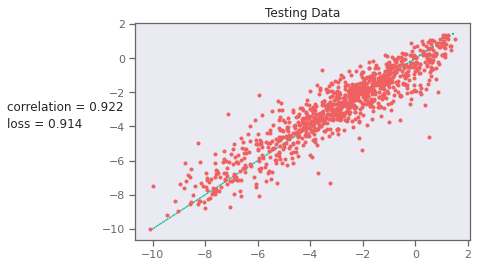

In [18]:
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(min(y) - 7, max(y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(y) - 7, max(y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.savefig('rnn-fit.png', dpi=300)
plt.show()


In [19]:
instance_ints = selfies2ints(selfies_list[2164])
print(instance_ints," ",model.predict([instance_ints]).flatten())
mod_instance_ints = instance_ints[:]
print(mod_instance_ints," ",model.predict([mod_instance_ints]).flatten())
for i in range(len(instance_ints)):
    mod_instance_ints.insert(i*2,0)
    print(mod_instance_ints," ",model.predict([mod_instance_ints]).flatten())
mod_instance_ints.extend([0]*10)
print(mod_instance_ints," ",model.predict([mod_instance_ints]).flatten())

2021-11-15 11:40:27.682334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-15 11:40:27.761663: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3997945000 Hz


[162, 58, 66, 78, 162, 162]   [-0.72970206]
[162, 58, 66, 78, 162, 162]   [-0.72970206]
[0, 162, 58, 66, 78, 162, 162]   [-0.72970206]
[0, 162, 0, 58, 66, 78, 162, 162]   [-0.72970206]
[0, 162, 0, 58, 0, 66, 78, 162, 162]   [-0.72970206]
[0, 162, 0, 58, 0, 66, 0, 78, 162, 162]   [-0.72970206]
[0, 162, 0, 58, 0, 66, 0, 78, 0, 162, 162]   [-0.72970206]
[0, 162, 0, 58, 0, 66, 0, 78, 0, 162, 0, 162]   [-0.72970206]
[0, 162, 0, 58, 0, 66, 0, 78, 0, 162, 0, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   [-0.72970206]


## Generate Samples from Distributions

In [20]:
import itertools
import copy

In [21]:
max_len = 3

In [22]:
def nwise(iterable, n=1):
    iterators = itertools.tee(iterable, n)
    for i in range(n):
        for _ in range(i):
            next(iterators[i], None)
    return zip(*iterators)

In [23]:
def make_combs(max_len):
    
    vocab_comb = []
    vocab_stoi_comb = []
    symbol_counts_comb = []
    
    for n in range(1,max_len+1):
        #print(n)
        # remove n==1 part. only keep else
        if n==1:
            symbol_counts_n = {tok:0 for tok in list(exmol.get_basic_alphabet())}
        else:
            symbol_counts_n = {} 
        #symbol_counts_n = {} 
        for s in selfies_list:
            s_list = list(sf.split_selfies(s))    
            s_list_n = [''.join(s) for s in list(nwise(s_list,n))]
            #s_list_n += [''.join(list(s)[::-1]) for s in list(nwise(s_list,N))] <--- Account for token pairs in reverse ?
            for token in s_list_n:
                    if '.' in token:
                        continue #?
                    if token in symbol_counts_n:
                        symbol_counts_n[token] += 1
                    else:
                        symbol_counts_n[token] = 1
        
        symbol_counts_n = dict(sorted(symbol_counts_n.items(), key=lambda i: i[0]))
        #print(symbol_counts_n)
        #print()
        vocab_n = list(symbol_counts_n.keys())
        vocab_stoi_n = {o:i for o,i in zip(vocab_n, range(len(vocab_n)))}
        #print(vocab_n)
        #print(vocab_stoi_n)
        #print()
        
        vocab_comb.append(vocab_n)
        vocab_stoi_comb.append(vocab_stoi_n)
        symbol_counts_comb.append(symbol_counts_n)
        
    return vocab_comb, vocab_stoi_comb, symbol_counts_comb

vocab_comb, vocab_stoi_comb, symbol_counts_comb = make_combs(max_len)

In [24]:
symbol_counts_comb[0]

{'[#C]': 904,
 '[#N+expl]': 2,
 '[#N]': 217,
 '[#O+expl]': 10,
 '[#S]': 0,
 '[=Asexpl]': 1,
 '[=B]': 2,
 '[=C-expl]': 2,
 '[=C]': 31027,
 '[=Caexpl]': 1,
 '[=Cdexpl]': 2,
 '[=Ceexpl]': 1,
 '[=Coexpl]': 2,
 '[=Crexpl]': 3,
 '[=Cuexpl]': 1,
 '[=Feexpl]': 2,
 '[=I]': 1,
 '[=Mnexpl]': 3,
 '[=Moexpl]': 8,
 '[=N+expl]': 198,
 '[=N-expl]': 8,
 '[=NH+expl]': 4,
 '[=N]': 3142,
 '[=Nbexpl]': 1,
 '[=Niexpl]': 2,
 '[=O+expl]': 5,
 '[=O]': 11534,
 '[=P+expl]': 1,
 '[=PHexpl]': 6,
 '[=P]': 97,
 '[=Pbexpl]': 5,
 '[=S+expl]': 1,
 '[=S]': 440,
 '[=Seexpl]': 3,
 '[=Siexpl]': 19,
 '[=SnH2expl]': 1,
 '[=Snexpl]': 2,
 '[=Srexpl]': 1,
 '[=Teexpl]': 2,
 '[=Tiexpl]': 3,
 '[=V+2expl]': 1,
 '[=Vexpl]': 4,
 '[=Wexpl]': 14,
 '[=Yexpl]': 1,
 '[=Znexpl]': 2,
 '[=Zrexpl]': 2,
 '[Ag+expl]': 5,
 '[Agexpl]': 1,
 '[Al+3expl]': 36,
 '[Alexpl]': 1,
 '[As+3expl]': 2,
 '[Asexpl]': 6,
 '[Au+3expl]': 1,
 '[Au+expl]': 1,
 '[Auexpl]': 1,
 '[B+3expl]': 1,
 '[B-expl]': 5,
 '[B]': 30,
 '[Ba+2expl]': 18,
 '[Beexpl]': 2,
 '[Bexpl]':

In [25]:
list(symbol_counts_comb[0].keys()).index('[C]')

77

In [26]:
# the difference between the index from the original and current vocab is 1.
# this is because the original vocab has '[Nop]' as the 0th token
print(len(vocab))
print(len(vocab_comb[0]))
print()
for i in range(len(vocab_comb[0])):
    #print(i)
    assert vocab_comb[0][i]==vocab[i+1]
        #print("i: ",i," ",vocab_comb[i]," ",vocab_comb[i+1])

213
212



In [27]:
print(len(vocab_stoi))
print(len(vocab_stoi_comb[0]))
print(vocab_stoi['[nop]'])
print('[nop]' not in vocab_stoi_comb[0].keys()) # should be True because we dont want to sample '[nop]' tokens

213
212
0
True


In [28]:
def get_uni_dist(vocab_comb):
    uni_dist = []
    for vocab in vocab_comb:
        prob_vec = np.ones(len(vocab))/len(vocab)
        uni_dist.append(prob_vec)
    return uni_dist

uni_dist = get_uni_dist(vocab_comb)
print(uni_dist)

[array([0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.00471698,
       0.00471698, 0.00471698, 0.00471698, 0.00471698, 0.0047

In [29]:
len(uni_dist[0])

212

In [30]:
# Find all multi-tokens which start with a particular token
def make_branch(s):
    #print()
    s_list = list(sf.split_selfies(s))
    s_len = len(s_list)
    #print(s," ",s_len)

    child_tokens = [child for child in vocab_comb[s_len] if child.startswith(s)]
    #print("child_tokens: ",child_tokens)
    
    if len(child_tokens)!=0:
        # ints as n-grams
        child_ints_n = [vocab_stoi_comb[s_len][child] for child in child_tokens]
        #print("child_ints_n: ",child_ints_n)
        # ints as 1-grams
        child_ints_1 = [[vocab_stoi_comb[0][tok] for tok in sf.split_selfies(child)] for child in child_tokens]
        #print("child_ints_1: ",child_ints_1)
        child_counts = [symbol_counts_comb[s_len][child] for child in child_tokens]
        #print("child_counts: ",child_counts)
        child_prob = child_counts/np.sum(child_counts)
        #if child_counts==[2,1]: print(child_prob)
        #print("child_prob: ",child_prob)
        #print("s_len: ", s_len,", max_len: ", max_len," max_len - s_len: ",max_len - s_len," bool: ",max_len -s_len > 1)
        if max_len - s_len > 1:
            #print("going deeper")
            child_child = [make_branch(child) for child in child_tokens]
            #print("coming up")
            #print("child_child: ",child_child)
            out = [list(a) for a in zip(child_ints_n, child_ints_1, child_counts, child_prob, child_child)]
        else:
            #print("max depth reached")
            out = [list(a) for a in zip(child_ints_n, child_ints_1, child_counts, child_prob)]
    else: 
        #print("no children")
        out = []
    #print("out: ",out)
    #print()
    return out

#make_branch('[#C]')
tree = [make_branch('')]

In [31]:
# tree[0] = all info for all unique 1-gram tokens
[[i[0],i[3]] for i in tree[0]] # get prob dist of all 1-gram tokens

[[0, 0.003318856169437887],
 [1, 7.3426021447740864e-06],
 [2, 0.0007966723327079883],
 [3, 3.671301072387043e-05],
 [4, 0.0],
 [5, 3.6713010723870432e-06],
 [6, 7.3426021447740864e-06],
 [7, 7.3426021447740864e-06],
 [8, 0.11390945837295278],
 [9, 3.6713010723870432e-06],
 [10, 7.3426021447740864e-06],
 [11, 3.6713010723870432e-06],
 [12, 7.3426021447740864e-06],
 [13, 1.101390321716113e-05],
 [14, 3.6713010723870432e-06],
 [15, 7.3426021447740864e-06],
 [16, 3.6713010723870432e-06],
 [17, 1.101390321716113e-05],
 [18, 2.9370408579096346e-05],
 [19, 0.0007269176123326346],
 [20, 2.9370408579096346e-05],
 [21, 1.4685204289548173e-05],
 [22, 0.01153522796944009],
 [23, 3.6713010723870432e-06],
 [24, 7.3426021447740864e-06],
 [25, 1.8356505361935216e-05],
 [26, 0.042344786568912156],
 [27, 3.6713010723870432e-06],
 [28, 2.202780643432226e-05],
 [29, 0.0003561162040215432],
 [30, 1.8356505361935216e-05],
 [31, 3.6713010723870432e-06],
 [32, 0.001615372471850299],
 [33, 1.101390321716113e-

In [32]:
# tree[0][0] = all info for unique 2-grams starting with '[C]'
# tree[0][3] = get children of tree[0][0]
[i[3] for i in tree[0][0][4]] # prob dist of children of tree[0][0]

[0.037089871611982884,
 0.037089871611982884,
 0.037089871611982884,
 0.0014265335235378032,
 0.007132667617689016,
 0.0028530670470756064,
 0.5349500713266762,
 0.037089871611982884,
 0.0028530670470756064,
 0.0014265335235378032,
 0.007132667617689016,
 0.0042796005706134095,
 0.1369472182596291,
 0.0028530670470756064,
 0.06134094151212553,
 0.034236804564907276,
 0.029957203994293864,
 0.005706134094151213,
 0.018544935805991442]

In [33]:
# this function generates a random token using the indices from vocab_comb NOT vocab
def make_rand_token_combint(ints, n, dist_type, debug=False): # n = n-gram
    # get a random token which starts with ints
    ints_len = len(ints)
    if debug: print(ints_len)
    #comb_token = ''
    comb_ints_n = ''
    comb_ints_1 = ''
    branch = copy.deepcopy(tree[0])
    if debug: print()
    for i in range(n):
        if debug: print("position: ",i)
        
        if len(branch)==0:
            if debug: print("branch ends. generate random token")
            req_len = n - i
            if debug: print(req_len)
            rand_ints_1 = make_rand_token_combint([],req_len, dist_type, debug)
            #rand_ints_1 = make_random_token([],req_len, debug)
            if debug: print("Back Here")
            if debug: print(rand_ints_1)
            #if debug: print(rand_token,' ',rand_ints_1)
            #comb_token += rand_token
            comb_ints_1.extend(rand_ints_1)
            break
            
        if i < ints_len:
            if debug: print("take from input")
            ints_i = ints[:i+1]
            if debug: print(ints_i)
            l_ints_1 = [k[1] for k in branch]
            if ints_i in l_ints_1:
                comb_ints_n = branch[l_ints_1.index(ints_i)][0]
            else:
                if debug: print("prior ints not in branch!")
                return
            if debug: print(comb_ints_n)
            pos_i = [k[0] for k in branch].index(comb_ints_n)
            if debug: print(pos_i)
        else:
            if debug: print("generate random")
            if dist_type == 'freq':
                prob_i = [k[3] for k in branch]
            elif dist_type == 'uni':
                prob_i = np.ones(len(branch))/len(branch)
            if debug: print(prob_i)
            pos_i = np.argmax(np.random.multinomial(1, prob_i, size=1),axis=-1)[0]
            if debug: print(pos_i)
            comb_ints_n = branch[pos_i][0]
            if debug: print(comb_ints_n)
        comb_ints_1 = branch[pos_i][1]
        if debug: print(comb_ints_1)
        #comb_token = vocab_comb[i][comb_ints_n]
        #if debug: print(comb_token)
        #if debug: print(comb_token," ",comb_ints_n," ",comb_ints_1)
        
        if len(comb_ints_1) == max_len:
            if debug: print("max depth reached")
            break
        else: 
            if debug: print("updating branch")
            branch = branch[pos_i][4]
        
        if debug: print()
    
    return comb_ints_1


def make_rand_token(ints, n, dist_type, debug=False): # n = n-gram
    comb_ints_1 = make_rand_token_combint(ints, n, dist_type, debug)
    comb_ints_1 = np.array(comb_ints_1) + 1
    return ints2selfies(comb_ints_1), comb_ints_1


np.random.seed(10)
print(make_rand_token('', 3, 'freq'))
np.random.seed(10)
print(make_rand_token('', 3, 'uni'))

('[C][=C][C]', array([78,  9, 78]))
('[Zr+4expl][Hf+4expl][Zr+4expl]', array([211, 117, 211]))


In [34]:
import time

In [35]:
np.random.seed(1000)
start = time.time()
[make_rand_token('',1, 'freq') for k in range(1000)]
end = time.time()
print(end - start)

20.5709867477417


In [36]:
np.random.seed(1000)
start = time.time()
[make_rand_token('',1, 'uni') for k in range(1000)]
end = time.time()
print(end - start)

20.695364475250244


In [37]:
np.random.seed(1000)
start = time.time()
[make_rand_token('',2,'freq') for k in range(1000)]
end = time.time()
print(end - start)

20.70483112335205


In [38]:
np.random.seed(1000)
start = time.time()
[make_rand_token('',2,'uni') for k in range(1000)]
end = time.time()
print(end - start)

30.661548137664795


In [39]:
np.random.seed(1000)
start = time.time()
[make_rand_token('',3,'freq') for k in range(1000)]
end = time.time()
print(end - start)

20.57202696800232


In [40]:
np.random.seed(1000)
start = time.time()
[make_rand_token('',3,'uni') for k in range(1000)]
end = time.time()
print(end - start)

38.97574734687805


In [41]:
np.random.seed(1000)
[make_rand_token('',1,'freq') for k in range(10)]

[('[C]', array([78])),
 ('[C]', array([78])),
 ('[=C]', array([9])),
 ('[C]', array([78])),
 ('[=O]', array([27])),
 ('[=C]', array([9])),
 ('[=C]', array([9])),
 ('[C]', array([78])),
 ('[=C]', array([9])),
 ('[C]', array([78]))]

In [42]:
np.random.seed(1000)
[make_rand_token('',2,'freq') for k in range(10)]

[('[C][=C]', array([78,  9])),
 ('[C][=C]', array([78,  9])),
 ('[C][N]', array([ 78, 149])),
 ('[N][Branch1_1]', array([149,  66])),
 ('[O][Coexpl]', array([162,  92])),
 ('[C][C]', array([78, 78])),
 ('[C][C]', array([78, 78])),
 ('[C][C]', array([78, 78])),
 ('[=O][C]', array([27, 78])),
 ('[C][Branch1_1]', array([78, 66]))]

In [43]:
np.random.seed(1000)
[make_rand_token('',3,'freq') for k in range(10)]

[('[C][=C][Branch1_1]', array([78,  9, 66])),
 ('[K+expl][C][Ring1]', array([126,  78, 178])),
 ('[Ring1][Branch1_2][N]', array([178,  67, 149])),
 ('[Branch1_1][C][N]', array([ 66,  78, 149])),
 ('[Branch2_1][N][=N]', array([ 69, 149,  23])),
 ('[O][C][Ring1]', array([162,  78, 178])),
 ('[C][Branch1_1][C]', array([78, 66, 78])),
 ('[=C][C][=C]', array([ 9, 78,  9])),
 ('[C][O][C]', array([ 78, 162,  78])),
 ('[Cl][=C][Branch1_1]', array([88,  9, 66]))]

In [44]:
# Make a random sequence
def make_rand_seq(seq_len, n, dist_type='freq', debug=False): 
    # seq_len = 1-gram sequence length; 
    #n = n-gram; 
    #dist_type = type of distribution 'freq' or 'uni'
    
    if n == 1:
        if dist_type == 'freq':
            prob_dist = [i[3] for i in tree[0]] 
        elif dist_type == 'uni':
            prob_dist = uni_dist[0]
        ints = list(np.argmax(np.random.multinomial(1, prob_dist, size=seq_len),axis=-1))
        ints = list(np.array(ints) + 1)
        seq = ints2selfies(ints)
        
    else:
        num_n = seq_len//n
        n_tail = seq_len%n
        if debug: print("num_n: ",num_n)
        if debug: print("n_tail: ",n_tail)
            
        seq = ''
        ints = []

        if dist_type == 'freq':
            
            rand_out = [make_rand_token('',n,'freq') for k in range(num_n)]
            seq = ''.join([k[0] for k in rand_out])
            ints = [k[1] for k in rand_out]
            if debug: print(seq," ",ints)

            if n_tail != 0:
                tail_tok, tail_ints = make_rand_token('',n_tail,'freq')
                if debug: print(tail_tok," ",tail_ints)
                seq+=tail_tok
                ints.append(tail_ints)

            ints = list(itertools.chain(*ints))
            
        elif dist_type == 'uni':
            
            prob_dist = uni_dist[n-1]
            n_ints = list(np.argmax(np.random.multinomial(1, prob_dist, size=num_n),axis=-1))
            seq = ''.join([vocab_comb[n-1][k] for k in n_ints])
            ints = selfies2ints(seq)
            if debug: print(seq," ",ints)
            
            if n_tail != 0:
                
                prob_dist = uni_dist[n_tail-1]
                n_tail_ints = list(np.argmax(np.random.multinomial(1, prob_dist, size=1),axis=-1))
                tail_tok = ''.join([vocab_comb[n_tail-1][k] for k in n_tail_ints])
                tail_ints = selfies2ints(tail_tok)
                if debug: print(tail_tok," ",tail_ints)
                seq+=tail_tok
                ints.extend(tail_ints)
            
            
        assert len(ints) == seq_len
    
    return seq, ints

np.random.seed(8)
print(make_rand_seq(10,1,'freq'))
np.random.seed(8)
print(make_rand_seq(10,1,'uni'))
print()
np.random.seed(8)
print(make_rand_seq(10,2,'freq'))
np.random.seed(8)
print(make_rand_seq(10,2,'uni'))
print()
np.random.seed(8)
print(make_rand_seq(10,3,'freq'))
np.random.seed(8)
print(make_rand_seq(10,3,'uni'))
print()

('[F][Ring1][Ring1][C][Cl][C][Br][N][Ring1][C]', [106, 178, 178, 78, 88, 78, 65, 149, 178, 78])
('[Expl=Ring1][PHexpl][NH4+expl][Clexpl][=B][Branch1_3][NH4+expl][=N-expl][Dyexpl][=Yexpl]', [102, 166, 147, 89, 7, 68, 147, 21, 101, 44])

('[F][=C][C][Branch1_2][C][C][Ring1][C][Ring1][O]', [106, 9, 78, 67, 78, 78, 178, 78, 178, 162])
('[N][N][Branch1_3][Branch2_3][O][=Mnexpl][C][NH3+expl][Niexpl][Niexpl]', [149, 149, 68, 71, 162, 18, 78, 146, 157, 157])

('[F][=C][C][Branch1_1][S][O][Branch1_1][C][C][=C]', [106, 9, 78, 66, 187, 162, 66, 78, 78, 9])
('[Branch1_2][C][O][N][=O][=N][Ring2][Branch1_1][Branch1_1][=Siexpl]', [67, 78, 162, 149, 27, 23, 179, 66, 66, 35])



In [45]:
np.random.seed(1000)
start = time.time()
[make_rand_seq(10,1,'freq') for k in range(100)]
end = time.time()
print(end - start)

0.010176658630371094


In [46]:
np.random.seed(1000)
start = time.time()
[make_rand_seq(10,1,'uni') for k in range(100)]
end = time.time()
print(end - start)

0.0060367584228515625


In [47]:
np.random.seed(1000)
start = time.time()
[make_rand_seq(10,2,'freq') for k in range(100)]
end = time.time()
print(end - start)

10.348304510116577


In [48]:
np.random.seed(1000)
start = time.time()
[make_rand_seq(10,2,'uni') for k in range(100)]
end = time.time()
print(end - start)

0.010641336441040039


In [49]:
np.random.seed(1000)
start = time.time()
[make_rand_seq(10,3,'freq') for k in range(100)]
end = time.time()
print(end - start)

8.019379615783691


In [50]:
np.random.seed(1000)
start = time.time()
[make_rand_seq(10,3,'uni') for k in range(100)]
end = time.time()
print(end - start)

0.02670001983642578


In [51]:
make_rand_seq(1,3,'freq', True)

num_n:  0
n_tail:  1
   []
[C]   [78]


('[C]', [78])

In [52]:
make_rand_seq(1,3,'uni', True)

num_n:  0
n_tail:  1
   []
[=S]   [33]


('[=S]', [33])

In [53]:
vocab_stoi_comb[1].keys()

dict_keys(['[#C][=C]', '[#C][=N]', '[#C][=O]', '[#C][Br]', '[#C][Branch1_1]', '[#C][Branch2_1]', '[#C][C]', '[#C][Cl]', '[#C][Expl=Ring1]', '[#C][F]', '[#C][I]', '[#C][N+expl]', '[#C][N]', '[#C][O-expl]', '[#C][O]', '[#C][Ring1]', '[#C][Ring2]', '[#C][S-expl]', '[#C][S]', '[#N+expl][C]', '[#N][=C]', '[#N][=N]', '[#N][Branch1_1]', '[#N][C]', '[#N][N]', '[#N][O]', '[#N][S]', '[=Asexpl][Branch1_1]', '[=B][O]', '[=C-expl][C]', '[=C][=C]', '[=C][=N]', '[=C][=O]', '[=C][=S]', '[=C][Asexpl]', '[=C][Br]', '[=C][Branch1_1]', '[=C][Branch2_1]', '[=C][CH-expl]', '[=C][C]', '[=C][Cl]', '[=C][Expl=Ring1]', '[=C][F]', '[=C][Hgexpl]', '[=C][I]', '[=C][N+expl]', '[=C][N-expl]', '[=C][NH+2expl]', '[=C][NH+expl]', '[=C][NHexpl]', '[=C][N]', '[=C][O-expl]', '[=C][O]', '[=C][P]', '[=C][Ring1]', '[=C][Ring2]', '[=C][S]', '[=C][Siexpl]', '[=Ceexpl][=O]', '[=Coexpl][O]', '[=Crexpl][Branch1_2]', '[=Crexpl][O]', '[=Feexpl][O]', '[=I][Branch1_2]', '[=Mnexpl][=O]', '[=Mnexpl][O]', '[=Moexpl][=O]', '[=Moexpl][Bra

In [54]:
# Make a random sequence with a constraint i.e. desired token at a given index

def make_rand_const_seqs(feat_int, feat, seq_len, ngram, dist_type, debug=False): 
    # get 2 random but constrainted sequences, one with the desired feature at feat and another without
    
    if feat >= seq_len:
        print("Error: feat >= seq_len")
        return exit(1)
    
    # get lengths before and after
    post_len = seq_len - feat - ngram
    pre_len = seq_len - post_len - ngram
    tok_gram = ngram
    if post_len < 0: 
        tok_gram = ngram + post_len
        post_len = 0
    if debug: print(pre_len," ",post_len," ",tok_gram)
    
    pre_seq_tok, pre_seq_int = make_rand_seq(pre_len, ngram, dist_type)
    if debug: print(pre_seq_tok," ", pre_seq_int)
    post_seq_tok, post_seq_int = make_rand_seq(post_len, ngram, dist_type)
    if debug: print(post_seq_tok," ", post_seq_int)
    
    seq_p_tok, seq_p_int = make_rand_token(feat_int, tok_gram, dist_type)
    seq_m_tok, seq_m_int = make_rand_token([], tok_gram, dist_type)
    
    if debug: print(seq_p_tok," ", seq_p_int)
    if debug: print(seq_m_tok," ", seq_m_int)
    
    rand_seq_p = pre_seq_tok + seq_p_tok + post_seq_tok
    rand_int_p = list(pre_seq_int) + list(seq_p_int) + list(post_seq_int)
    
    rand_seq_m = pre_seq_tok + seq_m_tok + post_seq_tok
    rand_int_m = list(pre_seq_int) + list(seq_m_int) + list(post_seq_int)
    
    assert len(rand_int_p)==len(rand_int_m)==seq_len
    
    return rand_int_p, rand_int_m



In [55]:
print(make_rand_const_seqs([5], 3, 5, 2, 'uni', debug=True))
print()
print(make_rand_const_seqs([5], 3, 5, 2, 'freq', debug=True))

3   0   2
[=N][P][Biexpl]   [23, 167, 63]
   []
[=Asexpl][Branch1_1]   [ 6 66]
[=Moexpl][=O]   [19 27]
([23, 167, 63, 6, 66], [23, 167, 63, 19, 27])

3   0   2
[=N][C][=C]   [23, 78, 9]
   []
[=Asexpl][Branch1_1]   [ 6 66]
[C][Ring1]   [ 78 178]
([23, 78, 9, 6, 66], [23, 78, 9, 78, 178])


In [56]:
np.random.seed(8)
print(make_rand_const_seqs([5], 4, 10, 1,'freq'))
np.random.seed(8)
print(make_rand_const_seqs([5], 4, 10, 1,'uni'))
print()
np.random.seed(8)
print(make_rand_const_seqs([5], 4, 10, 2,'freq'))
np.random.seed(8)
print(make_rand_const_seqs([5], 4, 10, 2,'uni'))
print()
np.random.seed(8)
print(make_rand_const_seqs([5], 4, 10, 3,'freq'))
np.random.seed(8)
print(make_rand_const_seqs([5], 4, 10, 3,'uni'))
print()

([106, 178, 178, 78, 6, 88, 78, 65, 149, 178], [106, 178, 178, 78, 78, 88, 78, 65, 149, 178])
([102, 166, 147, 89, 6, 7, 68, 147, 21, 101], [102, 166, 147, 89, 44, 7, 68, 147, 21, 101])

([106, 9, 78, 67, 6, 66, 78, 78, 178, 78], [106, 9, 78, 67, 178, 162, 78, 78, 178, 78])
([149, 149, 68, 71, 6, 66, 162, 18, 78, 146], [149, 149, 68, 71, 133, 193, 162, 18, 78, 146])

([106, 9, 78, 66, 6, 66, 78, 162, 9, 66], [106, 9, 78, 66, 78, 9, 78, 162, 9, 66])
([67, 78, 162, 101, 6, 66, 78, 141, 102, 162], [67, 78, 162, 101, 123, 78, 69, 141, 102, 162])



In [57]:
seqs = np.stack([np.stack(make_rand_const_seqs([5], 3, 5, 3,'freq')) for i in range(10)])
print(seqs[:,0])

[[162  78 178   6  66]
 [ 78  66  78   6  66]
 [  9  78   9   6  66]
 [149  78   9   6  66]
 [  9  78   9   6  66]
 [ 66  67 141   6  66]
 [178  23  78   6  66]
 [ 78  78   9   6  66]
 [178  68 162   6  66]
 [ 78 149  78   6  66]]


In [58]:
np.random.seed(1000)
start = time.time()
[make_rand_const_seqs([5], 3, 5, 1,'freq') for i in range(100)]
end = time.time()
print(end - start)

4.445809364318848


In [59]:
np.random.seed(1000)
start = time.time()
[make_rand_const_seqs([5], 3, 5, 1,'uni') for i in range(100)]
end = time.time()
print(end - start)

3.7908236980438232


In [60]:
np.random.seed(1000)
start = time.time()
[make_rand_const_seqs([5], 3, 5, 2,'freq') for i in range(100)]
end = time.time()
print(end - start)

8.320024013519287


In [61]:
np.random.seed(1000)
start = time.time()
[make_rand_const_seqs([5], 3, 5, 2,'uni') for i in range(100)]
end = time.time()
print(end - start)

5.475532293319702


In [62]:
np.random.seed(1000)
start = time.time()
[make_rand_const_seqs([5], 3, 5, 3,'freq') for i in range(100)]
end = time.time()
print(end - start)

6.106163024902344


In [63]:
np.random.seed(1000)
start = time.time()
[make_rand_const_seqs([5], 3, 5, 3,'uni') for i in range(100)]
end = time.time()
print(end - start)

5.78821325302124


In [64]:
# generate random sequences of a given length

def get_random_samples(instance_len, ngram, steps, dist_type, seed=np.random.randint(1000000)):
    np.random.seed(seed)
    samples = np.stack([make_rand_seq(instance_len, ngram, dist_type=dist_type)[1] for k in range(steps)])
    #elif dist_type == 'uni':
    #    #only 1 gram
    #    prob_vec = np.ones(len(vocab_comb[0]))/len(vocab_comb[0])
    #    samples = np.stack([np.argmax(np.random.multinomial(1, prob_vec, size=instance_len),axis=-1) for i in range(steps)])
    return samples

print(get_random_samples(10,2,5,'uni',0))
print()
print(get_random_samples(10,2,5,'freq',0))

[[ 40  27 116  78   3  78  78  69 123 149]
 [ 29  66  88 197 162 109  67  69  23  99]
 [ 69  78  69  65 167   9 209 162  78 190]
 [179  69  71 163  78  75 102  68  71  66]
 [ 78  78  70 160  78  26 187 162  39  27]]

[[  9 178  78   9  67  78  67 178 167  27]
 [ 27   9  67 149  78  78  27 162 162 193]
 [ 78 106 150  78  71 141  66  67 149  78]
 [ 78   9  66 178  78  27  78   9  66  78]
 [ 78 149  78  67  78   9   9 178  66 178]]


## STONED

In [65]:
import random

instance = selfies_list[5]
instance_list = [instance for _ in range(5)]
print(instance_list)
#random.seed(100)#5
print()
samples = exmol.stoned.get_mutated_SELFIES(instance_list, num_mutations=1, alphabet=vocab, choice_ls=[2])
print(samples)
[len(list(sf.split_selfies(s))) for s in samples]

['[C][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]', '[C][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]', '[C][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]', '[C][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]', '[C][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]']

['[C][=C][C][=C][Clexpl][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]', '[C][=C][C][=C][S-expl][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]', '[C][=C][C][=C][C][=C][C][Branch1_1][#C][C][=C][Ring1][Branch1_3]', '[=Siexpl][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]', '[C][=C][C][=C][C][=C][C][Branch1_1][C][C][Branch1_3][Ring1][Branch1_3]']


[13, 13, 13, 13, 13]

In [66]:
# generate random sequences using STONED starting with an instance and a given number of mutations
def get_stoned_samples(instance, steps, num_mutations, alphabet=list(exmol.get_basic_alphabet())):
    instance_list = [instance for _ in range(steps)]
    samples = exmol.stoned.get_mutated_SELFIES(instance_list, num_mutations=num_mutations, alphabet=alphabet, choice_ls=[2])
    samples = np.stack([selfies2ints(s) for s in samples])
    return samples

random.seed(100)
print(get_stoned_samples(selfies_list[6],5,2))
print()
random.seed(100)
print(get_stoned_samples(selfies_list[6],5,5))
print()


[[ 78  78 104  78 104  78  66  69  78  78  78  67  78  27 162  78 178  71]
 [ 78  78  78  78  78  78  66  69 187  78  78  67  78  27 116  78 178  71]
 [ 78  78  78  78  78  78  27  69  78  78  78  67 158  27 162  78 178  71]
 [ 78  78  78  78  78  78  66  66  78  78  78  67  78  88 162  78 178  71]
 [ 78  78  78  78  78  78 116  69  78  78  78  67  78  27 162  78 178  88]]

[[ 72  78 104  78   5  78  66  69  78  78  78  67  69  27 162  78 178  71]
 [ 78  78  78 116  78  78  66  69 187  78  78 179  78  27 180  78 178  71]
 [103  78  78  78 187  78  27  69  78  78  78  67 158 106 162  78 178  71]
 [ 78  78  78  78  69  78  66   3  78  78  78  67 104  88 162  78 178  71]
 [ 78  78  78  78  78  78  69  69  78  78  27  67  78  27 162  78 178  23]]



In [67]:
get_stoned_samples('[O][B][Branch1_1][C][O][O]',5,1)

array([[162,  58,  66,  78, 179, 162],
       [162,  58,  66, 103, 162, 162],
       [149,  58,  66,  78, 162, 162],
       [162,  58,   9,  78, 162, 162],
       [162,  58,  72,  78, 162, 162]])

In [68]:
get_stoned_samples('[O][nop][B][Branch1_1][C][O][O]',5,1)

array([[162,   0,  58,  66,  74, 162, 162],
       [162, 187,  58,  66,  78, 162, 162],
       [162,   0,  58,  66,  78,  67, 162],
       [162, 187,  58,  66,  78, 162, 162],
       [162,   0,  58,  66,  78,  88, 162]])

In [69]:
random.seed(666)
get_stoned_samples('[nop][C][C][nop]',5,1)

array([[  0,  78,  78, 180],
       [  0,  78,  78,   3],
       [ 27,  78,  78,   0],
       [187,  78,  78,   0],
       [  0, 180,  78,   0]])

In [70]:
get_stoned_samples('[nop][O][B][nop][Branch1_1][C][O][O][nop][nop][nop][nop][nop]',5,2)

array([[  0, 162,  23,   0,  66,  78, 162, 162,   0,   0, 104,   0,   0],
       [  0, 162,  58,   0,  66,  78, 162, 162,   0,  72, 102,   0,   0],
       [ 88, 162,  58,   0,  66,   3, 162, 162,   0,   0,   0,   0,   0],
       [  0, 162,  58,   0, 149,  78, 162, 162,  68,   0,   0,   0,   0],
       [  0, 162,  58,   0, 106,  78, 162, 162,   0,   0,   0,   0,   0]])

## Train Samples

In [71]:
train_samples=[]
for x,y in train_data:
    train_samples.extend(x.numpy())
train_samples = np.array(train_samples)
print(train_samples.shape)

(7986, 615)


In [72]:
train_samples[6]

array([ 78,  78,  66,  68,  78,  78,  67,  78,  27, 162,  78,  67,  78,
        27, 162,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Compare Means

In [73]:
# a general function which predicts the values of sequences from the model

def predictor_function(ints_list):
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(ints_list, padding='post')
    labels = np.reshape(model.predict(padded_seqs), (-1))
    return labels

instance:  [C][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]
instance ints:  [78, 9, 78, 9, 78, 9, 78, 66, 78, 78, 9, 178, 68]
instance len:  13

freq_avg_data:  [-1.5358739, -1.799361, -1.5811383, -1.2052585, -1.1909643, -1.2033854, -1.0736336, -1.0841355, -1.054582, -1.0910989, -1.1300547, -1.127357]
freq_std_data:  [0.02726084, 1.1713425, 1.0472547, 1.2474505, 1.2263025, 1.1956762, 1.2042315, 1.2105483, 1.1982447, 1.1920068, 1.2307761, 1.2143867]

uni_avg_data:  [-7.378908, -7.996698, -8.092221, -7.3559976, -7.6214485, -7.90171, -7.8624864, -7.894969, -7.861873, -7.865717, -7.836142, -7.8355694]
uni_std_data:  [0.0999341, 0.92931545, 2.2076592, 2.2477458, 2.605574, 2.9284813, 3.4778004, 3.350905, 3.2724862, 3.2087474, 3.205102, 3.2037003]

stoned_2_avg_data:  [-2.19728, -2.8822856, -2.331353, -2.44849, -2.8727832, -2.7605245, -2.711313, -2.698329, -2.7097826, -2.7361639, -2.7125113, -2.7010982]
stoned_2_std_data:  [0.018977284, 0.85584664, 0.62578326, 0.93776923, 0.942

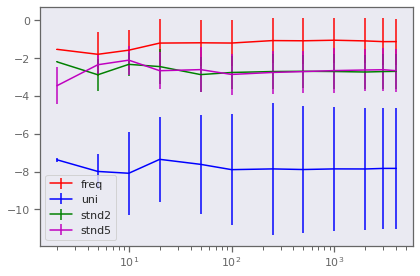

In [74]:
steps = [2,5,10,20,50,100,250,500,1000,2000,3000,4000]


instance = selfies_list[5]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

ngram = 1
#dist_type = 'uni'

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

freq_avg_data = []
freq_std_data = []

uni_avg_data = []
uni_std_data = []

stoned_2_avg_data = []
stoned_2_std_data = []

stoned_5_avg_data = []
stoned_5_std_data = []

for s in steps:
    freq_samples = get_random_samples(instance_len, ngram, s, 'freq')
    #freq_pred = np.reshape(model(freq_samples),-1)
    freq_pred = predictor_function(freq_samples)
    freq_avg_data.append(np.mean(freq_pred))
    freq_std_data.append(np.std(freq_pred))
    
    uni_samples = get_random_samples(instance_len, ngram, s, 'uni')
    #uni_pred = np.reshape(model(uni_samples),-1)
    uni_pred = predictor_function(uni_samples)
    uni_avg_data.append(np.mean(uni_pred))
    uni_std_data.append(np.std(uni_pred))
    
    stoned_2_samples = get_stoned_samples(instance, s, 2) # 2 mutations
    #stoned_2_pred = np.reshape(model(stoned_2_samples),-1)
    stoned_2_pred = predictor_function(stoned_2_samples)
    stoned_2_avg_data.append(np.mean(stoned_2_pred))
    stoned_2_std_data.append(np.std(stoned_2_pred))
    
    stoned_5_samples = get_stoned_samples(instance, s, 5) # 5 mutations
    #stoned_5_pred = np.reshape(model(stoned_5_samples),-1)
    stoned_5_pred = predictor_function(stoned_5_samples)
    stoned_5_avg_data.append(np.mean(stoned_5_pred))
    stoned_5_std_data.append(np.std(stoned_5_pred))

    
print('freq_avg_data: ',freq_avg_data)
print('freq_std_data: ',freq_std_data)
print()
print('uni_avg_data: ',uni_avg_data)
print('uni_std_data: ',uni_std_data)
print()
print('stoned_2_avg_data: ',stoned_2_avg_data)
print('stoned_2_std_data: ',stoned_2_std_data)
print()
print('stoned_5_avg_data: ',stoned_5_avg_data)
print('stoned_5_std_data: ',stoned_5_std_data)
print()

plt.errorbar(steps, freq_avg_data, yerr = freq_std_data, fmt='-r',label='freq')
plt.errorbar(steps, uni_avg_data, yerr = uni_std_data, fmt='-b',label='uni')
plt.errorbar(steps, stoned_2_avg_data, yerr = stoned_2_std_data, fmt='-g',label='stnd2')
plt.errorbar(steps, stoned_5_avg_data, yerr = stoned_5_std_data, fmt='-m',label='stnd5')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

instance:  [C][C][C][C][C][C][Branch1_1][Branch2_1][C][C][C][Branch1_2][C][=O][O][C][Ring1][Branch2_3]
instance ints:  [78, 78, 78, 78, 78, 78, 66, 69, 78, 78, 78, 67, 78, 27, 162, 78, 178, 71]
instance len:  18

freq_avg_data:  [-1.7711457, -2.2426767, -1.7787138, -1.8078048, -1.8511124, -1.8121017, -1.8240427, -1.7599019, -1.7187184, -1.7924634, -1.7859951, -1.7836555]
freq_std_data:  [0.8565825, 1.0610672, 1.2178295, 1.4924462, 1.3480409, 1.296626, 1.2630521, 1.2244782, 1.2654121, 1.2694694, 1.2642586, 1.2670176]

uni_avg_data:  [-5.090903, -7.9079275, -8.432844, -7.9551964, -8.114433, -8.226823, -8.341892, -8.401977, -8.489501, -8.411504, -8.370594, -8.385394]
uni_std_data:  [1.1148435, 2.9417121, 2.774389, 2.6030037, 2.973941, 3.095033, 3.2317812, 3.180241, 3.142105, 3.1032383, 3.1128137, 3.1343603]

stoned_2_avg_data:  [-2.9251404, -1.6253016, -2.1865191, -2.388901, -1.8572135, -2.024499, -2.0257585, -2.0846481, -2.0843737, -2.0933783, -2.0619936, -2.0509775]
stoned_2_std_data:  

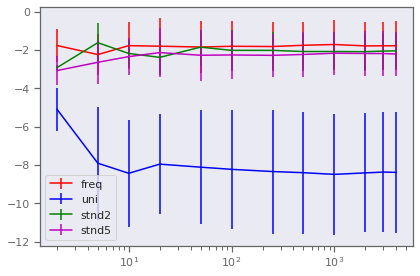

In [75]:
steps = [2,5,10,20,50,100,250,500,1000,2000,3000,4000]


instance = selfies_list[6]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

ngram = 1
#dist_type = 'uni'

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

freq_avg_data = []
freq_std_data = []

uni_avg_data = []
uni_std_data = []

stoned_2_avg_data = []
stoned_2_std_data = []

stoned_5_avg_data = []
stoned_5_std_data = []

for s in steps:
    freq_samples = get_random_samples(instance_len, ngram, s, 'freq')
    #freq_pred = np.reshape(model(freq_samples),-1)
    freq_pred = predictor_function(freq_samples)
    freq_avg_data.append(np.mean(freq_pred))
    freq_std_data.append(np.std(freq_pred))
    
    uni_samples = get_random_samples(instance_len, ngram, s, 'uni')
    #uni_pred = np.reshape(model(uni_samples),-1)
    uni_pred = predictor_function(uni_samples)
    uni_avg_data.append(np.mean(uni_pred))
    uni_std_data.append(np.std(uni_pred))
    
    stoned_2_samples = get_stoned_samples(instance, s, 2) # 2 mutations
    #stoned_2_pred = np.reshape(model(stoned_2_samples),-1)
    stoned_2_pred = predictor_function(stoned_2_samples)
    stoned_2_avg_data.append(np.mean(stoned_2_pred))
    stoned_2_std_data.append(np.std(stoned_2_pred))
    
    stoned_5_samples = get_stoned_samples(instance, s, 5) # 5 mutations
    #stoned_5_pred = np.reshape(model(stoned_5_samples),-1)
    stoned_5_pred = predictor_function(stoned_5_samples)
    stoned_5_avg_data.append(np.mean(stoned_5_pred))
    stoned_5_std_data.append(np.std(stoned_5_pred))

    
print('freq_avg_data: ',freq_avg_data)
print('freq_std_data: ',freq_std_data)
print()
print('uni_avg_data: ',uni_avg_data)
print('uni_std_data: ',uni_std_data)
print()
print('stoned_2_avg_data: ',stoned_2_avg_data)
print('stoned_2_std_data: ',stoned_2_std_data)
print()
print('stoned_5_avg_data: ',stoned_5_avg_data)
print('stoned_5_std_data: ',stoned_5_std_data)
print()

plt.errorbar(steps, freq_avg_data, yerr = freq_std_data, fmt='-r',label='freq')
plt.errorbar(steps, uni_avg_data, yerr = uni_std_data, fmt='-b',label='uni')
plt.errorbar(steps, stoned_2_avg_data, yerr = stoned_2_std_data, fmt='-g',label='stnd2')
plt.errorbar(steps, stoned_5_avg_data, yerr = stoned_5_std_data, fmt='-m',label='stnd5')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

instance:  [C][=C][Branch1_1][C][C][C][=C][C][=C][C][Branch1_1][Branch1_2][C][Branch1_2][C][=C][C][=C][Ring1][Branch2_2]
instance ints:  [78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
instance len:  20

freq_avg_data:  [-2.1405866, -2.0600452, -1.8800402, -2.0107598, -1.9958113, -2.03694, -2.0033035, -1.9826627, -2.0072846, -2.0545483, -2.0587864, -2.04911]
freq_std_data:  [1.3126425, 1.3891823, 1.2189535, 1.2469025, 1.3352301, 1.311774, 1.261611, 1.3054235, 1.3179374, 1.3038951, 1.3113432, 1.3135467]

uni_avg_data:  [-7.0669494, -8.672594, -8.459037, -7.9004755, -8.4317465, -8.123127, -8.281058, -8.552783, -8.620564, -8.66019, -8.618502, -8.615766]
uni_std_data:  [3.5482488, 3.7538226, 3.069847, 2.9253702, 2.809255, 3.1720355, 3.368647, 3.2860096, 3.2908788, 3.192405, 3.1887226, 3.1522186]

stoned_2_avg_data:  [-2.9118323, -3.9108768, -3.6206794, -3.9227684, -3.7599368, -3.8469262, -3.7767444, -3.8051784, -3.7339146, -3.7389824, -3.7485163, -3.7551343]
st

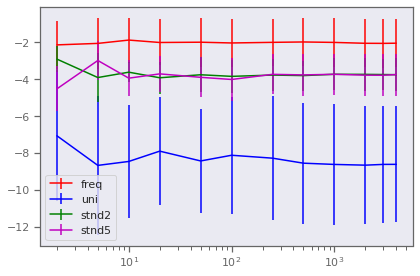

In [76]:
steps = [2,5,10,20,50,100,250,500,1000,2000,3000,4000]


instance = selfies_list[37]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

ngram = 1
#dist_type = 'uni'

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

freq_avg_data = []
freq_std_data = []

uni_avg_data = []
uni_std_data = []

stoned_2_avg_data = []
stoned_2_std_data = []

stoned_5_avg_data = []
stoned_5_std_data = []

for s in steps:
    freq_samples = get_random_samples(instance_len, ngram, s, 'freq')
    #freq_pred = np.reshape(model(freq_samples),-1)
    freq_pred = predictor_function(freq_samples)
    freq_avg_data.append(np.mean(freq_pred))
    freq_std_data.append(np.std(freq_pred))
    
    uni_samples = get_random_samples(instance_len, ngram, s, 'uni')
    #uni_pred = np.reshape(model(uni_samples),-1)
    uni_pred = predictor_function(uni_samples)
    uni_avg_data.append(np.mean(uni_pred))
    uni_std_data.append(np.std(uni_pred))
    
    stoned_2_samples = get_stoned_samples(instance, s, 2) # 2 mutations
    #stoned_2_pred = np.reshape(model(stoned_2_samples),-1)
    stoned_2_pred = predictor_function(stoned_2_samples)
    stoned_2_avg_data.append(np.mean(stoned_2_pred))
    stoned_2_std_data.append(np.std(stoned_2_pred))
    
    stoned_5_samples = get_stoned_samples(instance, s, 5) # 5 mutations
    #stoned_5_pred = np.reshape(model(stoned_5_samples),-1)
    stoned_5_pred = predictor_function(stoned_5_samples)
    stoned_5_avg_data.append(np.mean(stoned_5_pred))
    stoned_5_std_data.append(np.std(stoned_5_pred))

    
print('freq_avg_data: ',freq_avg_data)
print('freq_std_data: ',freq_std_data)
print()
print('uni_avg_data: ',uni_avg_data)
print('uni_std_data: ',uni_std_data)
print()
print('stoned_2_avg_data: ',stoned_2_avg_data)
print('stoned_2_std_data: ',stoned_2_std_data)
print()
print('stoned_5_avg_data: ',stoned_5_avg_data)
print('stoned_5_std_data: ',stoned_5_std_data)
print()

plt.errorbar(steps, freq_avg_data, yerr = freq_std_data, fmt='-r',label='freq')
plt.errorbar(steps, uni_avg_data, yerr = uni_std_data, fmt='-b',label='uni')
plt.errorbar(steps, stoned_2_avg_data, yerr = stoned_2_std_data, fmt='-g',label='stnd2')
plt.errorbar(steps, stoned_5_avg_data, yerr = stoned_5_std_data, fmt='-m',label='stnd5')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

## Shapley Simple

In [77]:
# Compute Shapley Value for a particular position of an instance

def shapley(instance_ints, feat, samples, model, shuffle, debug=False):
    instance_len = len(instance_ints)
    #act_len = len([i for i in instance_ints if i!=vocab_stoi['[Nop]']])
    #print(act_len)
    #if feat >= instance_len:
    #if feat >= act_len:
    #    print("Error: feat >= seq_len")
    #    return exit(1)
    feat_int = instance_ints[feat]
    if debug: print("feat_int: ",feat_int)
        
    samples = np.array(samples)
    
    if np.shape(samples)[1]!=instance_len:
        if debug: print("modifying samples")
        samples = samples[:,:instance_len]
    
    if debug: 
        print("samples")
        print(samples)
        print()
    
    if shuffle:
        #choice
        choice_p = np.stack([np.random.randint(2, size=instance_len) for i in range(len(samples))])
        choice_p[:,feat] = 1
        if debug: 
            print("choice_p")
            print(choice_p)
            print()

        choice_m = np.copy(choice_p)
        choice_m[:,feat] = 0
        if debug: 
            print("choice_m")
            print(choice_m)
            print()

        # shuffled x's based on choice
        seq_p = (instance_ints * choice_p) + (samples * (1-choice_p))
        seq_m = (instance_ints * choice_m) + (samples * (1-choice_m))
    
    else:
        seq_p = samples.copy()
        seq_m = samples.copy()    
        # modify seq_p
        seq_p[:,feat] = feat_int
    
    
    if debug: 
        print("seq_p")
        print(seq_p)
        print()
        print("seq_m")
        print(seq_m)
        print()

    val_p = predictor_function(seq_p)
    val_m = predictor_function(seq_m)
    if debug: 
        print("val_p")
        print(val_p)
        print()
        print("val_m")
        print(val_m)
        print()
        

    result = np.sum(val_p-val_m)/len(samples)
    
    return result

In [78]:
instance = selfies_list[5]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

feat = 2
steps = 2000
ngram = 1

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

shapley(instance_ints, feat, train_samples, model, True)

instance:  [C][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]
instance ints:  [78, 9, 78, 9, 78, 9, 78, 66, 78, 78, 9, 178, 68]
instance len:  13



-0.23724504332777674

In [79]:
shapley(instance_ints, 0, train_samples[:3], model, True, debug=True)

feat_int:  78
modifying samples
samples
[[162  33  67  78  27  66  23 149  78   9  78   9  66]
 [ 78 146  87   0   0   0   0   0   0   0   0   0   0]
 [ 78  78 162  78   9  78   9  69 178  66  78  67  78]]

choice_p
[[1 0 1 1 0 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0 0 1 0 1 1]
 [1 0 1 0 0 1 0 1 0 0 1 1 1]]

choice_m
[[0 0 1 1 0 1 0 1 1 1 1 0 0]
 [0 1 1 1 1 1 0 0 0 1 0 1 1]
 [0 0 1 0 0 1 0 1 0 0 1 1 1]]

seq_p
[[ 78  33  78   9  27   9  23  66  78  78   9   9  66]
 [ 78   9  78   9  78   9   0   0   0  78   0 178  68]
 [ 78  78  78  78   9   9   9  66 178  66   9 178  68]]

seq_m
[[162  33  78   9  27   9  23  66  78  78   9   9  66]
 [ 78   9  78   9  78   9   0   0   0  78   0 178  68]
 [ 78  78  78  78   9   9   9  66 178  66   9 178  68]]

val_p
[-2.1238432 -1.8136283 -3.3014457]

val_m
[-1.3109125 -1.8136283 -3.3014457]



-0.2709769010543823

In [80]:
mod_instance_ints = instance_ints[:]
print(mod_instance_ints)
mod_instance_ints.extend([vocab_stoi['[nop]']]*(134-len(mod_instance_ints)))
print(mod_instance_ints)
print(instance_ints)

[78, 9, 78, 9, 78, 9, 78, 66, 78, 78, 9, 178, 68]
[78, 9, 78, 9, 78, 9, 78, 66, 78, 78, 9, 178, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[78, 9, 78, 9, 78, 9, 78, 66, 78, 78, 9, 178, 68]


In [81]:
shapley(mod_instance_ints, 0, train_samples[:3], model, True, debug=True)

feat_int:  78
modifying samples
samples
[[162  33  67  78  27  66  23 149  78   9  78   9  66  78  88  78   9 178
   68  78   9  78   9  78   9 178  67   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [ 78 146  87   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0

-0.4132688045501709

In [82]:
instance = selfies_list[5]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

feat = 2
steps = 2000
ngram = 1

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

uni_samples = get_random_samples(instance_len, ngram, steps, 'uni')
freq_samples = get_random_samples(instance_len, ngram, steps, 'freq')
stoned_2_samples = get_stoned_samples(instance, steps, 2)
stoned_5_samples = get_stoned_samples(instance, steps, 5)

print(shapley(instance_ints, feat, uni_samples, model, True))
print(shapley(instance_ints, feat, uni_samples, model, False))
print()
print(shapley(instance_ints, feat, freq_samples, model, True))
print(shapley(instance_ints, feat, freq_samples, model, False))
print()
print(shapley(instance_ints, feat, stoned_2_samples, model, True))
print(shapley(instance_ints, feat, stoned_2_samples, model, False))
print()
print(shapley(instance_ints, feat, stoned_5_samples, model, True))
print(shapley(instance_ints, feat, stoned_5_samples, model, False))
print()

instance:  [C][=C][C][=C][C][=C][C][Branch1_1][C][C][=C][Ring1][Branch1_3]
instance ints:  [78, 9, 78, 9, 78, 9, 78, 66, 78, 78, 9, 178, 68]
instance len:  13

0.2512086181640625
0.2055875701904297

-0.09744732666015625
-0.09480196380615234

0.01461042308807373
0.017727611541748046

0.03911659622192383
0.06819410705566406



In [83]:
[[selfies_list.index(s),len(list(sf.split_selfies(s)))] for s in selfies_list if s == '[O][B][Branch1_1][C][O][O]']

[[2164, 6]]

In [84]:
train_samples.shape

(7986, 615)

In [85]:
def get_shap_vals(instance, sampling_type, steps, model, shuffle=True, ngram=1, num_mutations=2, dist_type='uni',train_data=[], force_len=None):

    instance_ints = selfies2ints(instance)
    instance_len = len(instance_ints)
    
    if force_len != None and force_len <= train_data.shape[1]: 
        instance_ints.extend([vocab_stoi['[nop]']]*(force_len-len(instance_ints)))
        #instance_ints.extend(np.zeros(force_len-len(instance_ints)))
        instance_len = len(instance_ints)
    
    print(instance_ints)
    print(instance_len)
    
    if sampling_type=='stoned':
        samples = get_stoned_samples(instance, steps, num_mutations)
    elif sampling_type=='random':
        samples = get_random_samples(instance_len, ngram, steps, dist_type)
    elif sampling_type=='train':
        samples = train_data[:steps]
        
    if np.shape(samples)[1]!=instance_len:
        #print("modifying samples")
        samples = samples[:,:instance_len]
    
    
    print(samples.shape)
    
    pred = np.reshape(model(samples),-1)
    expec_val = np.mean(pred)
    expec_val_std = np.std(pred)
    
    #print(expec_val)
    
    shap_val = [shapley(instance_ints, feat, samples, model, shuffle) for feat in range(instance_len)]
    
    return shap_val, expec_val, expec_val_std

In [86]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Train Sampling + Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [0.41322564697265624, -2.06444384765625, 0.2654369201660156, 0.21993356323242189, 0.302830810546875, 0.3633486328125]
Sum SV:  -0.499668273925781
Expectation Value:  -0.4205836  +-  1.5339214
Full Sum:  -0.9202518796920773
f(s):  -0.72970206
%err:  -26.11337364524787



In [87]:
instance = selfies_list[2164]
steps = 2000

#np.random.seed(1000)
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print()
label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print("f(s): ", label)
print()
print("%err: ", (label-full_sum)*100/label)

[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.222525146484375, -1.260387939453125, 0.8142299194335938, 1.622584228515625, 1.23846044921875, 1.54058251953125]
Sum SV:  5.177994323730468
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -1.0747675170898443

f(s):  -0.72970206

%err:  -47.28854181735585


In [88]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=False, train_data = train_samples)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
print(" Train Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Train Sampling + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [0.7008682861328125, -2.28719775390625, 0.3261442260742187, -0.10486239624023437, 0.853910888671875, 0.9495362548828125]
Sum SV:  0.43839950561523433
Expectation Value:  -0.4205836  +-  1.5339214
Full Sum:  0.017815899848937944
f(s):  -0.72970206
%err:  102.4415307200755

 Train Sampling + Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [0.43067694091796876, -2.039904296875, 0.2676541748046875, 0.21379495239257812, 0.29221292114257813, 0.35906439208984375]
Sum SV:  -0.47650091552734386
Expectation Value:  -0.4205836  +-  1.5339214
Full Sum:  -0.8970845212936402
f(s):  -0.72970206
%err:  -22.938467089172057



In [89]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]

print(" Uniform Sampling + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
print(" Uniform Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
print(" Multinomial + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='freq')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
print(" Multinomial + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='freq')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
num_mutations=2
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=2)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
num_mutations=5
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=5)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Uniform Sampling + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.03189453125, -1.141199951171875, 0.41207711791992185, 0.854345947265625, 1.026375, 1.40974609375]
Sum SV:  3.593238739013672
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -2.6595231018066405
f(s):  -0.72970206
%err:  -264.4669878517793

 Uniform Sampling + Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.222525146484375, -1.260387939453125, 0.8142299194335938, 1.622584228515625, 1.23846044921875, 1.54058251953125]
Sum SV:  5.177994323730468
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -1.0747675170898443
f(s):  -0.72970206
%err:  -47.28854181735585

 Multinomial + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [0.5395133666992188, -2.62590869140625, 0.14865313720703124, -0.12448825073242188, 0.4879391479492188, 0.7138414916992187]
Sum SV:  

## Plots

In [90]:
import matplotlib.patches as mpatches

In [91]:
def bar_plot(instance, shap_vals, exp_val, label, doGrid=True, doText=True, doXLabel=True, doYLabel=False, dpi=200):
    instance_tokens = [s for s in list(sf.split_selfies(instance)) if s!='.']
    shifts = []
    cols = []
    comb_vals = [exp_val]+shap_vals
    shift = 0
    for i in range(len(comb_vals)):
        shifts.append(shift)
        shift+=comb_vals[i]
        col = 'b' if comb_vals[i]>=0 else 'r'
        cols.append(col)
    print()
    print(comb_vals)
    print(shifts)
    print(cols)
    
    inds = np.arange(len(shap_vals)+1)
    
    if len(instance_tokens)!=len(shap_vals):
        instance_tokens.extend(['[Nop]'] * (len(shap_vals)-len(instance_tokens)))
        
    print(inds)
    
    print(len(comb_vals)," ",len(inds))
    
    if doGrid: plt.grid(True, linewidth=0.5, color='darkgrey', linestyle='-')
    
    plt.axhline(y=label,color='green', label='$\hat f(x)$')
    
    plt.bar(inds, comb_vals, bottom=shifts, color=cols)
    
    if doYLabel:
        for i, v in enumerate(comb_vals):
            fac = -0.11*abs(label) if cols[i]== 'r' else 0.05*abs(label)
            #print(i," ",v+shifts[i]," ",cols[i]," ",fac," ",v+shifts[i]+fac)
            plt.text(i-0.35, v+shifts[i]+fac, r'%0.3f'%(v), color='black', fontsize='x-small')
    
    if doText:
        textstr = '\n'.join((
            r'$\hat f(x)$ = %0.4f' % (label),
            r'$\Phi_{0}$ = %0.4f' %(exp_val),
            r'Sum = %0.4f' % (np.sum(comb_vals)),
            r'Error = %0.2f%%' % ((np.sum(comb_vals)-label)*100/label)))
        plt.text(0.95, 0.2, textstr, fontsize=14, transform=plt.gcf().transFigure)    
    
    if doXLabel: 
        print("inds: ", len(inds))
        print("instance_tokens: ",instance_tokens)
        print("instance_tokens: ",len(instance_tokens))
        
        plt.xticks(inds, ['$\Phi_{0}$']+instance_tokens, rotation = 60)
    
    ymax = max(shifts+[label])
    ymin = min(shifts+[label])
    if abs(ymax)<=0.1: ymax=0.2*abs(ymin)
    elif ymax>0: ymax*=1.1
    elif ymax<0: ymax*=0.9
    
    if abs(ymin)<=0.1: ymin=-0.2*abs(ymax)
    elif ymin>0: ymax*=0.9
    elif ymin<0: ymin*=1.1
    
    plt.ylim([ymin, ymax])
    
    plt.ylabel('Shapley Value ($\Phi$)')
    
    red_patch = mpatches.Patch(color='red', label='-ve $\Phi$')
    blue_patch = mpatches.Patch(color='blue', label='+ve $\Phi$')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.extend([red_patch,blue_patch])
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.legend(handles=handles, loc=(1.05, 0.75))
    
    #plt.figure(figsize=(1,1))
    plt.rcParams['figure.figsize'] = [5, 4]
    plt.rcParams['figure.dpi'] = dpi
    return plt.show()

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Train Sampling + Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [0.29838714599609373, -0.48894256591796875, 0.15902053833007812, 0.573956787109375, 0.054166091918945315, 0.08395218658447266]
Sum SV:  0.680540184020996
Expectation Value:  -1.4089509  +-  1.4865149
Full Sum:  -0.728410740852356
f(s):  -0.72970206
%err:  0.17696463813497978


[-1.4089509, 0.29838714599609373, -0.48894256591796875, 0.15902053833007812, 0.573956787109375, 0.054166091918945315, 0.08395218658447266]
[0, -1.408950924873352, -1.1105637788772582, -1.599506344795227, -1.4404858064651487, -0.8665290193557736, -0.8123629274368284]
['r', 'b', 'r', 'b', 'b', 'b', 'b']
[0 1 2 3 4 5 6]
7   7
inds:  7
instance_tokens:  ['[O]', '[B]', '[Branch1_1]', '[C]', '[O]', '[O]']
instance_tokens:  6


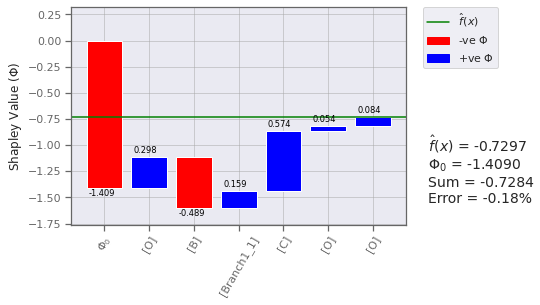

In [92]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=2)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=True, dpi=400)


[-1.4089509, 0.29838714599609373, -0.48894256591796875, 0.15902053833007812, 0.573956787109375, 0.054166091918945315, 0.08395218658447266]
[0, -1.408950924873352, -1.1105637788772582, -1.599506344795227, -1.4404858064651487, -0.8665290193557736, -0.8123629274368284]
['r', 'b', 'r', 'b', 'b', 'b', 'b']
[0 1 2 3 4 5 6]
7   7


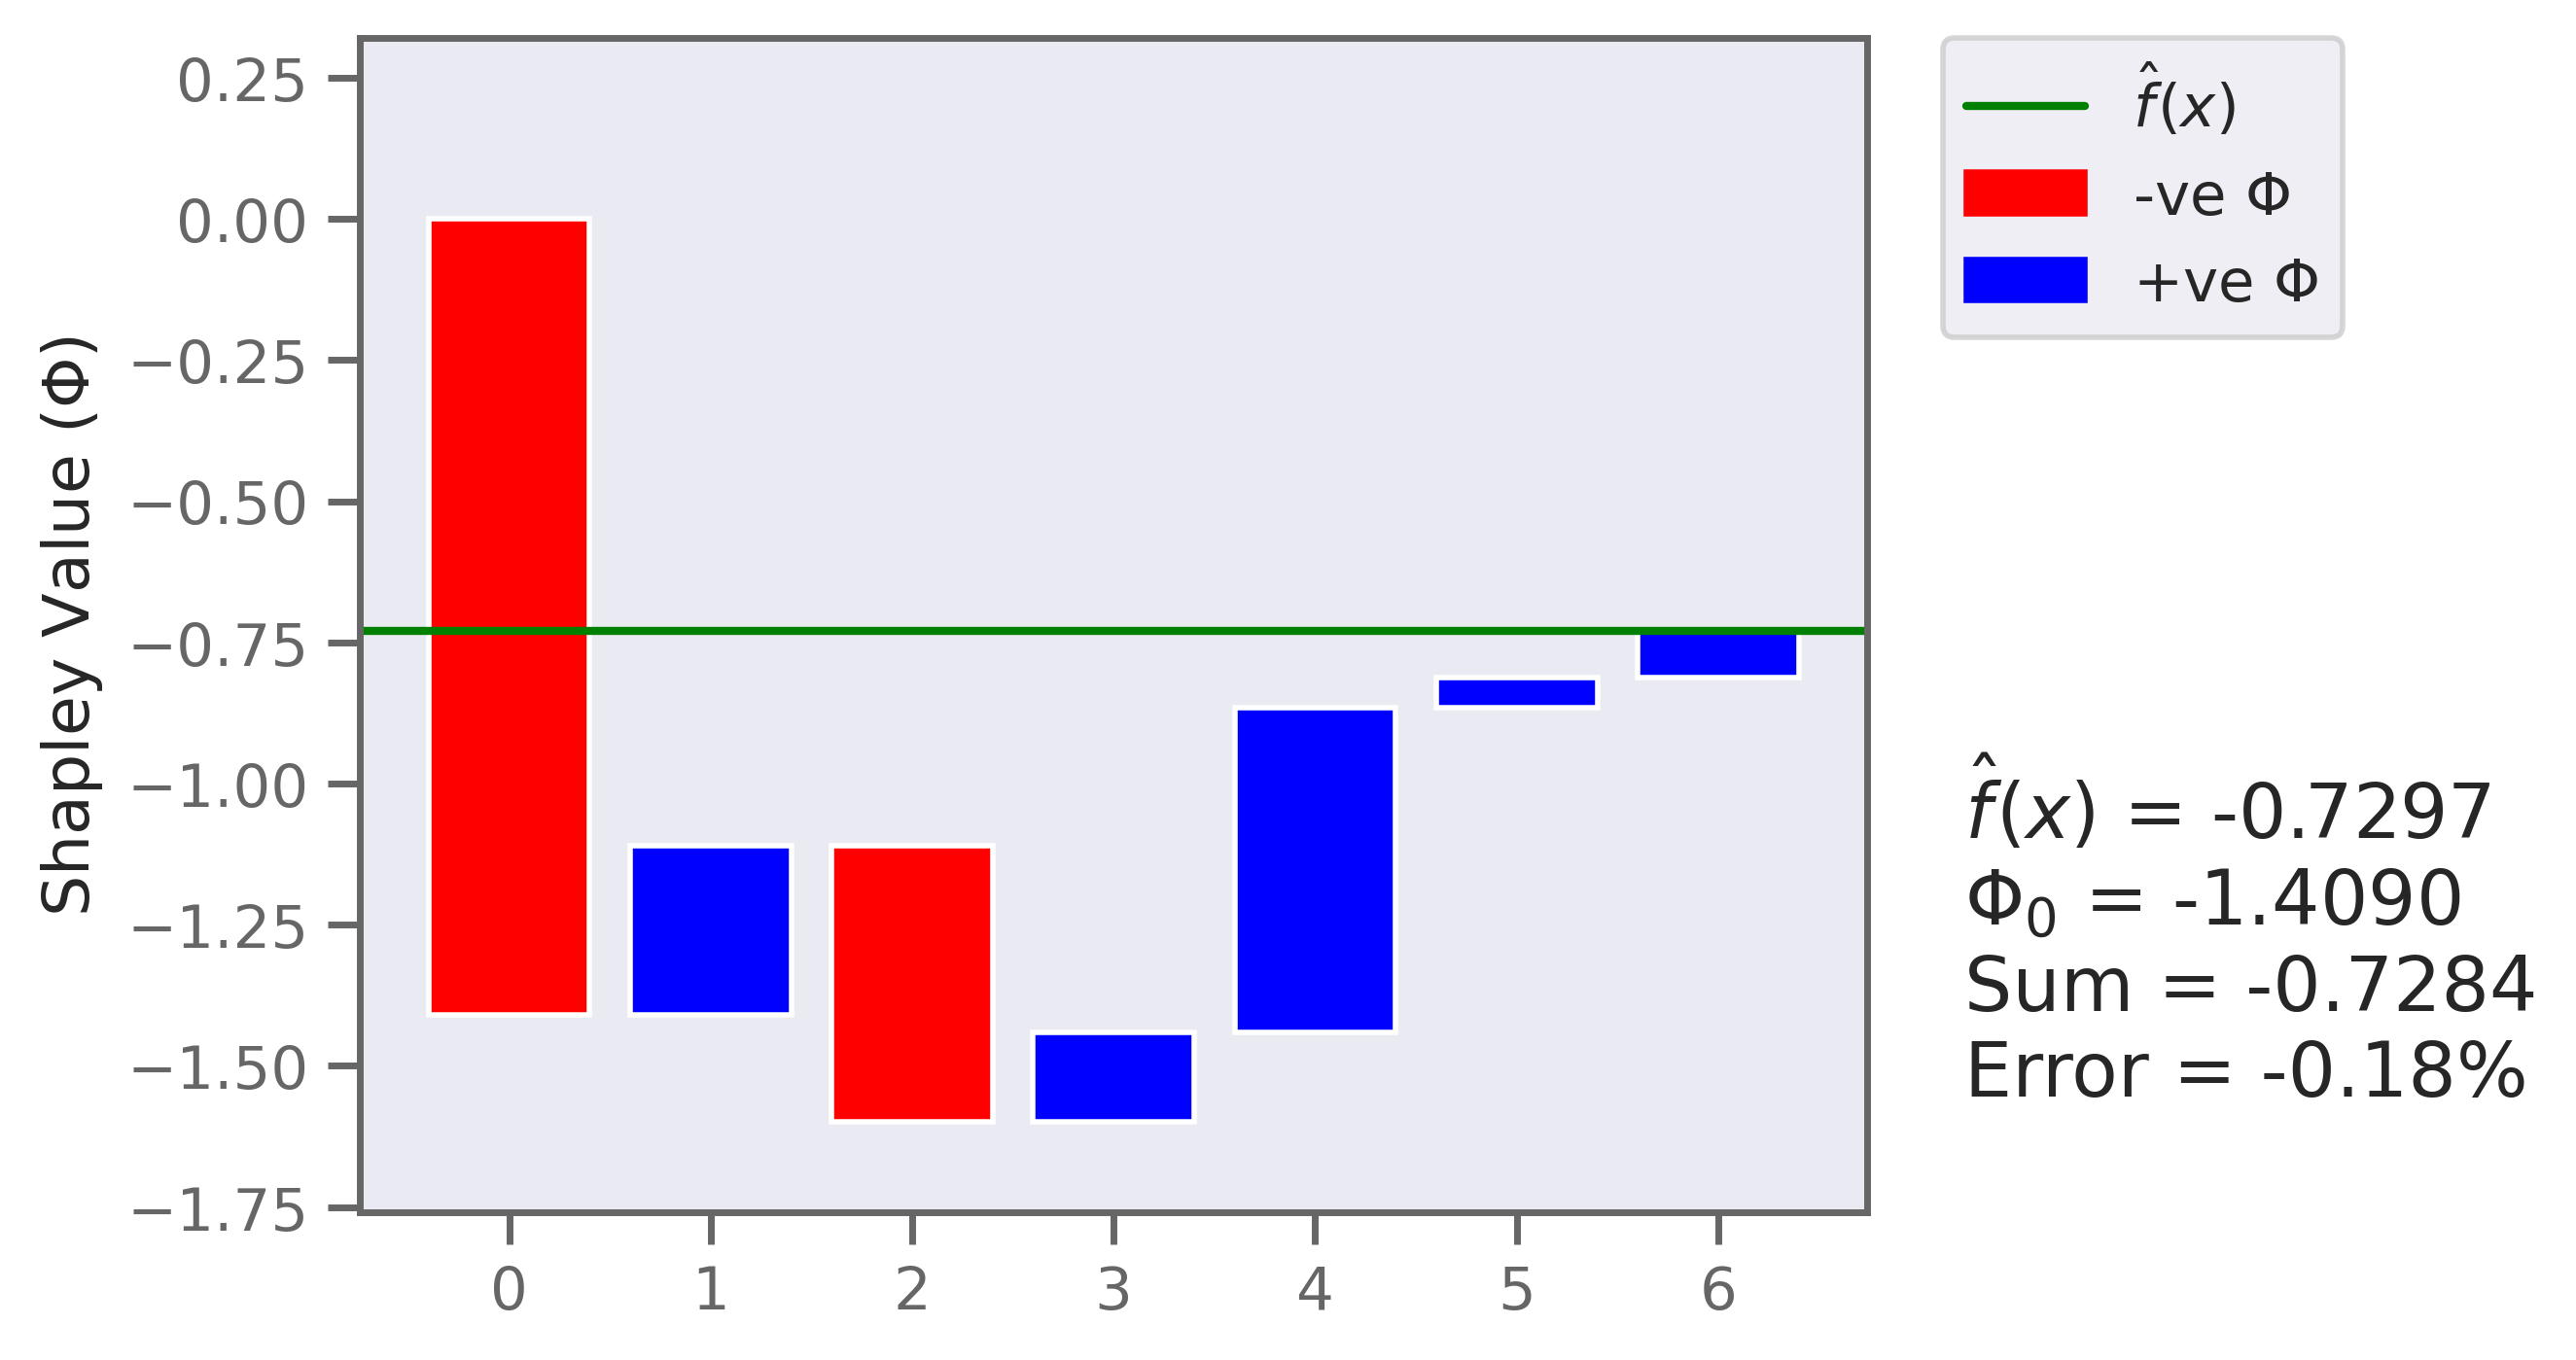

In [93]:
bar_plot(instance, shap_val, sample_mean, label, doGrid=False, doXLabel=False, dpi=400)

In [94]:
for s in ['[O][B][Branch1_1][C][O][O]',
               '[nop][O][B][nop][Branch1_1][C][nop][O][O][nop]',
               '[nop][O][B][nop][Branch1_1][C][nop][O][O][nop]' + '[nop]'*20, 
               '[nop]'*20 + '[nop][O][B][nop][Branch1_1][C][nop][O][O][nop]']:
    print(s," ", model.predict([selfies2ints(s)]).flatten())

[O][B][Branch1_1][C][O][O]   [-0.72970206]
[nop][O][B][nop][Branch1_1][C][nop][O][O][nop]   [-0.72970206]
[nop][O][B][nop][Branch1_1][C][nop][O][O][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]   [-0.72970206]
[nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][O][B][nop][Branch1_1][C][nop][O][O][nop]   [-0.72970206]


instance:  [nop][O][B][nop][Branch1_1][C][nop][O][O][nop]
instance ints:  [0, 162, 58, 0, 66, 78, 0, 162, 162, 0]
instance len:  10

 Train Sampling + Shuffle
[0, 162, 58, 0, 66, 78, 0, 162, 162, 0]
10
(2000, 10)
shapley values:  [0.08634574890136719, 0.16106446838378907, -0.266462158203125, -0.022223579406738282, 0.09870223236083984, 0.3059031982421875, 0.04711668014526367, 0.036373558044433596, 0.04529343032836914, -0.014141935348510742]
Sum SV:  0.4779716434478759
Expectation Value:  -1.2113601  +-  1.2541622
Full Sum:  -0.7333884534835816
f(s):  -0.72970206
%err:  -0.5051922221916462


[-1.2113601, 0.08634574890136719, 0.16106446838378907, -0.266462158203125, -0.022223579406738282, 0.09870223236083984, 0.3059031982421875, 0.04711668014526367, 0.036373558044433596, 0.04529343032836914, -0.014141935348510742]
[0, -1.2113600969314575, -1.1250143480300903, -0.9639498796463012, -1.230412037849426, -1.2526356172561643, -1.1539333848953246, -0.8480301866531371, -0.8009135065078734, -0.764

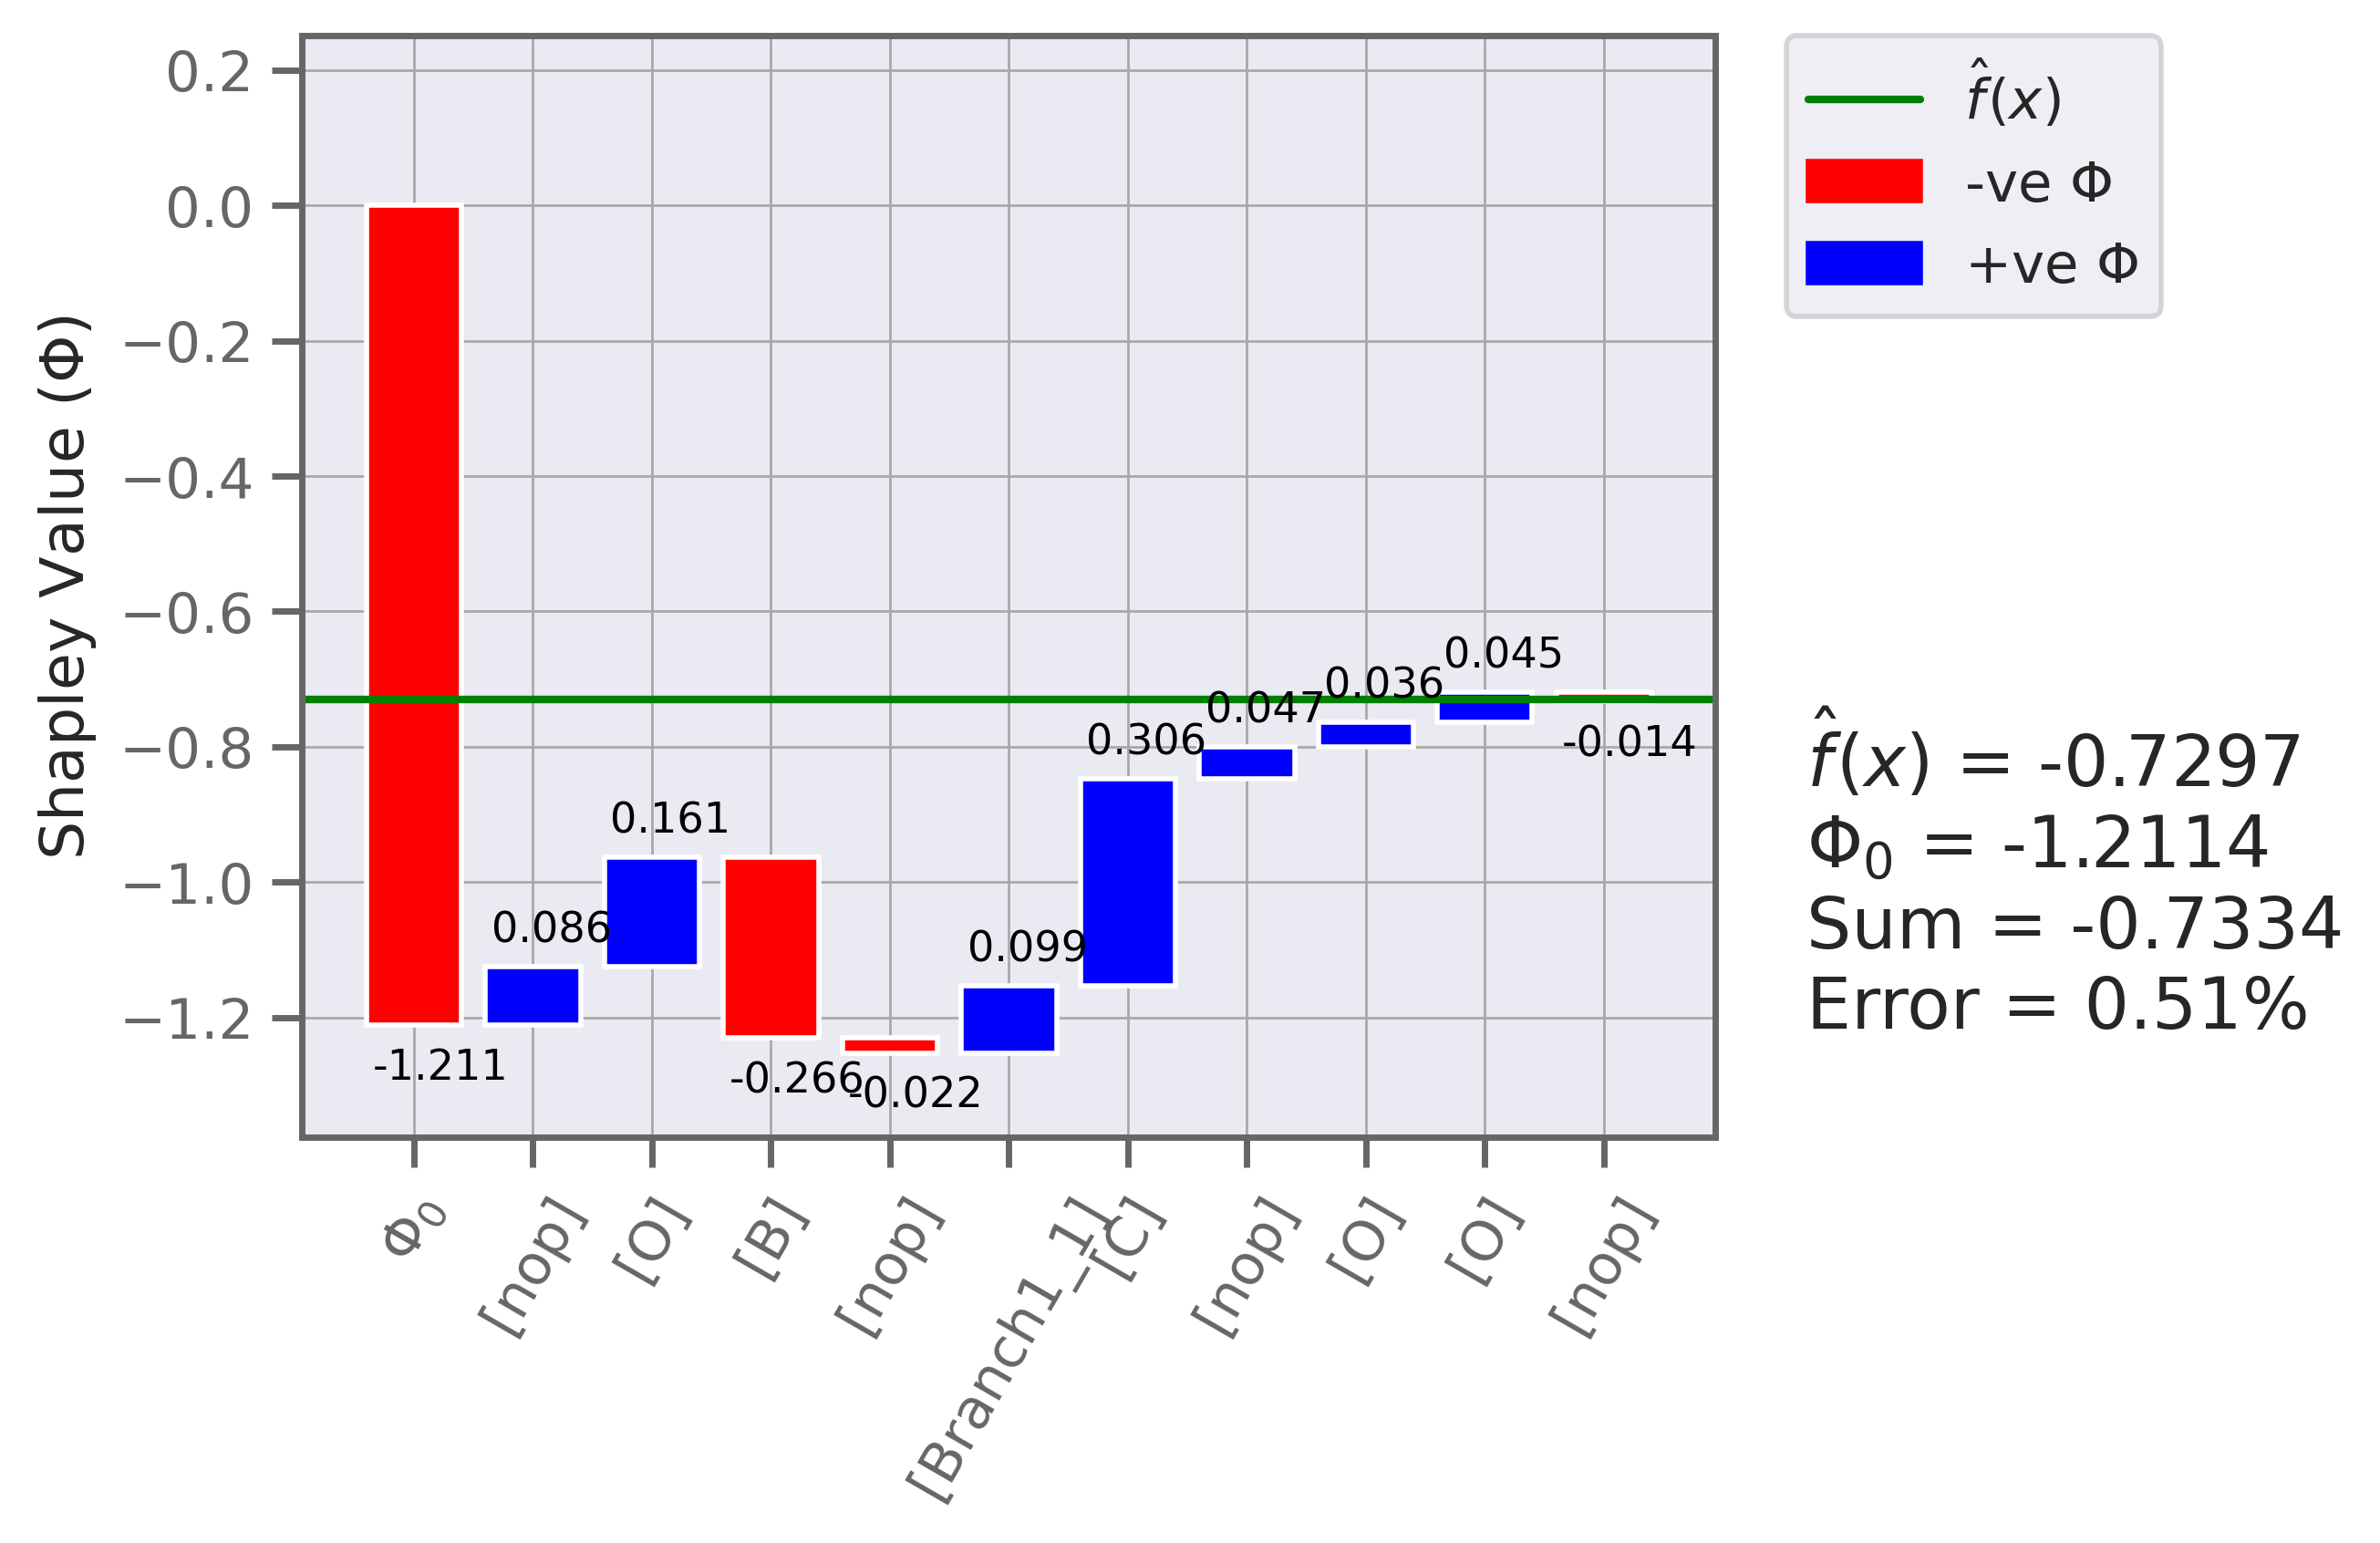

In [95]:
instance = '[nop][O][B][nop][Branch1_1][C][nop][O][O][nop]'
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=2)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=True, dpi=400)

In [96]:
instance = '[nop][O][B][nop][Branch1_1][C][nop][O][O][nop]'
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

feat = 1
steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

samples = get_stoned_samples(instance,steps,2)[:3]
shapley(instance_ints, feat, samples, model, True, debug=True)

instance:  [nop][O][B][nop][Branch1_1][C][nop][O][O][nop]
instance ints:  [0, 162, 58, 0, 66, 78, 0, 162, 162, 0]
instance len:  10

feat_int:  162
samples
[[  0  78  58 187  66  78   0 162 162   0]
 [  0 162  58   0  66  78   0 149 116   0]
 [  0 162  74  72  66  78   0 162 162   0]]

choice_p
[[0 1 0 1 1 1 1 1 0 1]
 [0 1 0 1 1 0 0 0 0 0]
 [0 1 0 1 1 1 1 0 1 0]]

choice_m
[[0 0 0 1 1 1 1 1 0 1]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 1 0]]

seq_p
[[  0 162  58   0  66  78   0 162 162   0]
 [  0 162  58   0  66  78   0 149 116   0]
 [  0 162  74   0  66  78   0 162 162   0]]

seq_m
[[  0  78  58   0  66  78   0 162 162   0]
 [  0 162  58   0  66  78   0 149 116   0]
 [  0 162  74   0  66  78   0 162 162   0]]

val_p
[-0.7297019  -1.1926136   0.57034326]

val_m
[-1.2621821  -1.1926136   0.57034326]



0.17749341328938803

instance:  [nop][O][B][nop][Branch1_1][C][nop][O][O][nop][nop][nop][nop]
instance ints:  [0, 162, 58, 0, 66, 78, 0, 162, 162, 0, 0, 0, 0]
instance len:  13

 Train Sampling + Shuffle
[0, 162, 58, 0, 66, 78, 0, 162, 162, 0, 0, 0, 0]
13
(2000, 13)
shapley values:  [0.08217588806152344, 0.1390167236328125, -0.19374949645996092, -0.005860505104064942, 0.09605709838867188, 0.2602672119140625, 0.02220488929748535, 0.037955810546875, 0.03049264335632324, -0.009933600425720215, -0.010534567832946777, -0.015014686584472657, -0.016527587890625]
Sum SV:  0.4165498208999634
Expectation Value:  -1.1499985  +-  1.1130503
Full Sum:  -0.7334487247467041
f(s):  -0.72970206
%err:  -0.5134519307496752


[-1.1499985, 0.08217588806152344, 0.1390167236328125, -0.19374949645996092, -0.005860505104064942, 0.09605709838867188, 0.2602672119140625, 0.02220488929748535, 0.037955810546875, 0.03049264335632324, -0.009933600425720215, -0.010534567832946777, -0.015014686584472657, -0.016527587890625]
[0, -1.149998545

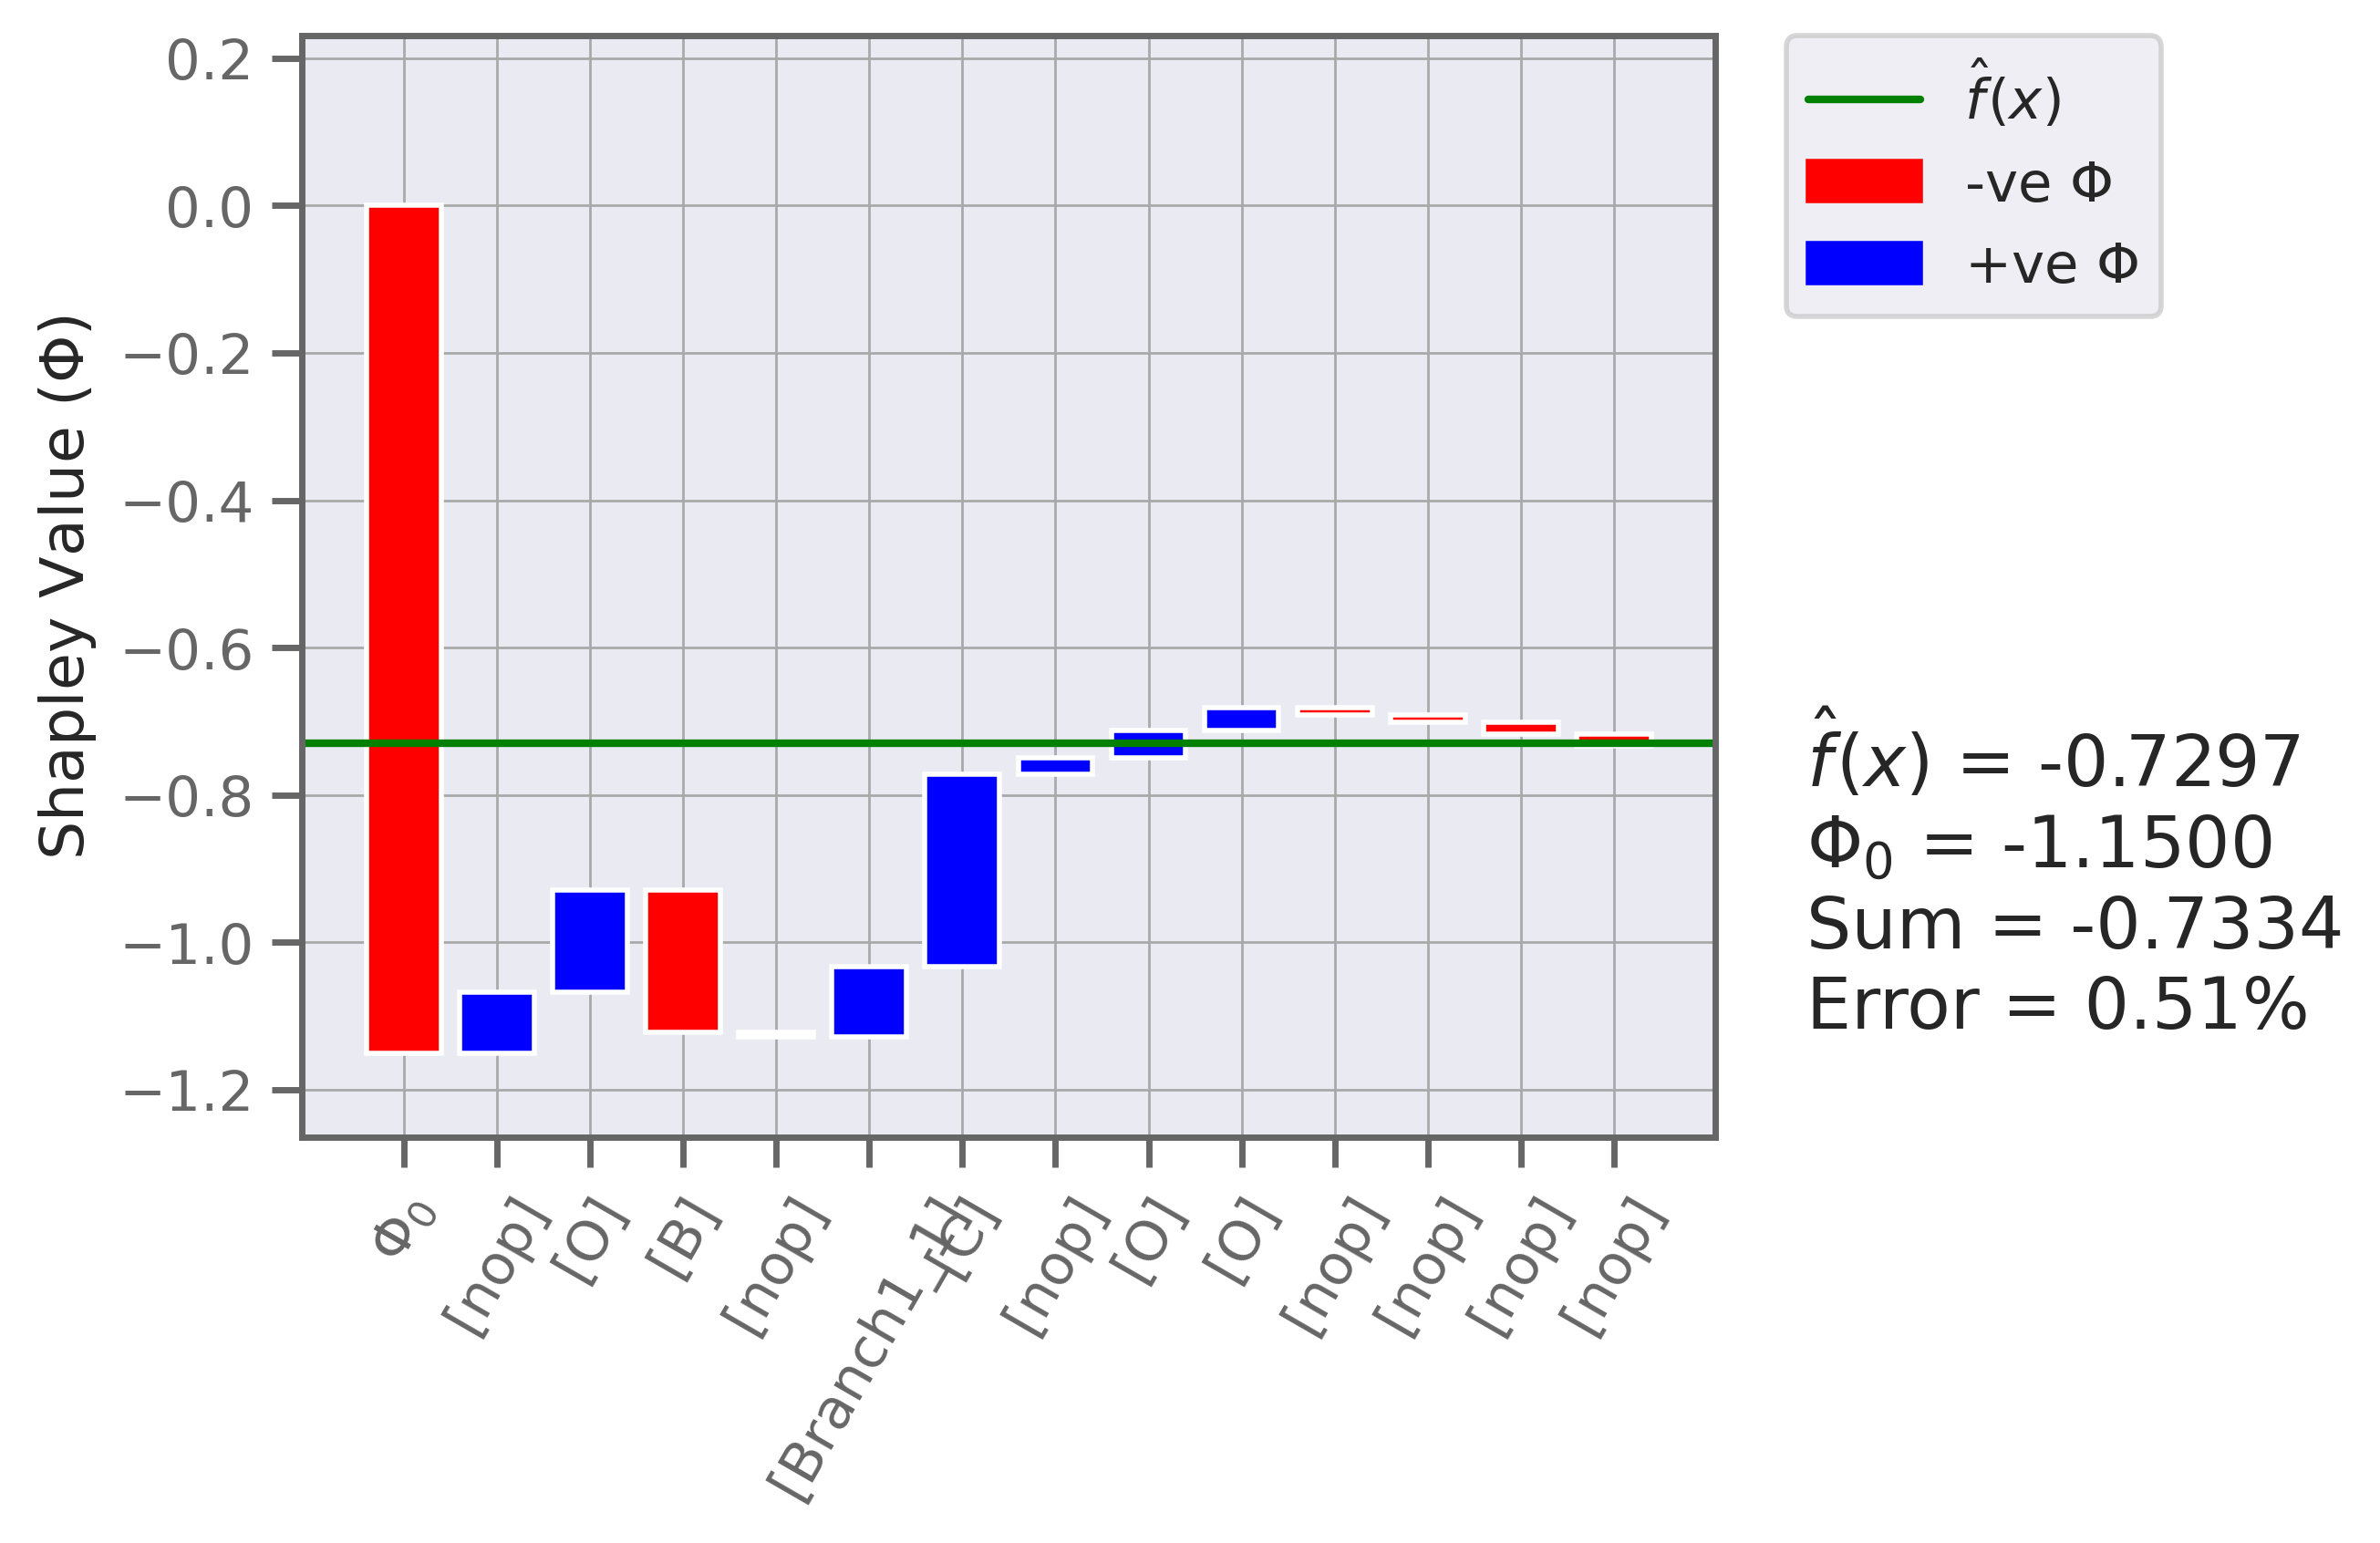

In [97]:
instance = '[nop][O][B][nop][Branch1_1][C][nop][O][O][nop][nop][nop][nop]'
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=2)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=False, dpi=400)

instance:  [nop][O][B][nop][Branch1_1][C][nop][O][O][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
instance ints:  [0, 162, 58, 0, 66, 78, 0, 162, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
instance len:  30

 Train Sampling + Shuffle
[0, 162, 58, 0, 66, 78, 0, 162, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
30
(2000, 30)
shapley values:  [0.03193075180053711, 0.0698958740234375, -0.07867381286621093, -0.001314988374710083, 0.036724029541015626, 0.11205406188964843, 0.01242586898803711, 0.02388990020751953, 0.01636665153503418, -0.0051512870788574215, -0.0035165205001831054, -0.004802484512329102, -0.006570548534393311, 0.0011722731590270996, -0.009137856483459472, -0.008127937316894531, -0.004961471557617187, -0.0025039024353027345, -0.004566583633422851, -0.009935344696044922, -0.0067682027816772464, -0.00599604082107544, -0.0029591989517211916, -0.006432257652282715, -0.00673

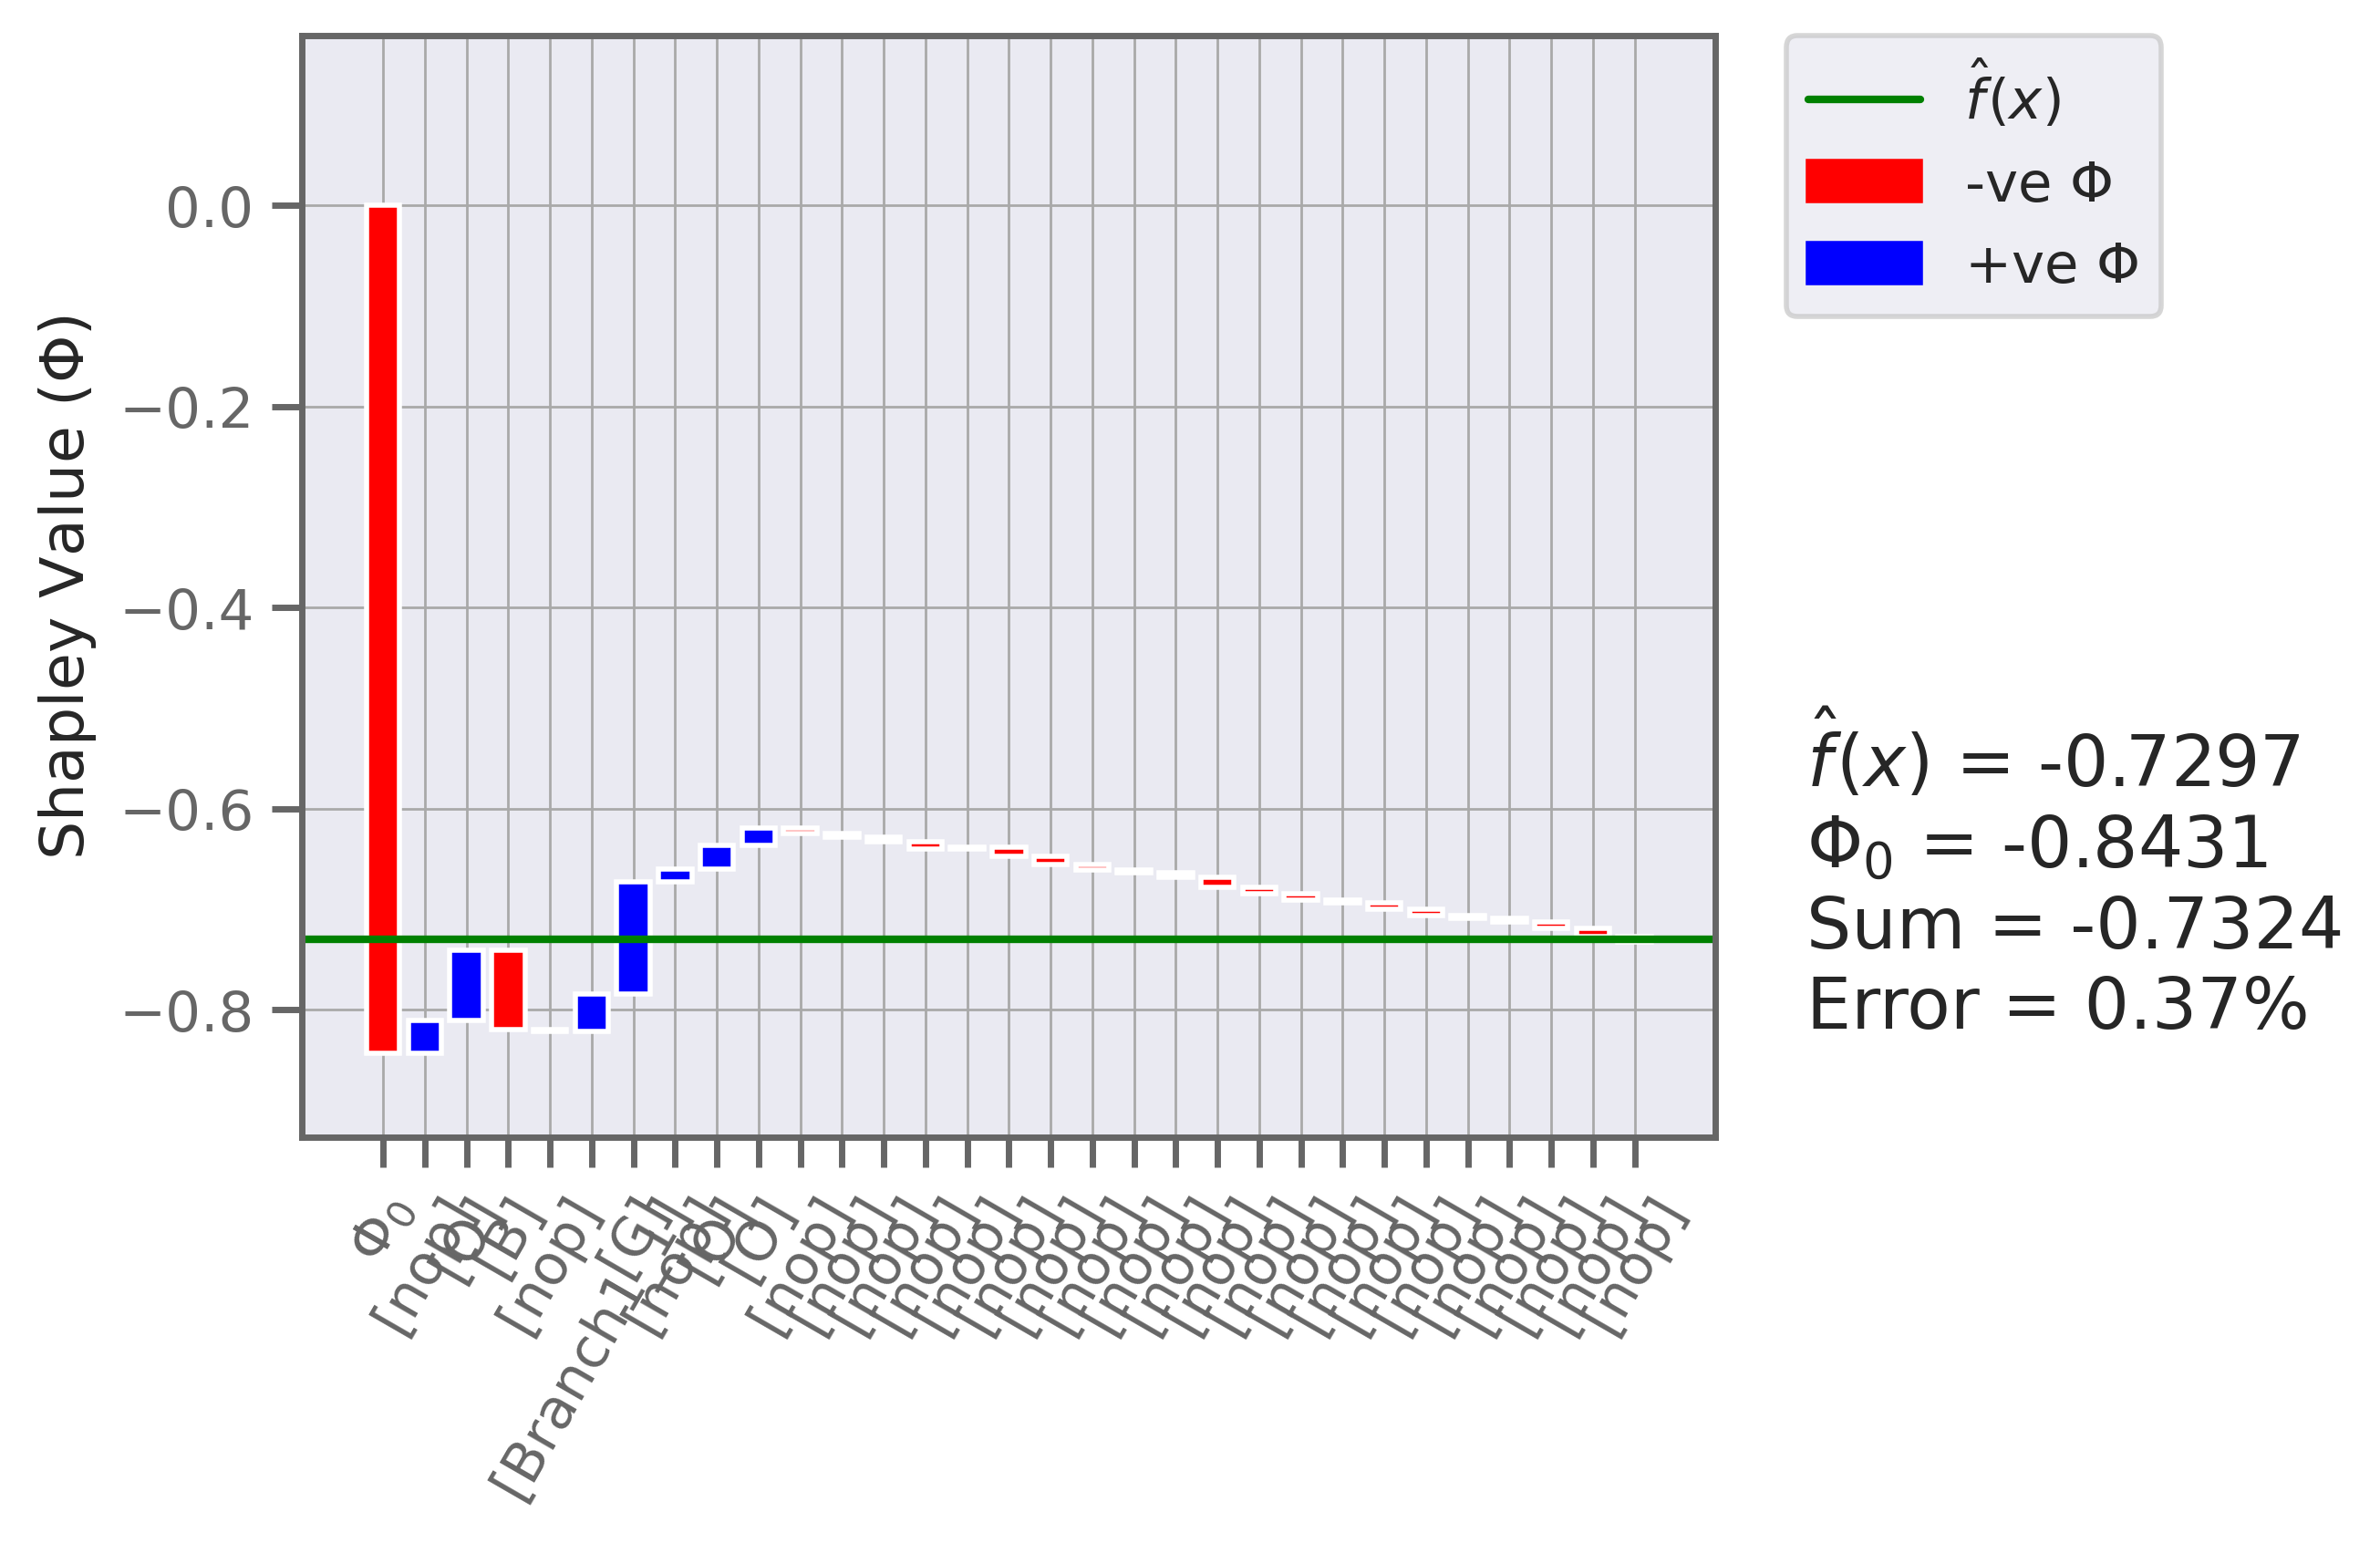

In [98]:
instance = '[nop][O][B][nop][Branch1_1][C][nop][O][O][nop]' + '[nop]'*20
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=2)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=False, dpi=400)

instance:  [nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][O][B][nop][Branch1_1][C][nop][O][O][nop]
instance ints:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 58, 0, 66, 78, 0, 162, 162, 0]
instance len:  30

 Train Sampling + Shuffle
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 58, 0, 66, 78, 0, 162, 162, 0]
30
(2000, 30)
shapley values:  [0.030008872985839843, 0.035758956909179684, 0.03664442443847656, 0.02921181297302246, 0.03641312789916992, 0.03595219421386719, 0.045398757934570315, 0.03823155212402344, 0.04116049194335938, 0.0319092788696289, 0.0355389404296875, 0.04073379516601563, 0.028834014892578124, 0.029566566467285157, 0.03119273376464844, 0.04280580139160156, 0.03174449348449707, 0.03710259246826172, 0.037930156707763674, 0.03191964340209961, 0.03168224334716797, 0.06729178619384765, -0.08110444641113282, -0.007203251838684082, 0.038919776916503904, 0.10949661254882

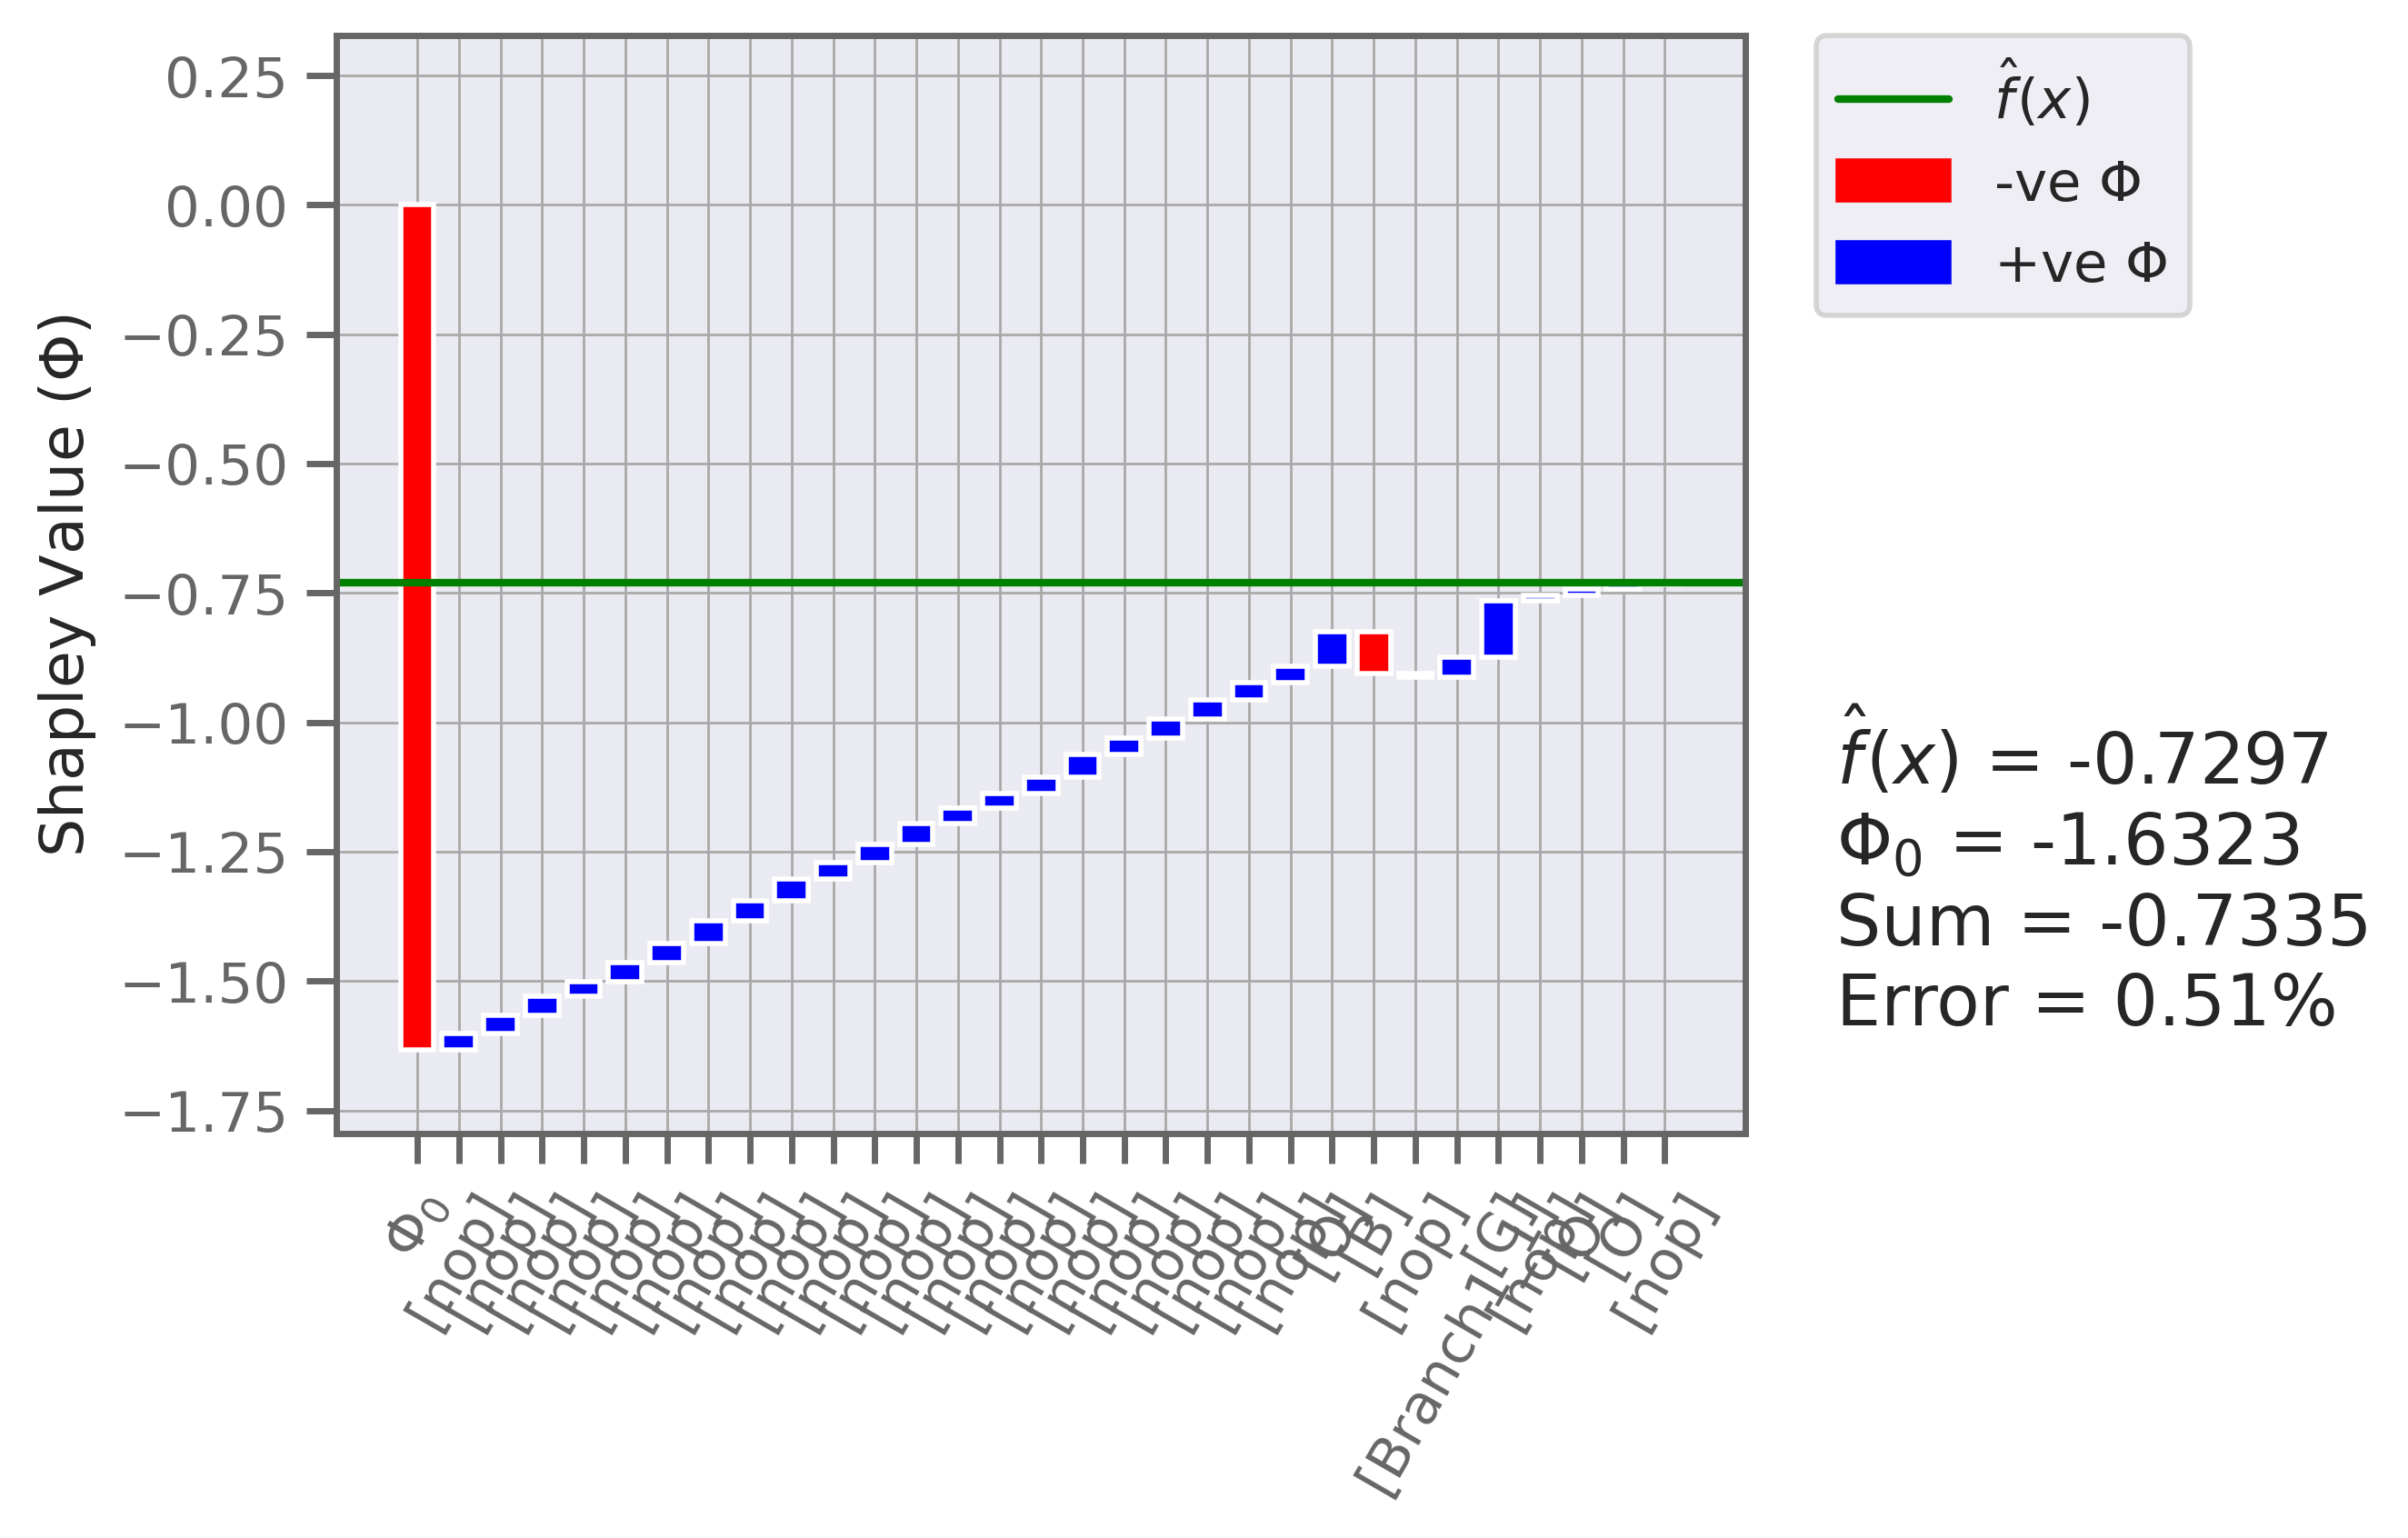

In [99]:
instance = '[nop]'*20 + '[nop][O][B][nop][Branch1_1][C][nop][O][O][nop]'
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=2)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=False, dpi=400)

instance:  [nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][O][B][nop][Branch1_1][C][nop][O][O][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
instance ints:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 58, 0, 66, 78, 0, 162, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
instance len:  50

 Train Sampling + Shuffle
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 58, 0, 66, 78, 0, 162, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50
(2000, 50)
shapley values:  [0.02059090995788574, 0.022867130279541015, 0.013635358810424804, 0.011508089065551758, 0.018639808654785157, 0.02304743194580078, 0.016276067733764648, 0.019734718322753905, 0.017214265823364258, 0.024364128112792968, 0.02571435737609863, 0.0249605712890625, 0.020793697357177735, 0.01620581817626953, 0.017168292999267577, 0.016

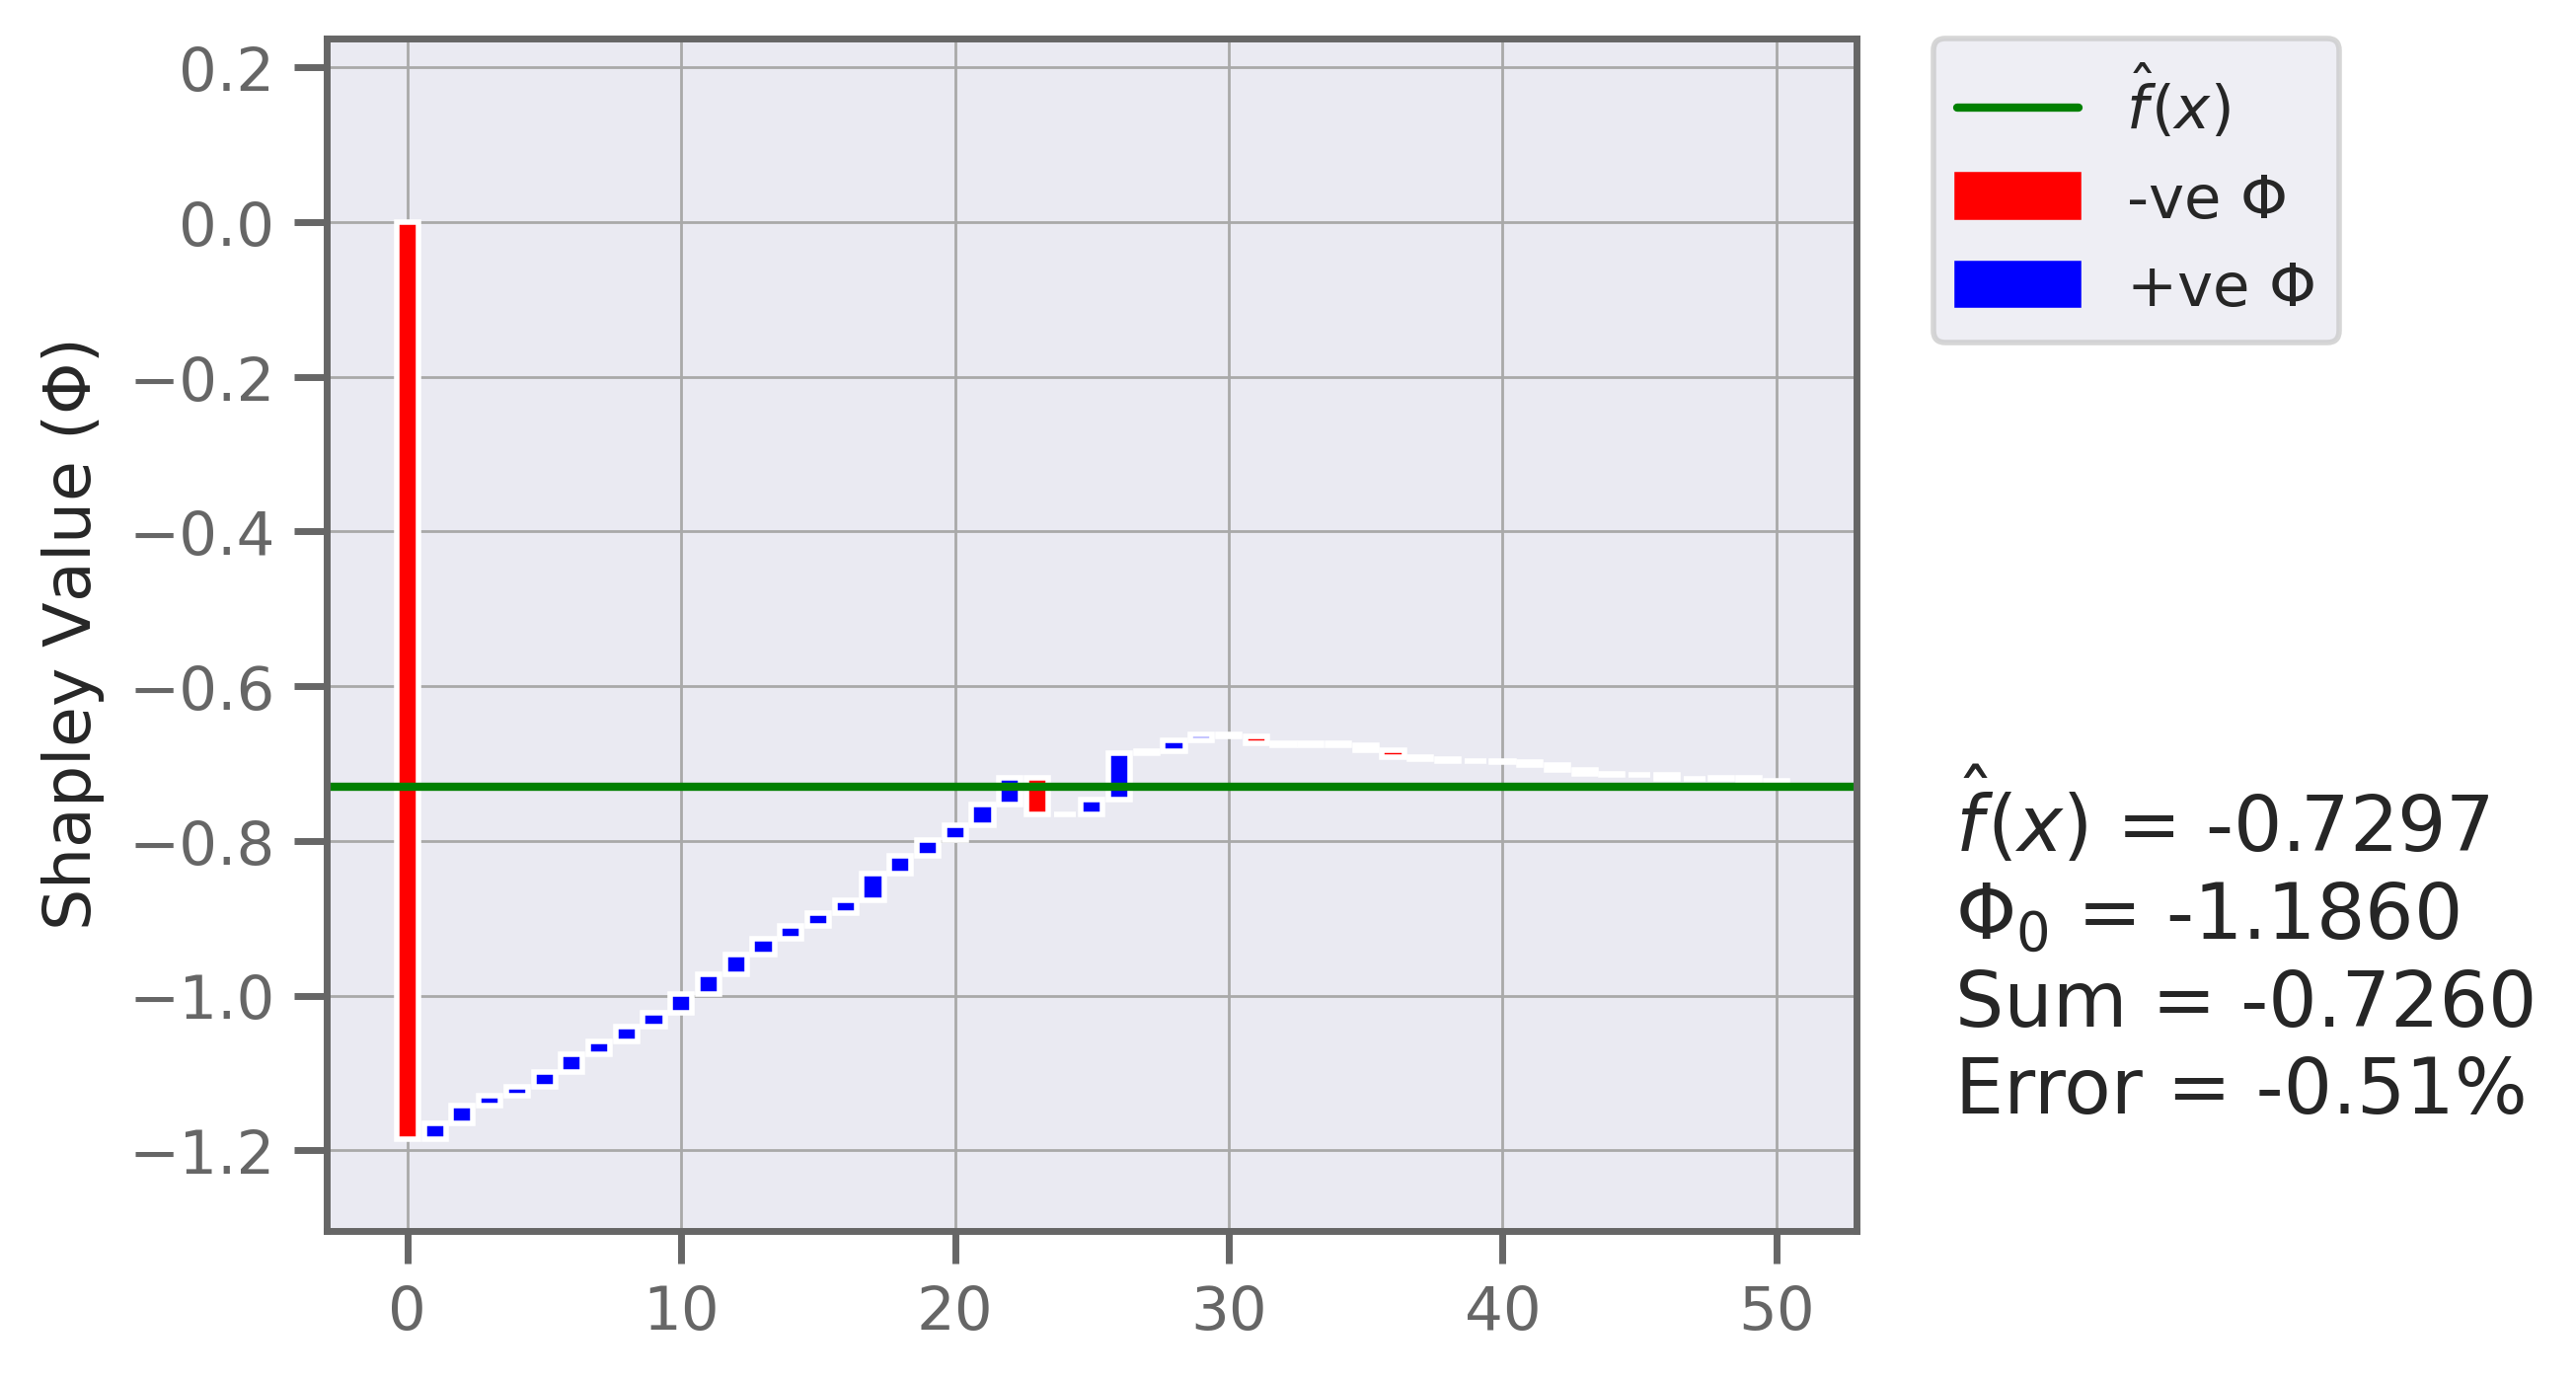

In [100]:
instance = '[nop]'*20 + '[nop][O][B][nop][Branch1_1][C][nop][O][O][nop]' + '[nop]'*20
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=2)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=False, doXLabel=False, dpi=400)

In [101]:
train_samples.shape

(7986, 615)

In [102]:
'''
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples, force_len=train_samples.shape[1])
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doGrid=False, doXLabel=False, dpi=400)
'''

'\ninstance = selfies_list[2164]\ninstance_ints = selfies2ints(instance)\ninstance_len = len(instance_ints)\n\nsteps = 2000\n\nprint("instance: ",instance)\nprint("instance ints: ",instance_ints)\nprint("instance len: ",instance_len)\nprint()\n\n\nlabel =  np.reshape(model.predict([instance_ints]), (-1))[0]\nprint(" Train Sampling + Shuffle")\nshap_val, sample_mean, sample_std = get_shap_vals(instance, \'train\', steps, model, shuffle=True, train_data = train_samples, force_len=train_samples.shape[1])\nprint("shapley values: ", shap_val)\nprint("Sum SV: ", np.sum(shap_val))\nprint("Expectation Value: ", sample_mean," +- ",sample_std)\nfull_sum = np.sum(shap_val) + sample_mean\nprint("Full Sum: ", full_sum)\nprint("f(s): ", label)\nprint("%err: ", (label-full_sum)*100/label)\nprint()\nbar_plot(instance, shap_val, sample_mean, label, doGrid=False, doXLabel=False, dpi=400)\n'

In [103]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

label =  np.reshape(model.predict([instance_ints]), (-1))[0]

print(" Uniform Sampling + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
print(" Uniform Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
print(" Multinomial + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='freq')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
print(" Multinomial + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='freq')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
num_mutations=2
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=2)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
num_mutations=5
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=5)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Uniform Sampling + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.03189453125, -1.141199951171875, 0.41207711791992185, 0.854345947265625, 1.026375, 1.40974609375]
Sum SV:  3.593238739013672
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -2.6595231018066405
f(s):  -0.72970206
%err:  -264.4669878517793

 Uniform Sampling + Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.222525146484375, -1.260387939453125, 0.8142299194335938, 1.622584228515625, 1.23846044921875, 1.54058251953125]
Sum SV:  5.177994323730468
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -1.0747675170898443
f(s):  -0.72970206
%err:  -47.28854181735585

 Multinomial + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [0.5395133666992188, -2.62590869140625, 0.14865313720703124, -0.12448825073242188, 0.4879391479492188, 0.7138414916992187]
Sum SV:  

instance:  [O][=Siexpl][Branch1_1][C][O-expl][O-expl].[O][=Siexpl][Branch1_1][C][O-expl][O-expl].[Al+3expl].[Na+expl]
instance ints:  [162, 35, 66, 78, 160, 160, 162, 35, 66, 78, 160, 160, 49, 150]
instance len:  14

 Train Sampling + Shuffle
[162, 35, 66, 78, 160, 160, 162, 35, 66, 78, 160, 160, 49, 150]
14
(2000, 14)
shapley values:  [0.05486033630371094, -0.14632914733886718, -0.0015692622661590576, 0.03226947784423828, 0.026263776779174804, 0.004172303199768066, 0.022150169372558592, -0.13790469360351562, -0.013992258071899414, 0.020105783462524413, 0.04201017761230469, 0.035295883178710935, -0.17622981262207033, 0.48514605712890624]
Sum SV:  0.2462487909793854
Expectation Value:  -4.6051407  +-  1.5124037
Full Sum:  -4.358891895055771
f(s):  -4.3570647
%err:  -0.04193582613573381


[-4.6051407, 0.05486033630371094, -0.14632914733886718, -0.0015692622661590576, 0.03226947784423828, 0.026263776779174804, 0.004172303199768066, 0.022150169372558592, -0.13790469360351562, -0.0139922580

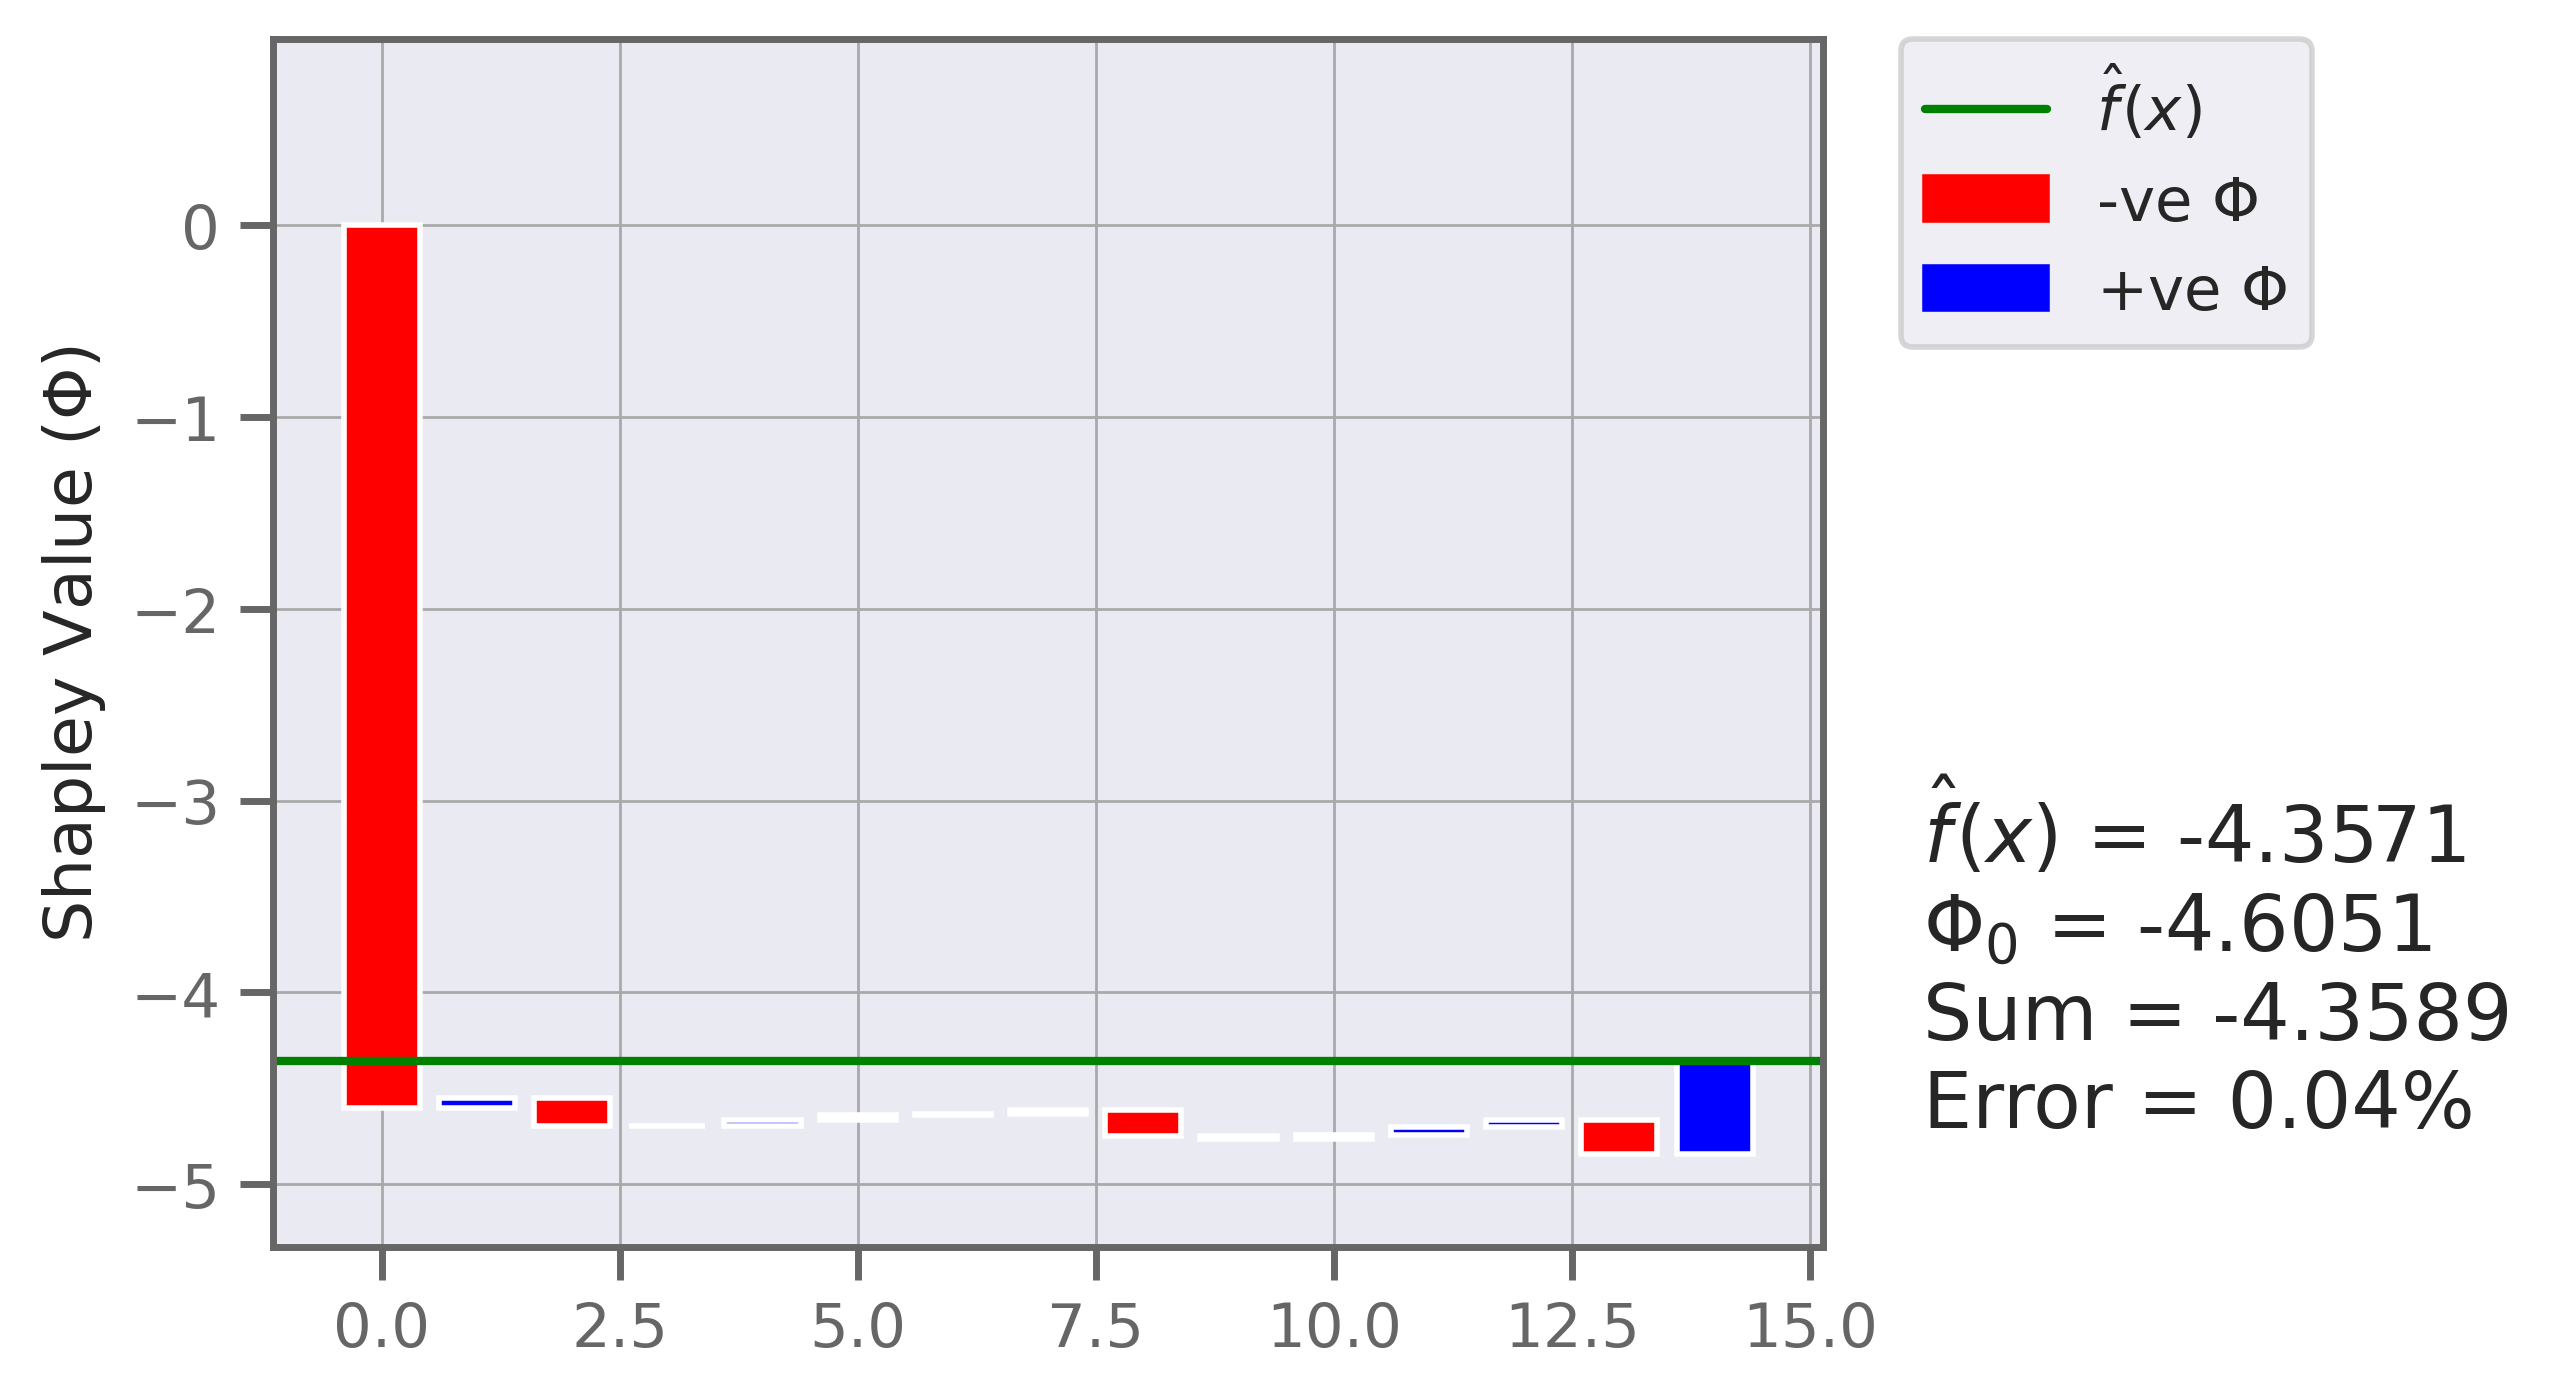

In [104]:
instance = selfies_list[22]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=2)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=False, doXLabel=False, dpi=400)

instance:  [C][C][C][C][C][C][Branch1_1][Branch2_1][C][C][C][Branch1_2][C][=O][O][C][Ring1][Branch2_3]
instance ints:  [78, 78, 78, 78, 78, 78, 66, 69, 78, 78, 78, 67, 78, 27, 162, 78, 178, 71]
instance len:  18

 Uniform Sampling + Shuffle
[78, 78, 78, 78, 78, 78, 66, 69, 78, 78, 78, 67, 78, 27, 162, 78, 178, 71]
18
(2000, 18)
shapley values:  [-0.09047810363769532, -0.11861955261230468, -0.14321614074707031, -0.11780645751953125, -0.08382647705078125, -0.07473269653320312, 0.07863784027099609, 0.09127417755126953, -0.04892626190185547, -0.0504588623046875, -0.014147782325744629, 0.14485357666015625, 0.16275244140625, 0.11304635620117187, 0.06426287078857422, 0.045873573303222656, 0.03887242126464844, 0.10289556121826172]
Sum SV:  0.1002564840316773
Expectation Value:  -2.2004693  +-  1.1556144
Full Sum:  -2.1002127714157104
f(s):  -2.1030397
%err:  0.1344230470112223


[-2.2004693, -0.09047810363769532, -0.11861955261230468, -0.14321614074707031, -0.11780645751953125, -0.083826477050

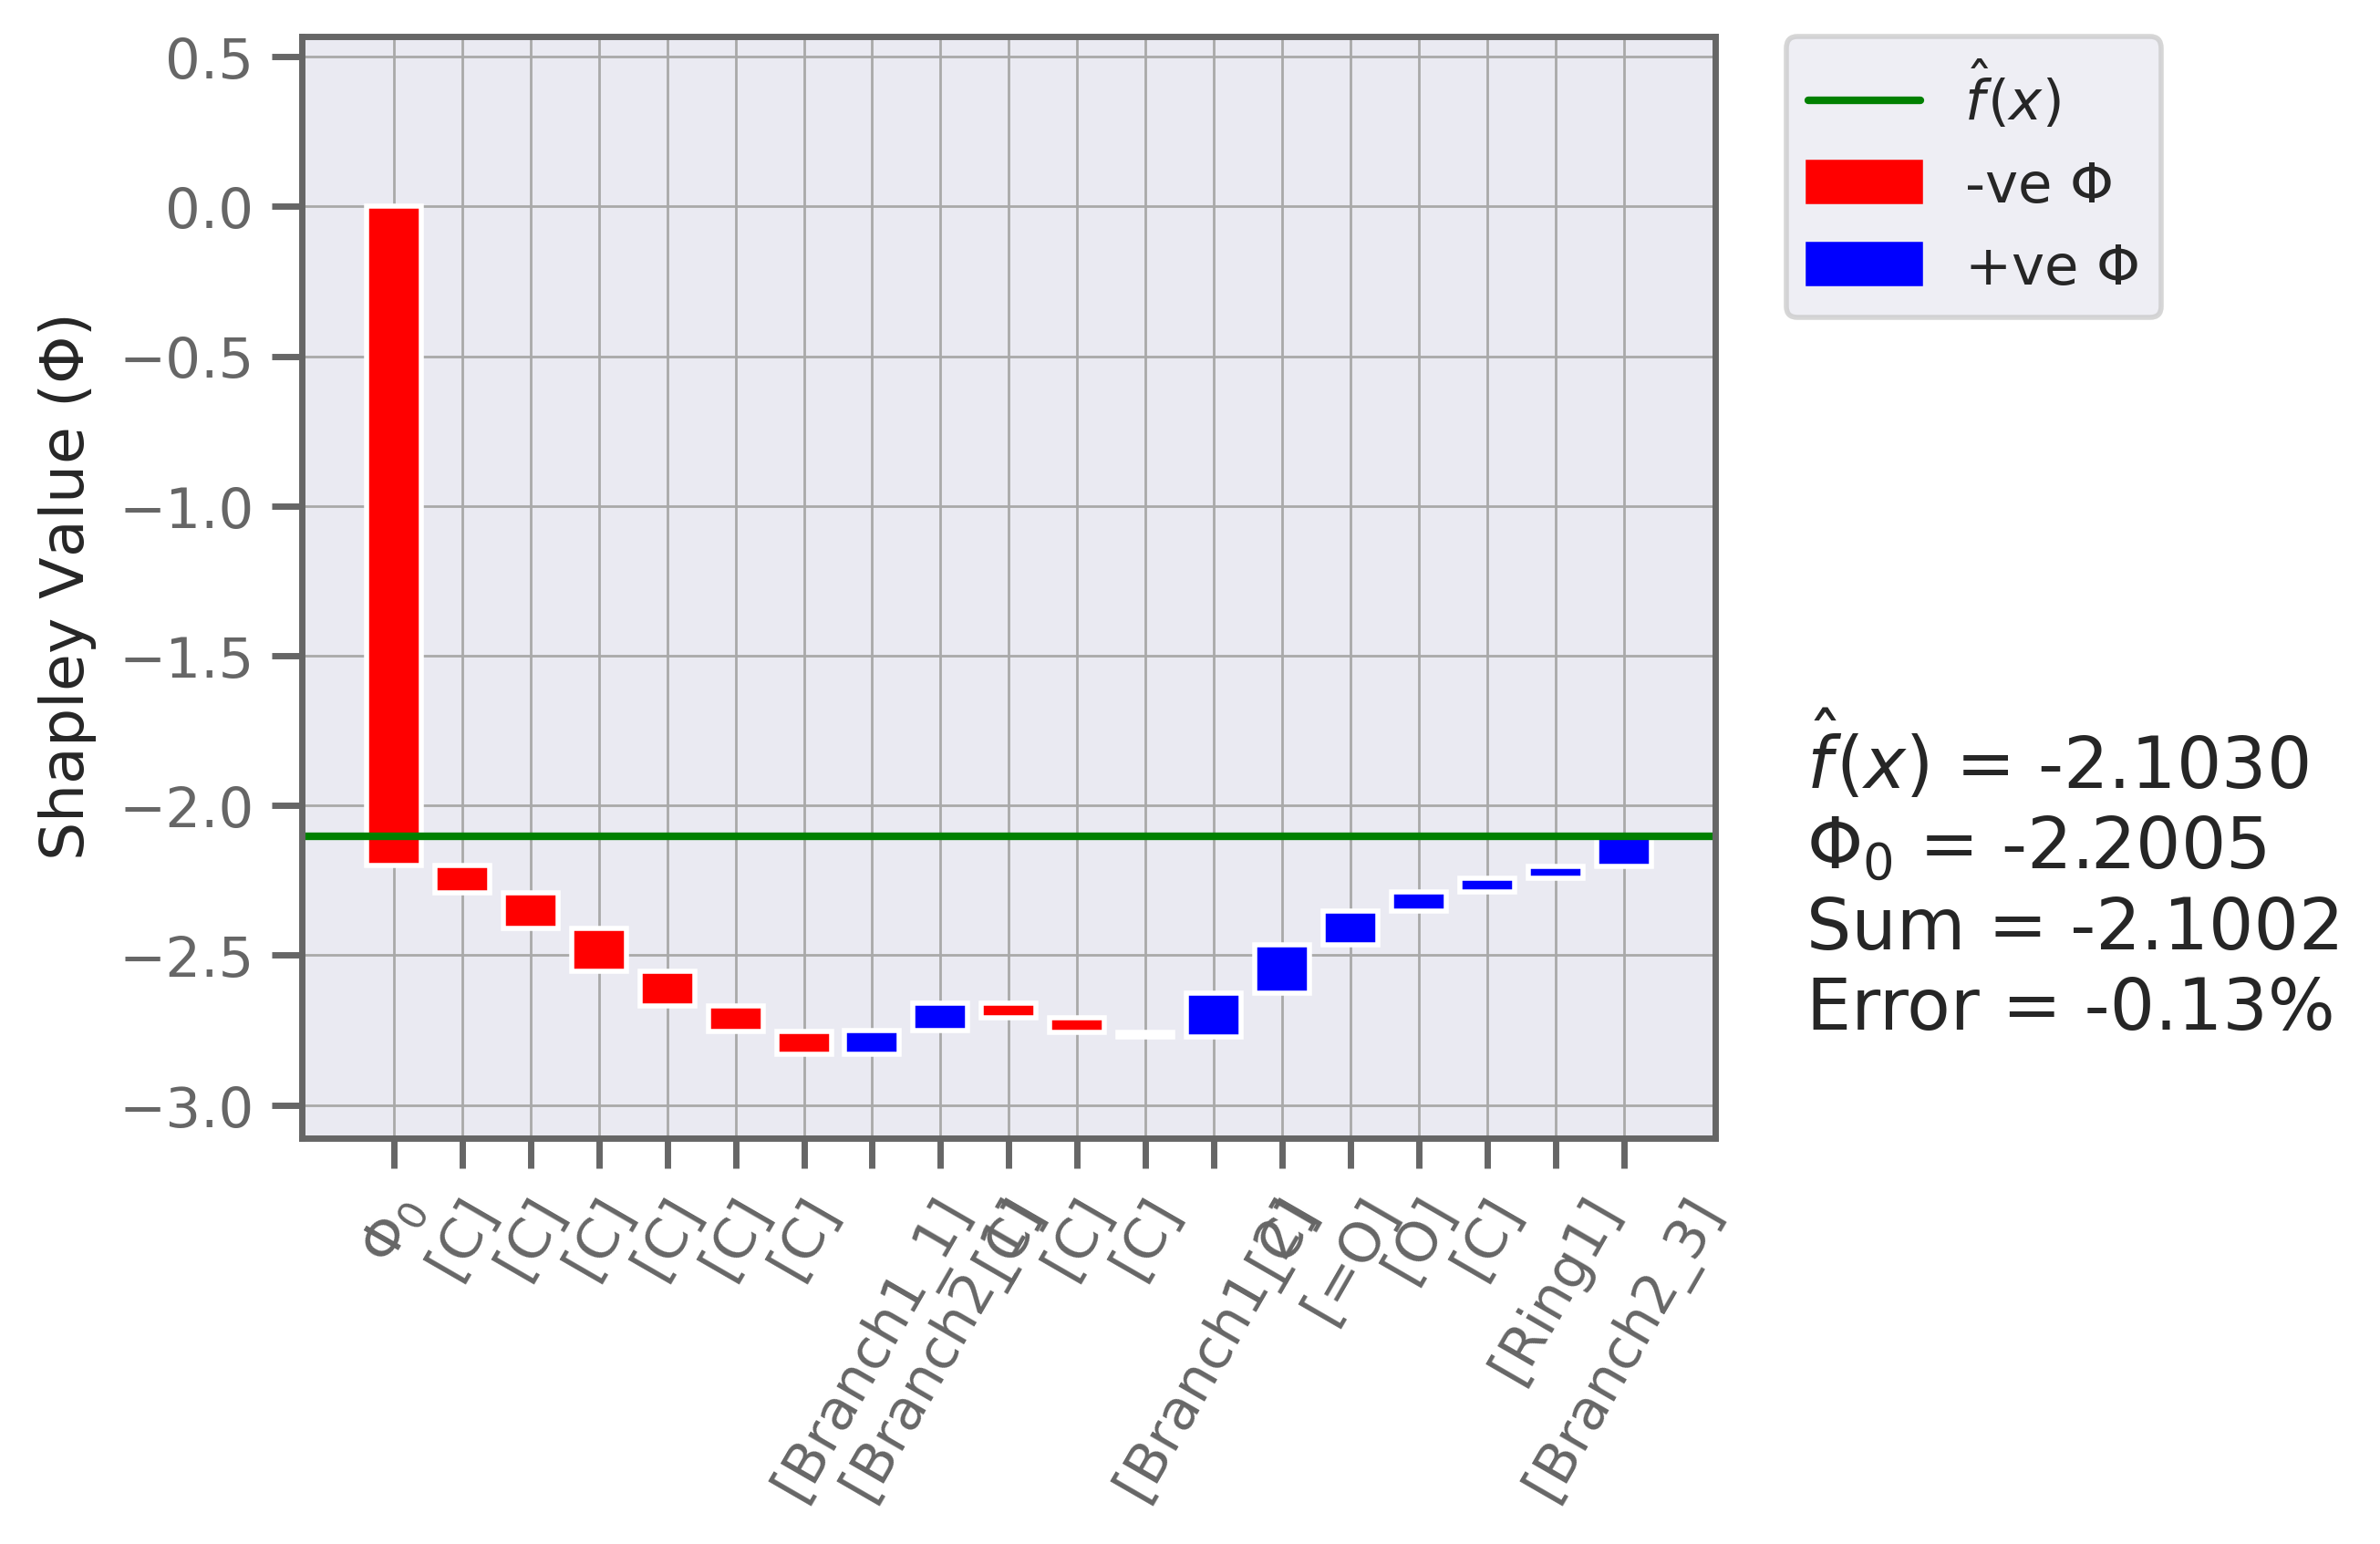

In [105]:
instance = selfies_list[6]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Uniform Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=5)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=False)

instance:  [C][C][C][C][C][C][Branch1_1][Branch2_1][C][C][C][Branch1_2][C][=O][O][C][Ring1][Branch2_3][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
instance ints:  [78, 78, 78, 78, 78, 78, 66, 69, 78, 78, 78, 67, 78, 27, 162, 78, 178, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
instance len:  38

 Uniform Sampling + Shuffle
[78, 78, 78, 78, 78, 78, 66, 69, 78, 78, 78, 67, 78, 27, 162, 78, 178, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
38
(2000, 38)
shapley values:  [-0.0464626235961914, -0.09658202362060547, -0.08150606536865235, -0.07177603912353515, -0.06556448364257812, -0.05818526458740234, 0.04689725112915039, 0.03864158630371094, -0.04409281158447265, -0.02442660903930664, -0.01355364990234375, 0.08729713439941406, 0.09087307739257812, 0.07573736572265626, 0.027809627532958986, 0.010674325942993165, 0.02899903106689453, 0.04643125152587891, 0.03678437042236328, 0.04791241455078125, 0.

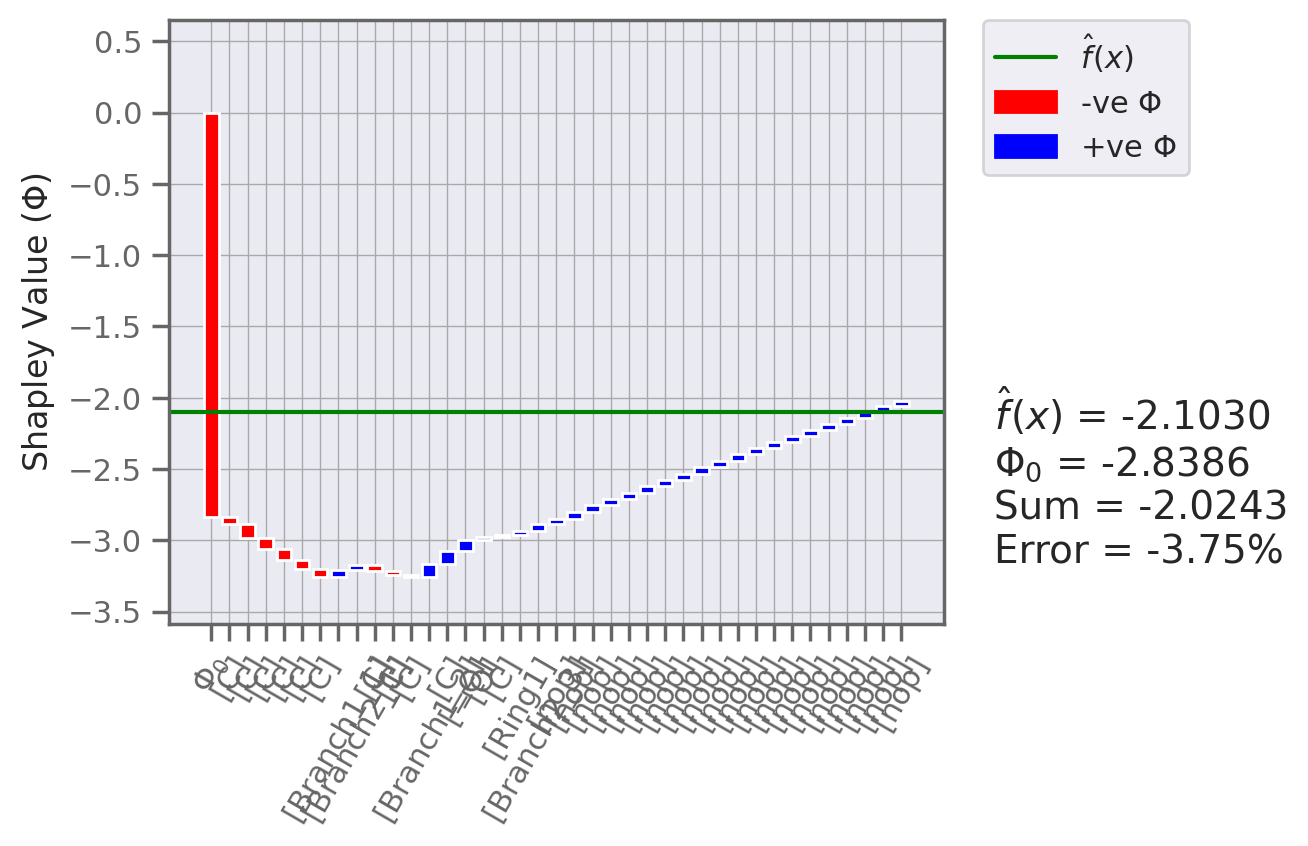

In [106]:
instance = selfies_list[6] + '[nop]'*20
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Uniform Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=5)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=False)

instance:  [C][C][C][C][C][C][Branch1_1][Branch2_1][C][C][C][Branch1_2][C][=O][O][C][Ring1][Branch2_3]
instance ints:  [78, 78, 78, 78, 78, 78, 66, 69, 78, 78, 78, 67, 78, 27, 162, 78, 178, 71]
instance len:  18

 Uniform Sampling + Shuffle
[78, 78, 78, 78, 78, 78, 66, 69, 78, 78, 78, 67, 78, 27, 162, 78, 178, 71]
18
(2000, 18)
shapley values:  [-0.10643809509277344, -0.14465074157714844, -0.11716200256347656, -0.11813845825195313, -0.09185550689697265, -0.08083531188964843, 0.07475379180908204, 0.09159815979003906, -0.05711412048339844, -0.03796305847167969, -0.010377660751342773, 0.17262884521484376, 0.1634559326171875, 0.11560646057128907, 0.05920382308959961, 0.04322531127929687, 0.020383819580078125, 0.0900757293701172]
Sum SV:  0.06639691734313956
Expectation Value:  -2.1635156  +-  1.1534176
Full Sum:  -2.0971186504364017
f(s):  -2.1030397
%err:  0.2815491767855519


[-2.1635156, -0.10643809509277344, -0.14465074157714844, -0.11716200256347656, -0.11813845825195313, -0.091855506

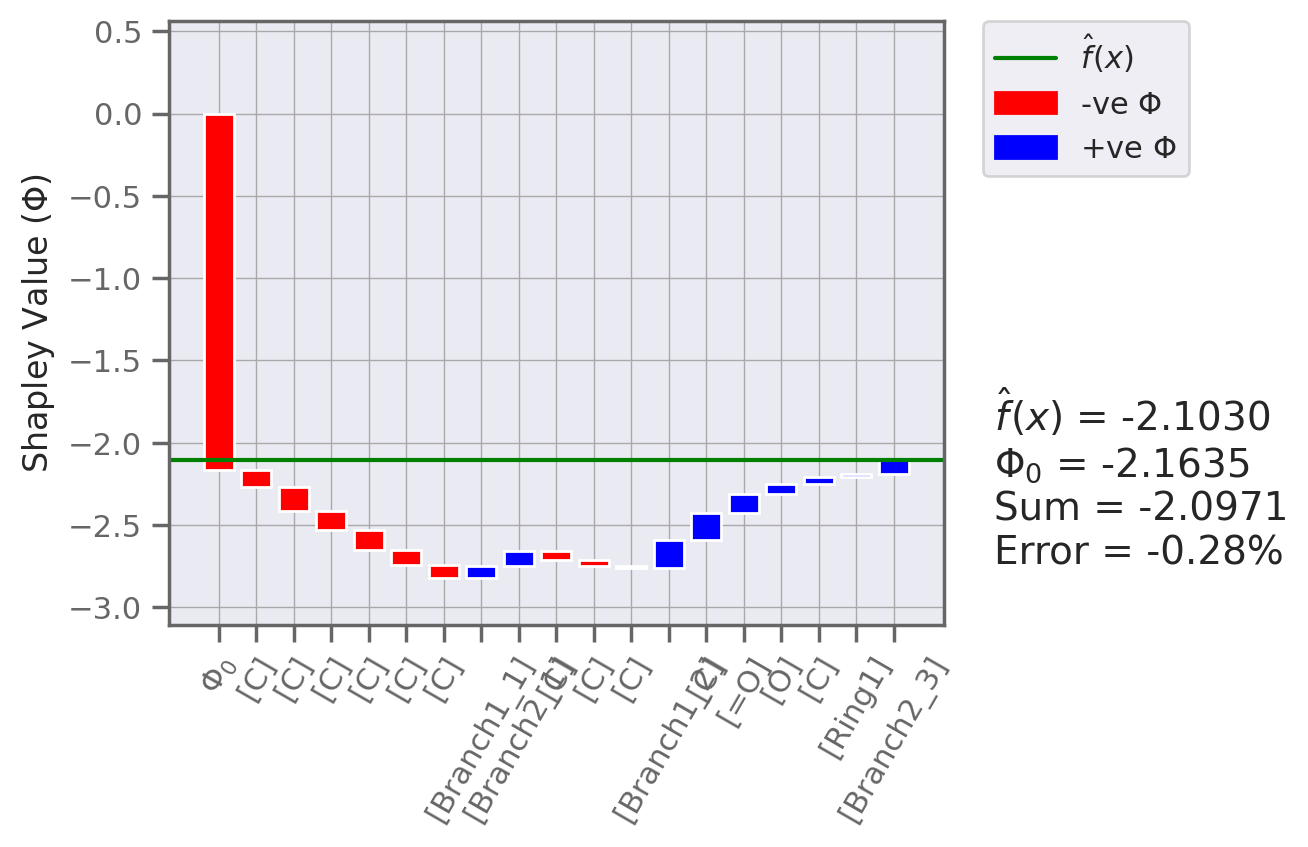

In [107]:
instance = '[C][C][C][C][C][C][Branch1_1][Branch2_1][C][C][C][Branch1_2][C][=O][O][C][Ring1][Branch2_3]'
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Uniform Sampling + Shuffle")
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples)
#shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=5)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doYLabel=False)

instance:  [C][C][C][=C][C][Branch1_2][C][=O][C][=C][Ring1][Branch1_3][C][C][C][C][Ring1][O][C][Branch1_1][C][O][C][C][Branch1_1][C][C][C][Ring1][Branch2_1][C][C][Branch1_1][C][O][C][Ring1][Branch1_3][Branch1_1][C][O][C][Branch1_2][C][=O][C][O]
instance ints:  [78, 78, 78, 9, 78, 67, 78, 27, 78, 9, 178, 68, 78, 78, 78, 78, 178, 162, 78, 66, 78, 162, 78, 78, 66, 78, 78, 78, 178, 69, 78, 78, 66, 78, 162, 78, 178, 68, 66, 78, 162, 78, 67, 78, 27, 78, 162]
instance len:  47

 Uniform Sampling + Shuffle
[78, 78, 78, 9, 78, 67, 78, 27, 78, 9, 178, 68, 78, 78, 78, 78, 178, 162, 78, 66, 78, 162, 78, 78, 66, 78, 78, 78, 178, 69, 78, 78, 66, 78, 162, 78, 178, 68, 66, 78, 162, 78, 67, 78, 27, 78, 162]
47
(2000, 47)
shapley values:  [-0.04873522186279297, -0.03898162841796875, -0.06436856079101562, -0.158918701171875, -0.02810256004333496, -0.041994102478027345, 0.11226752471923829, 0.02291975784301758, 0.05467348480224609, -0.11251581573486329, 0.02521357727050781, 0.008021445274353027, 0.0635559

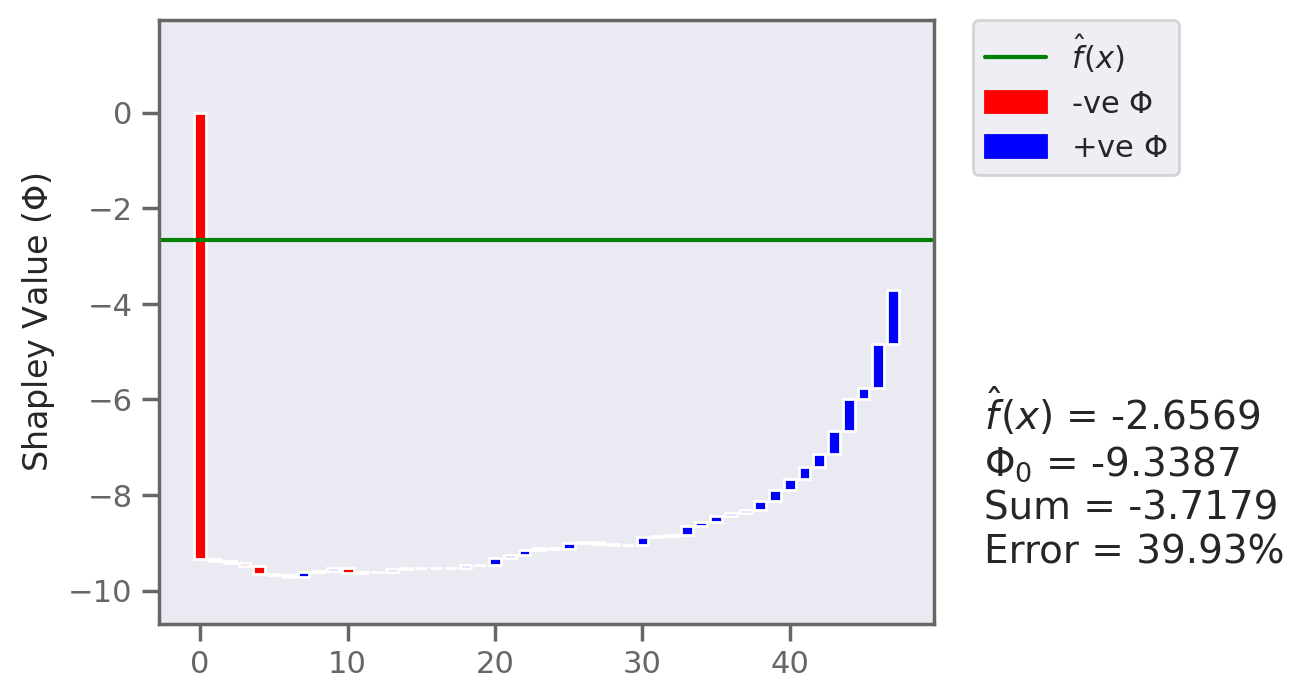

In [108]:
instance = selfies_list[7]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Uniform Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doGrid=False, doXLabel=False)

instance:  [C][=C][Branch1_1][C][C][C][=C][C][=C][C][Branch1_1][Branch1_2][C][Branch1_2][C][=C][C][=C][Ring1][Branch2_2]
instance ints:  [78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
instance len:  20

 Uniform Sampling + Shuffle
[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
20
(2000, 20)
shapley values:  [0.12418580627441406, -0.257143310546875, 0.3271393127441406, 0.1360718536376953, 0.05379579925537109, 0.09131201934814454, -0.07486680603027343, 0.1162493896484375, -0.06665006256103516, 0.10244691467285157, 0.25954876708984376, 0.369325927734375, 0.30221722412109375, 0.44014907836914063, 0.4267442626953125, 0.1473589630126953, 0.6799891967773437, 0.37392535400390625, 0.6217129516601563, 0.672056640625]
Sum SV:  4.845569282531738
Expectation Value:  -8.66019  +-  3.192405
Full Sum:  -3.8146203460693364
f(s):  -3.8373113
%err:  0.5913234606100584


[-8.66019, 0.12418580627441406, -0.257143310546875, 0.3271393127441406, 0.13

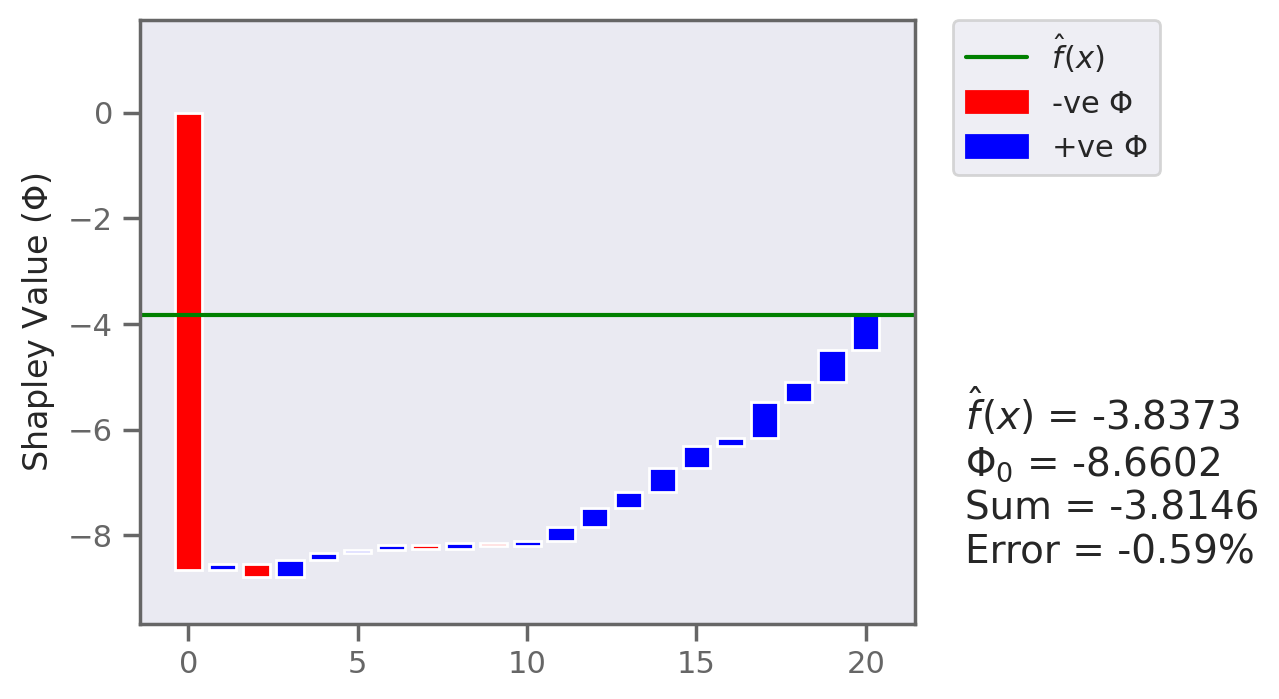

In [109]:
instance = selfies_list[37]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Uniform Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doGrid=False, doXLabel=False)

instance:  [O][O]
instance ints:  [162, 162]
instance len:  2

 Uniform Sampling + Shuffle
[162, 162]
2
(2000, 2)
shapley values:  [1.925860595703125, 2.2120146484375]
Sum SV:  4.137875244140625
Expectation Value:  -3.9962037  +-  3.5199625
Full Sum:  0.14167158317565942
f(s):  0.13981664
%err:  -1.3266956952495064


[-3.9962037, 1.925860595703125, 2.2120146484375]
[0, -3.996203660964966, -2.0703430652618406]
['r', 'b', 'b']
[0 1 2]
3   3


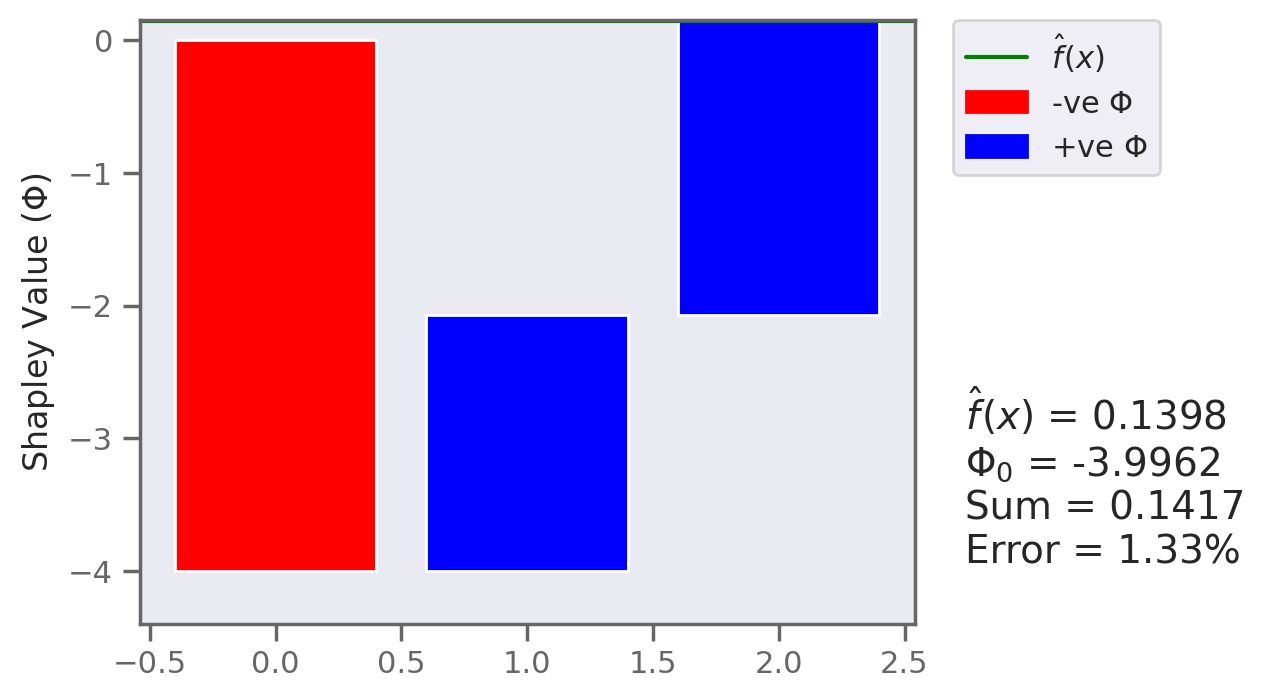

In [110]:
instance = selfies_list[1111]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Uniform Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
bar_plot(instance, shap_val, sample_mean, label, doGrid=False, doXLabel=False)

instance:  [C][=C][Branch1_1][C][C][C][=C][C][=C][C][Branch1_1][Branch1_2][C][Branch1_2][C][=C][C][=C][Ring1][Branch2_2]
instance ints:  [78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
instance len:  20

[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
20
(2, 20)
[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
20
(5, 20)
[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
20
(10, 20)
[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
20
(20, 20)
[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
20
(50, 20)
[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
20
(100, 20)
[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
20
(250, 20)
[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 78, 9, 78, 9, 178, 70]
20
(500, 20)
[78, 9, 66, 78, 78, 78, 9, 78, 9, 78, 66, 67, 78, 67, 

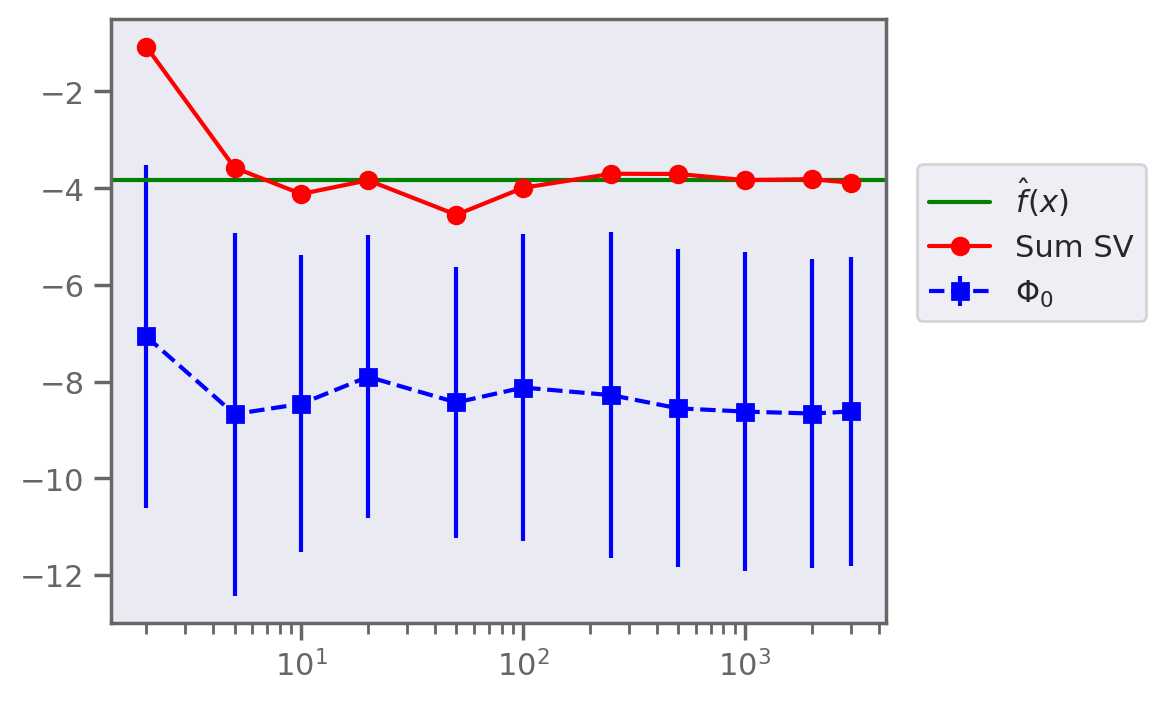

In [111]:
steps = [2,5,10,20,50,100,250,500,1000,2000,3000]


instance = selfies_list[37]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

ngram = 1
#dist_type = 'uni'

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

avg_data = []
std_data = []

sum_sv_data = []

for s in steps:
    
    shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', s, model, shuffle=True, dist_type='uni')
    avg_data.append(sample_mean)
    std_data.append(sample_std)
    sum_sv_data.append(np.sum(shap_val)+sample_mean)
    
    
    
print('avg_data: \n',avg_data)
print('std_data: \n',std_data)
print('sum_sv_data: \n', sum_sv_data)
print()

label =  np.reshape(model.predict([instance_ints]), (-1))[0]

plt.axhline(y=label,color='green', label='$\hat f(x)$')
plt.errorbar(steps, avg_data, yerr = std_data, fmt='bs--',label='$\Phi_{0}$')
plt.plot(steps, sum_sv_data, 'ro-',label='Sum SV')
plt.xscale('log')
plt.legend(loc=(1.04, 0.5))
#plt.tight_layout()
plt.show()

In [112]:
def line_plot(instance, label, ls_shap_vals, ls_exp_val, ls_specs, ls_label, doGrid=True, doXLabel=True, dpi=200):
    instance_tokens = list(sf.split_selfies(instance))
    inds = np.arange(len(instance_tokens)+1)
    
    assert len(ls_shap_vals)==len(ls_exp_val)==len(ls_specs)
    
    if doGrid: plt.grid(True, linewidth=0.5, color='darkgrey', linestyle='-')
    
    plt.axhline(y=label,color='green', label='$\hat f(x)$')
    
    max_shifts=0
    min_shifts=100000000
    
    for i in range(len(ls_shap_vals)):
        shap_vals = ls_shap_vals[i]
        exp_val = ls_exp_val[i]
        specs = ls_specs[i]
        leg_label = ls_label[i]
        
        shifts = []
        comb_vals = [exp_val]+shap_vals
        shift = 0
        for i in range(len(comb_vals)):
            shift+=comb_vals[i]
            shifts.append(shift)
        #print()
        #print(comb_vals)
        #print(shifts)

        if len(instance_tokens)!=len(shap_vals):
            instance_tokens.extend(['[nop]'] * (len(shap_vals)-len(instance_tokens)))

        #print(len(comb_vals)," ",len(inds))

        plt.plot(inds, shifts, specs, label = leg_label)
        
        if max(shifts)>max_shifts: max_shifts = max(shifts)
        if min(shifts)<min_shifts: min_shifts = min(shifts)

    if doXLabel: plt.xticks(inds, ['$\Phi_{0}$']+instance_tokens)
    
    ymax = max([max_shifts,label])
    ymin = min([min_shifts,label])
    if ymax>0: ymax*=1.1
    elif ymax<0: ymax*=0.9
    elif ymax==0: ymax=0.1*abs(ymin)
    
    if ymin>0: ymax*=0.9
    elif ymin<0: ymin*=1.1
    elif ymin==0: ymin=-0.1*abs(ymax)
    plt.ylim([ymin, ymax])
    
    plt.ylabel('Shapley Value ($\Phi$)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.figure(figsize=(1,1))
    plt.rcParams['figure.figsize'] = [5, 4]
    plt.rcParams['figure.dpi'] = dpi
    return plt

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Uniform Sampling + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.03189453125, -1.141199951171875, 0.41207711791992185, 0.854345947265625, 1.026375, 1.40974609375]
Sum SV:  3.593238739013672
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -2.6595231018066405
f(s):  -0.72970206
%err:  -264.4669878517793

 Uniform Sampling + Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.222525146484375, -1.260387939453125, 0.8142299194335938, 1.622584228515625, 1.23846044921875, 1.54058251953125]
Sum SV:  5.177994323730468
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -1.0747675170898443
f(s):  -0.72970206
%err:  -47.28854181735585



<module 'matplotlib.pyplot' from '/home/navneeth/anaconda3/envs/exmol/lib/python3.8/site-packages/matplotlib/pyplot.py'>

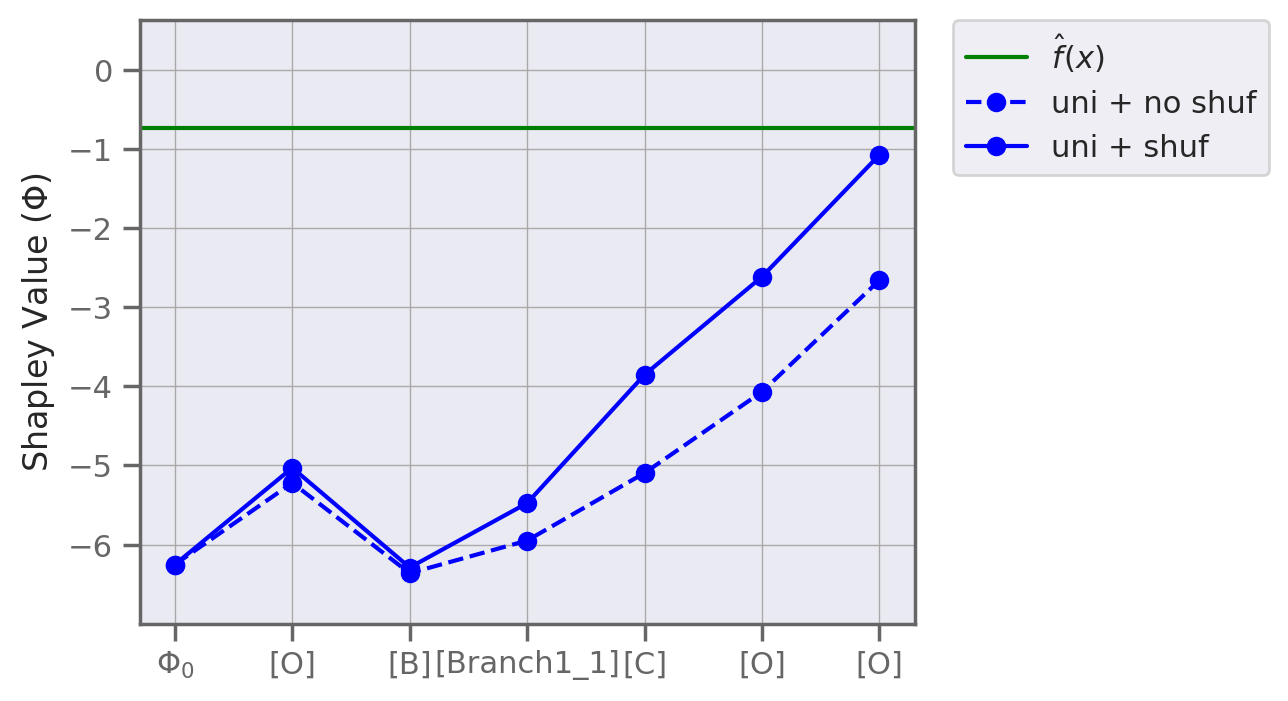

In [113]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

ls_shap_vals = []
ls_exp_val = []
ls_specs = []
ls_label = []

label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Uniform Sampling + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo--')
ls_label.append("uni + no shuf")
print(" Uniform Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo-')
ls_label.append("uni + shuf")
line_plot(instance, label, ls_shap_vals, ls_exp_val, ls_specs, ls_label, dpi=400)

In [144]:
def group_bar_plot(instance, label, ls_shap_vals, ls_exp_val, ls_specs, doGrid=True, doXLabel=True, dpi=200):
    instance_tokens = list(sf.split_selfies(instance))
    inds = np.arange(len(instance_tokens)+1)
    
    assert len(ls_shap_vals)==len(ls_exp_val)==len(ls_specs)
    
    if doGrid: plt.grid(True, linewidth=0.5, color='darkgrey', linestyle='-')
    
    n = len(ls_shap_vals)
    
    ymax=0
    ymin=10000000
    
    for i in range(n):
        shap_vals = ls_shap_vals[i]
        exp_val = ls_exp_val[i]
        specs = ls_specs[i]
        leg_label = ls_label[i]
        
        comb_vals = [exp_val]+shap_vals
        ymax = max(comb_vals) if ymax<max(comb_vals) else ymax
        ymin = min(comb_vals) if ymin>min(comb_vals) else ymin
        
        plt.bar(inds- 1/(n) + i/(n+1), comb_vals, width=1/(n+1), color=specs, label = leg_label)
        

    if doXLabel: plt.xticks(inds, ['$\Phi_{0}$']+instance_tokens)
    
    ymax = max(ymax, label)
    ymin = min(ymin, label)
    if ymax>0: ymax*=1.1
    elif ymax<0: ymax*=0.9
    elif ymax==0: ymax=0.1*abs(ymin)
    
    if ymin>0: ymax*=0.9
    elif ymin<0: ymin*=1.1
    elif ymin==0: ymin=-0.1*abs(ymax)
    plt.ylim([ymin, ymax])
    
    print(ymin," ",ymax)
    
    plt.ylabel('Shapley Value ($\Phi$)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.figure(figsize=(1,1))
    plt.rcParams['figure.figsize'] = [5, 4]
    plt.rcParams['figure.dpi'] = dpi
    return plt

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Uniform Sampling + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.03189453125, -1.141199951171875, 0.41207711791992185, 0.854345947265625, 1.026375, 1.40974609375]
Sum SV:  3.593238739013672
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -2.6595231018066405
f(s):  -0.72970206
%err:  -264.4669878517793

 Uniform Sampling + Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.222525146484375, -1.260387939453125, 0.8142299194335938, 1.622584228515625, 1.23846044921875, 1.54058251953125]
Sum SV:  5.177994323730468
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -1.0747675170898443
f(s):  -0.72970206
%err:  -47.28854181735585

 Multinomial + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [0.5395133666992188, -2.62590869140625, 0.14865313720703124, -0.12448825073242188, 0.4879391479492188, 0.7138414916992187]
Sum SV:  

<module 'matplotlib.pyplot' from '/home/navneeth/anaconda3/envs/exmol/lib/python3.8/site-packages/matplotlib/pyplot.py'>

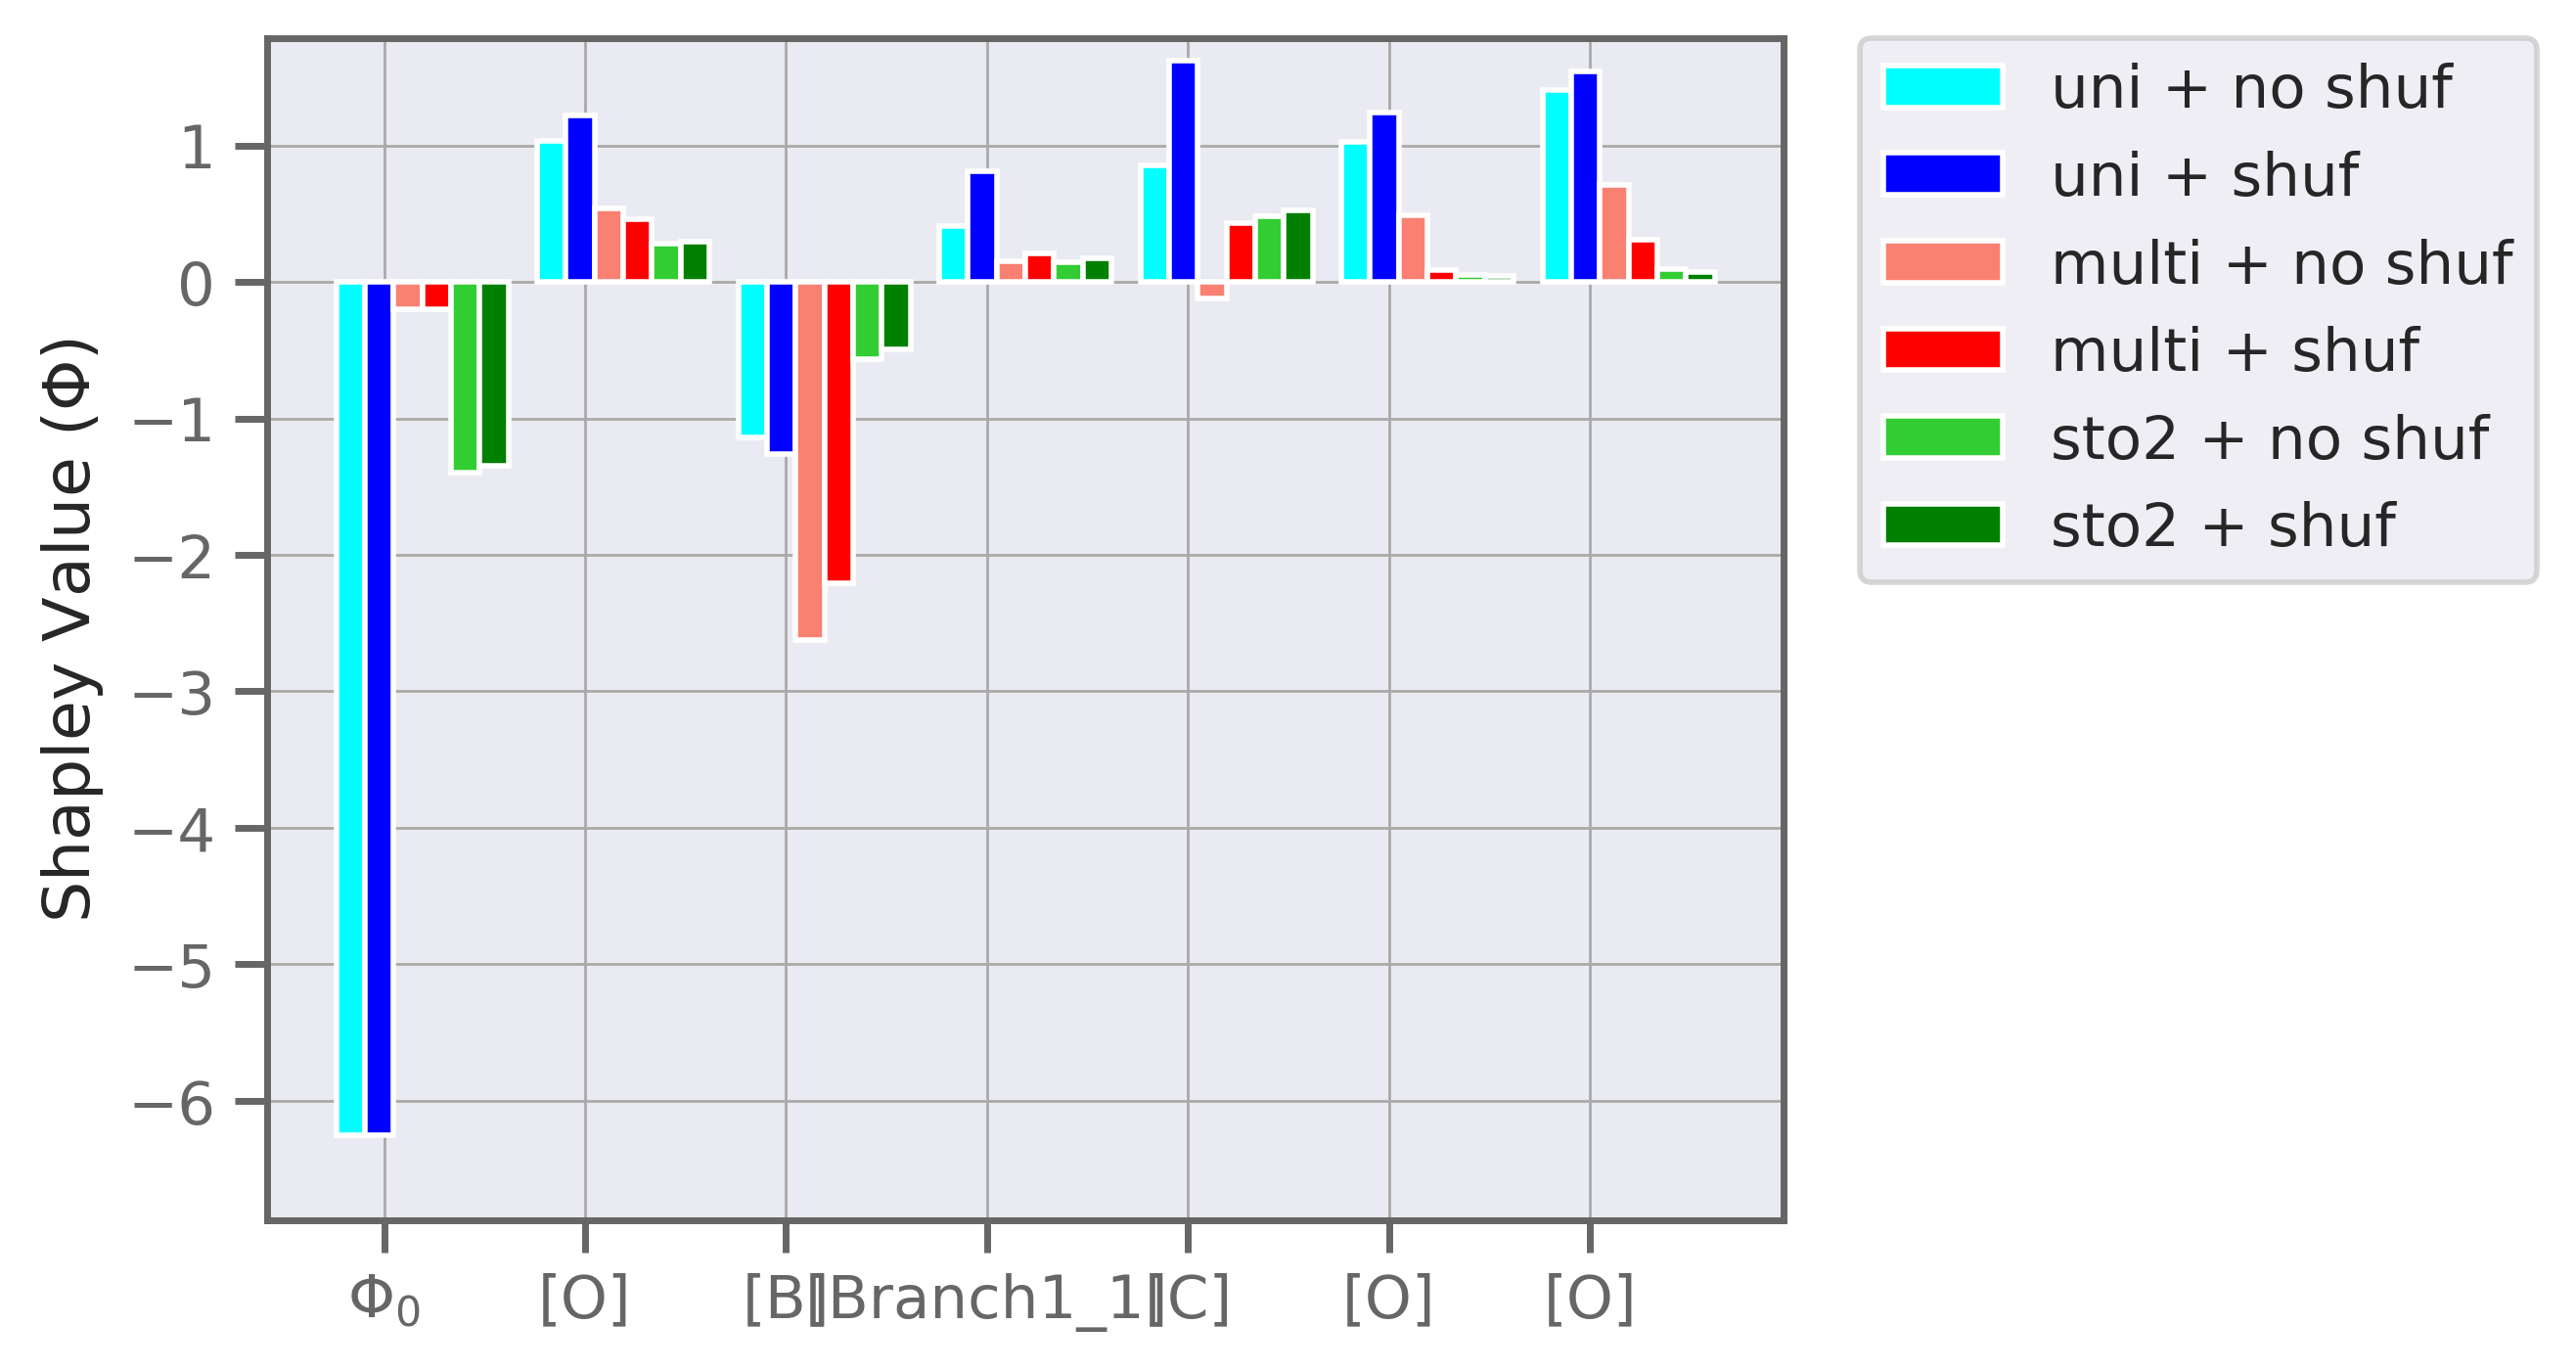

In [145]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

ls_shap_vals = []
ls_exp_val = []
ls_specs = []
ls_label = []

label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Uniform Sampling + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('cyan')
ls_label.append("uni + no shuf")
print(" Uniform Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('blue')
ls_label.append("uni + shuf")


print(" Multinomial + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='freq')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('salmon')
ls_label.append("multi + no shuf")
print(" Multinomial + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='freq')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('red')
ls_label.append("multi + shuf")

num_mutations=2
print(f" Stoned {num_mutations} + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=False, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('limegreen')
ls_label.append("sto2 + no shuf")
num_mutations=2
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('green')
ls_label.append("sto2 + shuf")


group_bar_plot(instance, label, ls_shap_vals, ls_exp_val, ls_specs, dpi=400)

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Uniform Sampling + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.03189453125, -1.141199951171875, 0.41207711791992185, 0.854345947265625, 1.026375, 1.40974609375]
Sum SV:  3.593238739013672
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -2.6595231018066405
f(s):  -0.72970206
%err:  -264.4669878517793

 Uniform Sampling + Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [1.222525146484375, -1.260387939453125, 0.8142299194335938, 1.622584228515625, 1.23846044921875, 1.54058251953125]
Sum SV:  5.177994323730468
Expectation Value:  -6.252762  +-  3.421289
Full Sum:  -1.0747675170898443
f(s):  -0.72970206
%err:  -47.28854181735585

 Multinomial + No Shuffle
[162, 58, 66, 78, 162, 162]
6
(2000, 6)
shapley values:  [0.5395133666992188, -2.62590869140625, 0.14865313720703124, -0.12448825073242188, 0.4879391479492188, 0.7138414916992187]
Sum SV:  

<module 'matplotlib.pyplot' from '/home/navneeth/anaconda3/envs/exmol/lib/python3.8/site-packages/matplotlib/pyplot.py'>

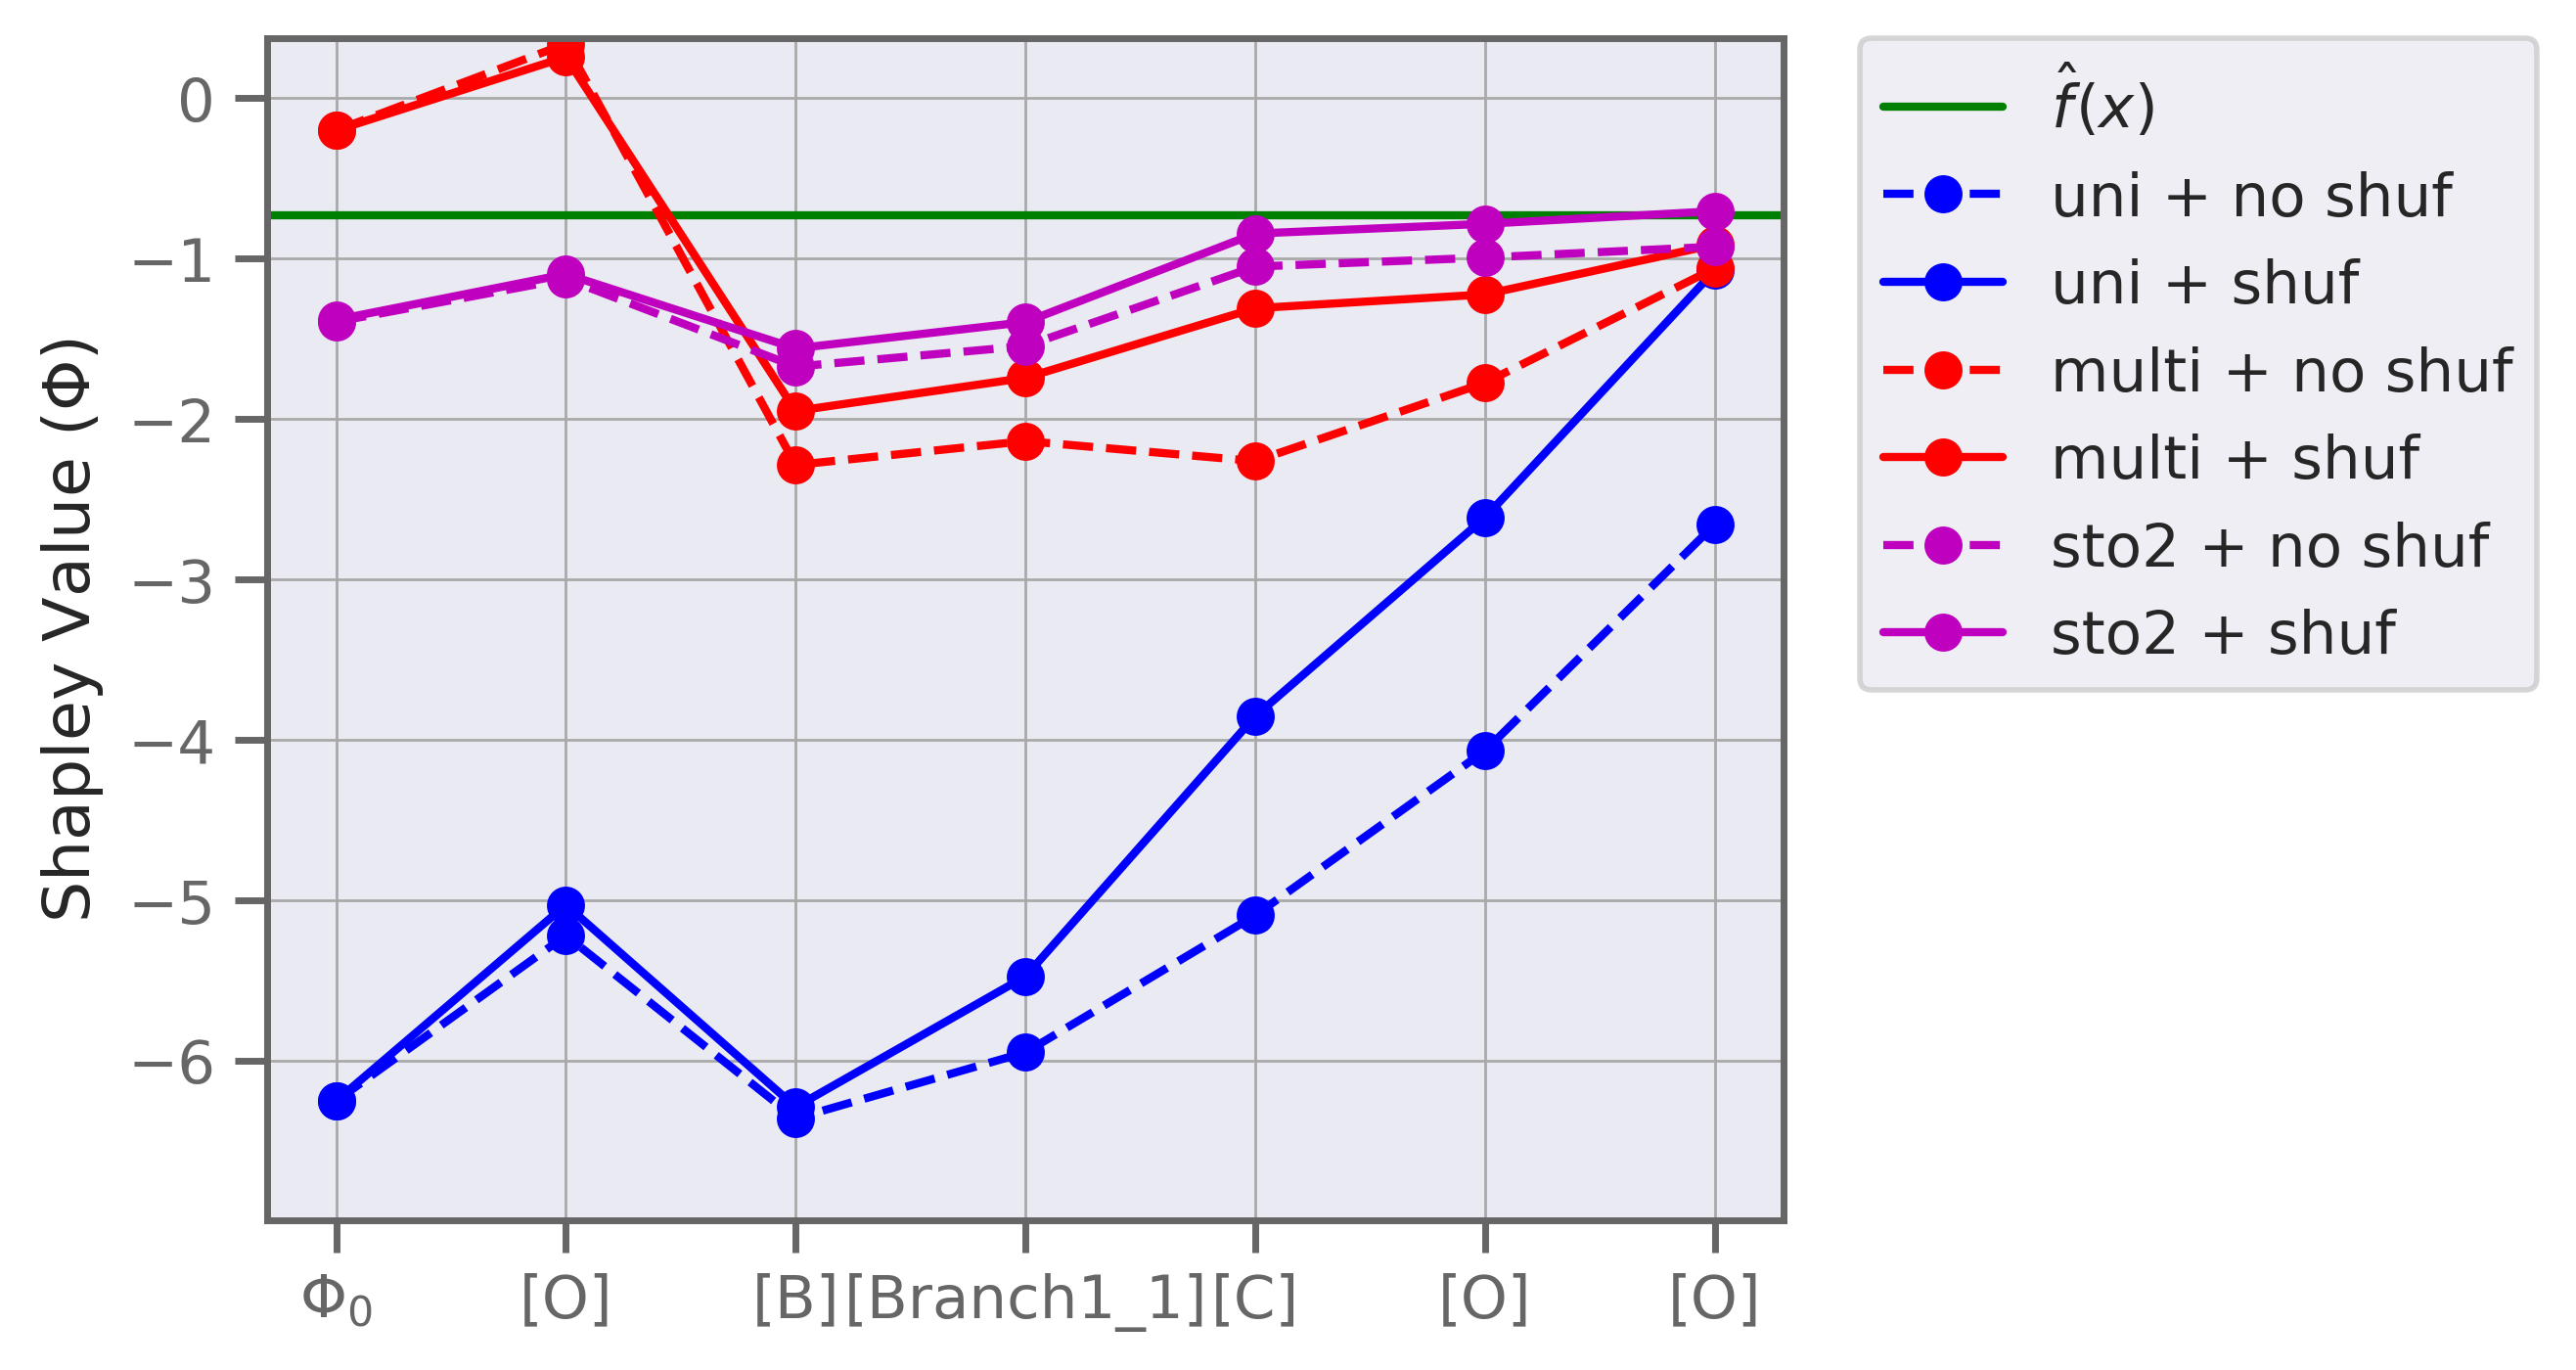

In [115]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

ls_shap_vals = []
ls_exp_val = []
ls_specs = []
ls_label = []

label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Uniform Sampling + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo--')
ls_label.append("uni + no shuf")
print(" Uniform Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo-')
ls_label.append("uni + shuf")
print(" Multinomial + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='freq')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('ro--')
ls_label.append("multi + no shuf")
print(" Multinomial + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='freq')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('ro-')
ls_label.append("multi + shuf")
num_mutations=2
print(f" Stoned {num_mutations} + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=False, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('mo--')
ls_label.append("sto2 + no shuf")
num_mutations=2
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('mo-')
ls_label.append("sto2 + shuf")
line_plot(instance, label, ls_shap_vals, ls_exp_val, ls_specs, ls_label, dpi=400)

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Multinomial + No Shuffle ngram=1
shapley values:  [0.45729559326171876, -2.72542236328125, 0.3434384765625, -0.21983474731445313, 0.42481903076171873, 0.732673095703125]
Sum SV:  -0.9870309143066406
Expectation Value:  -0.17834623  +-  1.1294804
Full Sum:  -1.165377145886421
f(s):  -0.99248695
%err:  -17.419895697406915

 Multinomial + Shuffle ngram=1
shapley values:  [0.5410665893554687, -2.342455078125, 0.3092232666015625, 0.13419917297363282, 0.019581476211547853, 0.4145118103027344]
Sum SV:  -0.9238727626800538
Expectation Value:  -0.17834623  +-  1.1294804
Full Sum:  -1.1022189942598344
f(s):  -0.99248695
%err:  -11.056270322898678

 Multinomial + No Shuffle ngram=2
shapley values:  [0.43726373291015624, -2.78778662109375, 0.3465107421875, -0.2219852294921875, 0.47478225708007815, 0.7775618896484375]
Sum SV:  -0.9736532287597657
Expectation Value:  -0.18916172  +-  1.0884767
Full S

<module 'matplotlib.pyplot' from '/home/navneeth/anaconda3/envs/exmol/lib/python3.8/site-packages/matplotlib/pyplot.py'>

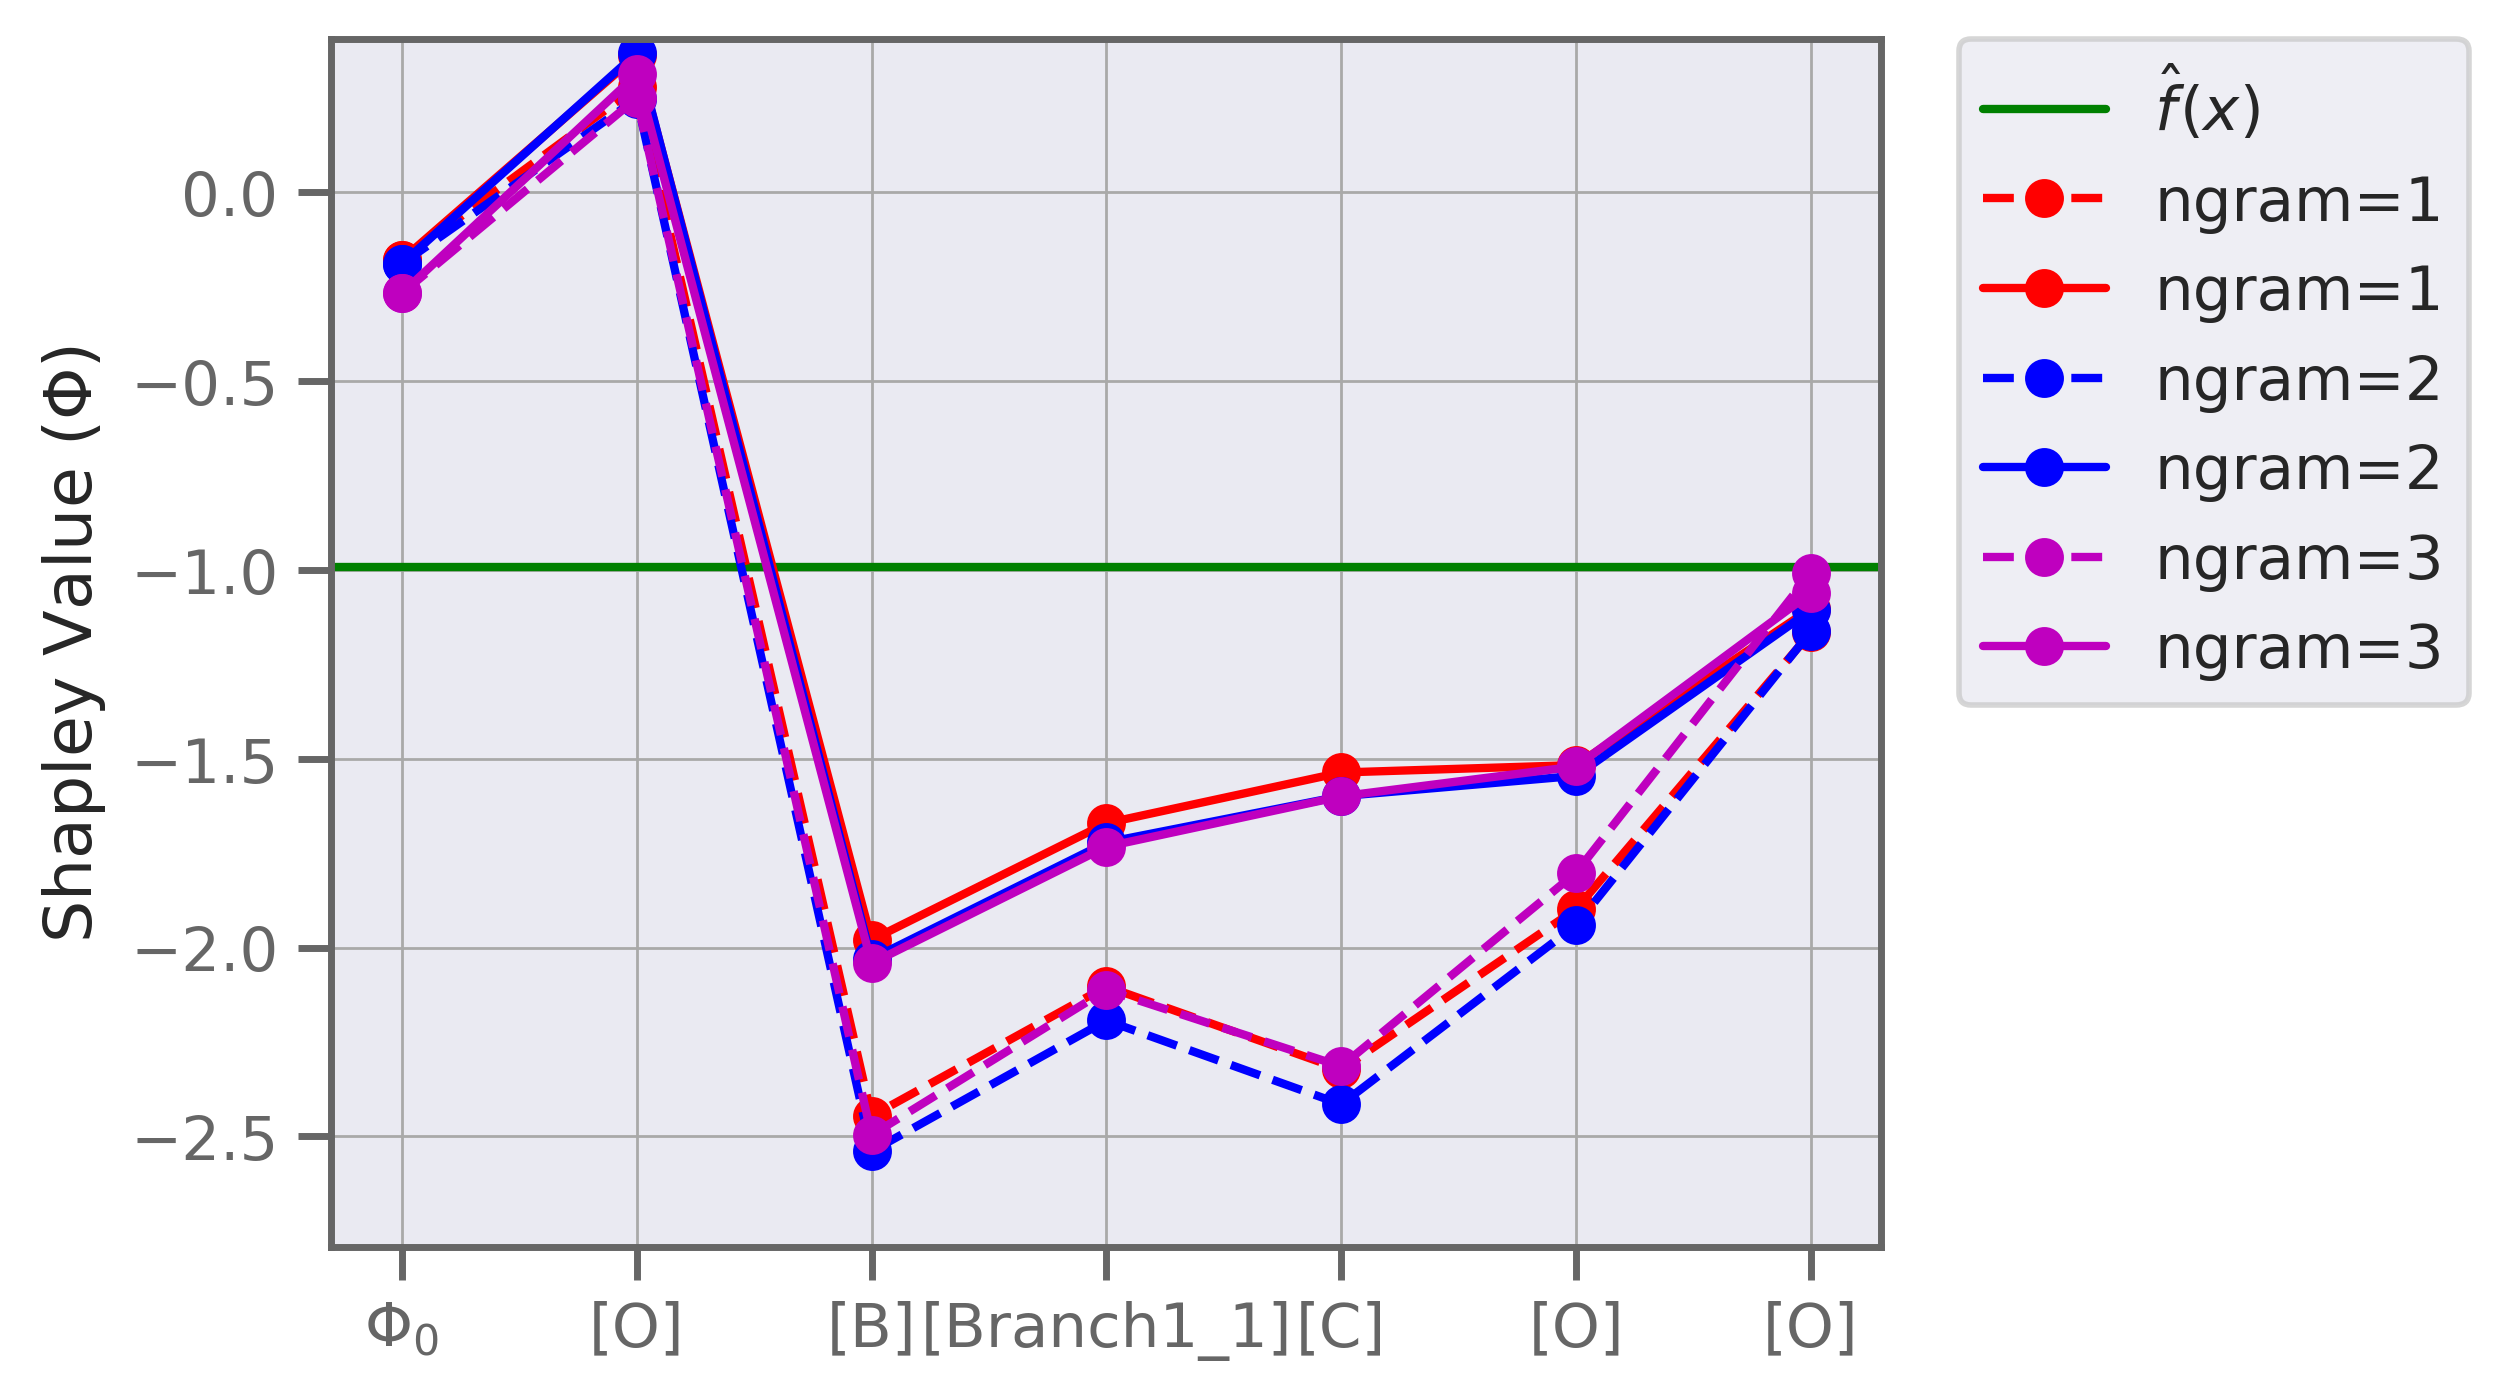

In [103]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

ls_shap_vals = []
ls_exp_val = []
ls_specs = []
ls_label = []

label =  np.reshape(model.predict([instance_ints]), (-1))[0]

ngram=1
print(f" Multinomial + No Shuffle ngram={ngram}")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='freq',ngram=ngram)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('ro--')
ls_label.append("ngram=1")
print(f" Multinomial + Shuffle ngram={ngram}")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='freq',ngram=ngram)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('ro-')
ls_label.append("ngram=1")
ngram=2
print(f" Multinomial + No Shuffle ngram={ngram}")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='freq',ngram=ngram)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo--')
ls_label.append("ngram=2")
print(f" Multinomial + Shuffle ngram={ngram}")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='freq',ngram=ngram)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo-')
ls_label.append("ngram=2")
ngram=3
print(f" Multinomial + No Shuffle ngram={ngram}")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='freq',ngram=ngram)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('mo--')
ls_label.append("ngram=3")
print(f" Multinomial + Shuffle ngram={ngram}")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=True, dist_type='freq',ngram=ngram)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('mo-')
ls_label.append("ngram=3")
line_plot(instance, label, ls_shap_vals, ls_exp_val, ls_specs, ls_label, doXLabel=True, dpi=400)

instance:  [O][B][Branch1_1][C][O][O]
instance ints:  [162, 58, 66, 78, 162, 162]
instance len:  6

 Stoned 1 + No Shuffle
shapley values:  [0.15907464599609375, -0.2911707458496094, 0.09530540466308594, 0.14154385375976564, -0.00011393427848815918, 0.04322987365722656]
Sum SV:  0.14786909794807435
Expectation Value:  -1.1403561  +-  1.0451455
Full Sum:  -0.9924869658946991
f(s):  -0.99248695
%err:  -1.2251392809837306e-06

 Stoned 1 + Shuffle
shapley values:  [0.19950189208984376, -0.2668063354492187, 0.0906436767578125, 0.16006576538085937, 0.0008530936241149902, 0.051375282287597655]
Sum SV:  0.23563337469100953
Expectation Value:  -1.2281203  +-  1.0736217
Full Sum:  -0.9924869523048401
f(s):  -0.99248695
%err:  1.4413403437294162e-07

 Stoned 2 + No Shuffle
shapley values:  [0.27220782470703125, -0.64079833984375, 0.13031787109375, 0.21877105712890624, 0.0005233559608459473, 0.07866814422607422]
Sum SV:  0.059689913272857664
Expectation Value:  -1.2126895  +-  1.3771995
Full Sum: 

<module 'matplotlib.pyplot' from '/home/navneeth/anaconda3/envs/exmol/lib/python3.8/site-packages/matplotlib/pyplot.py'>

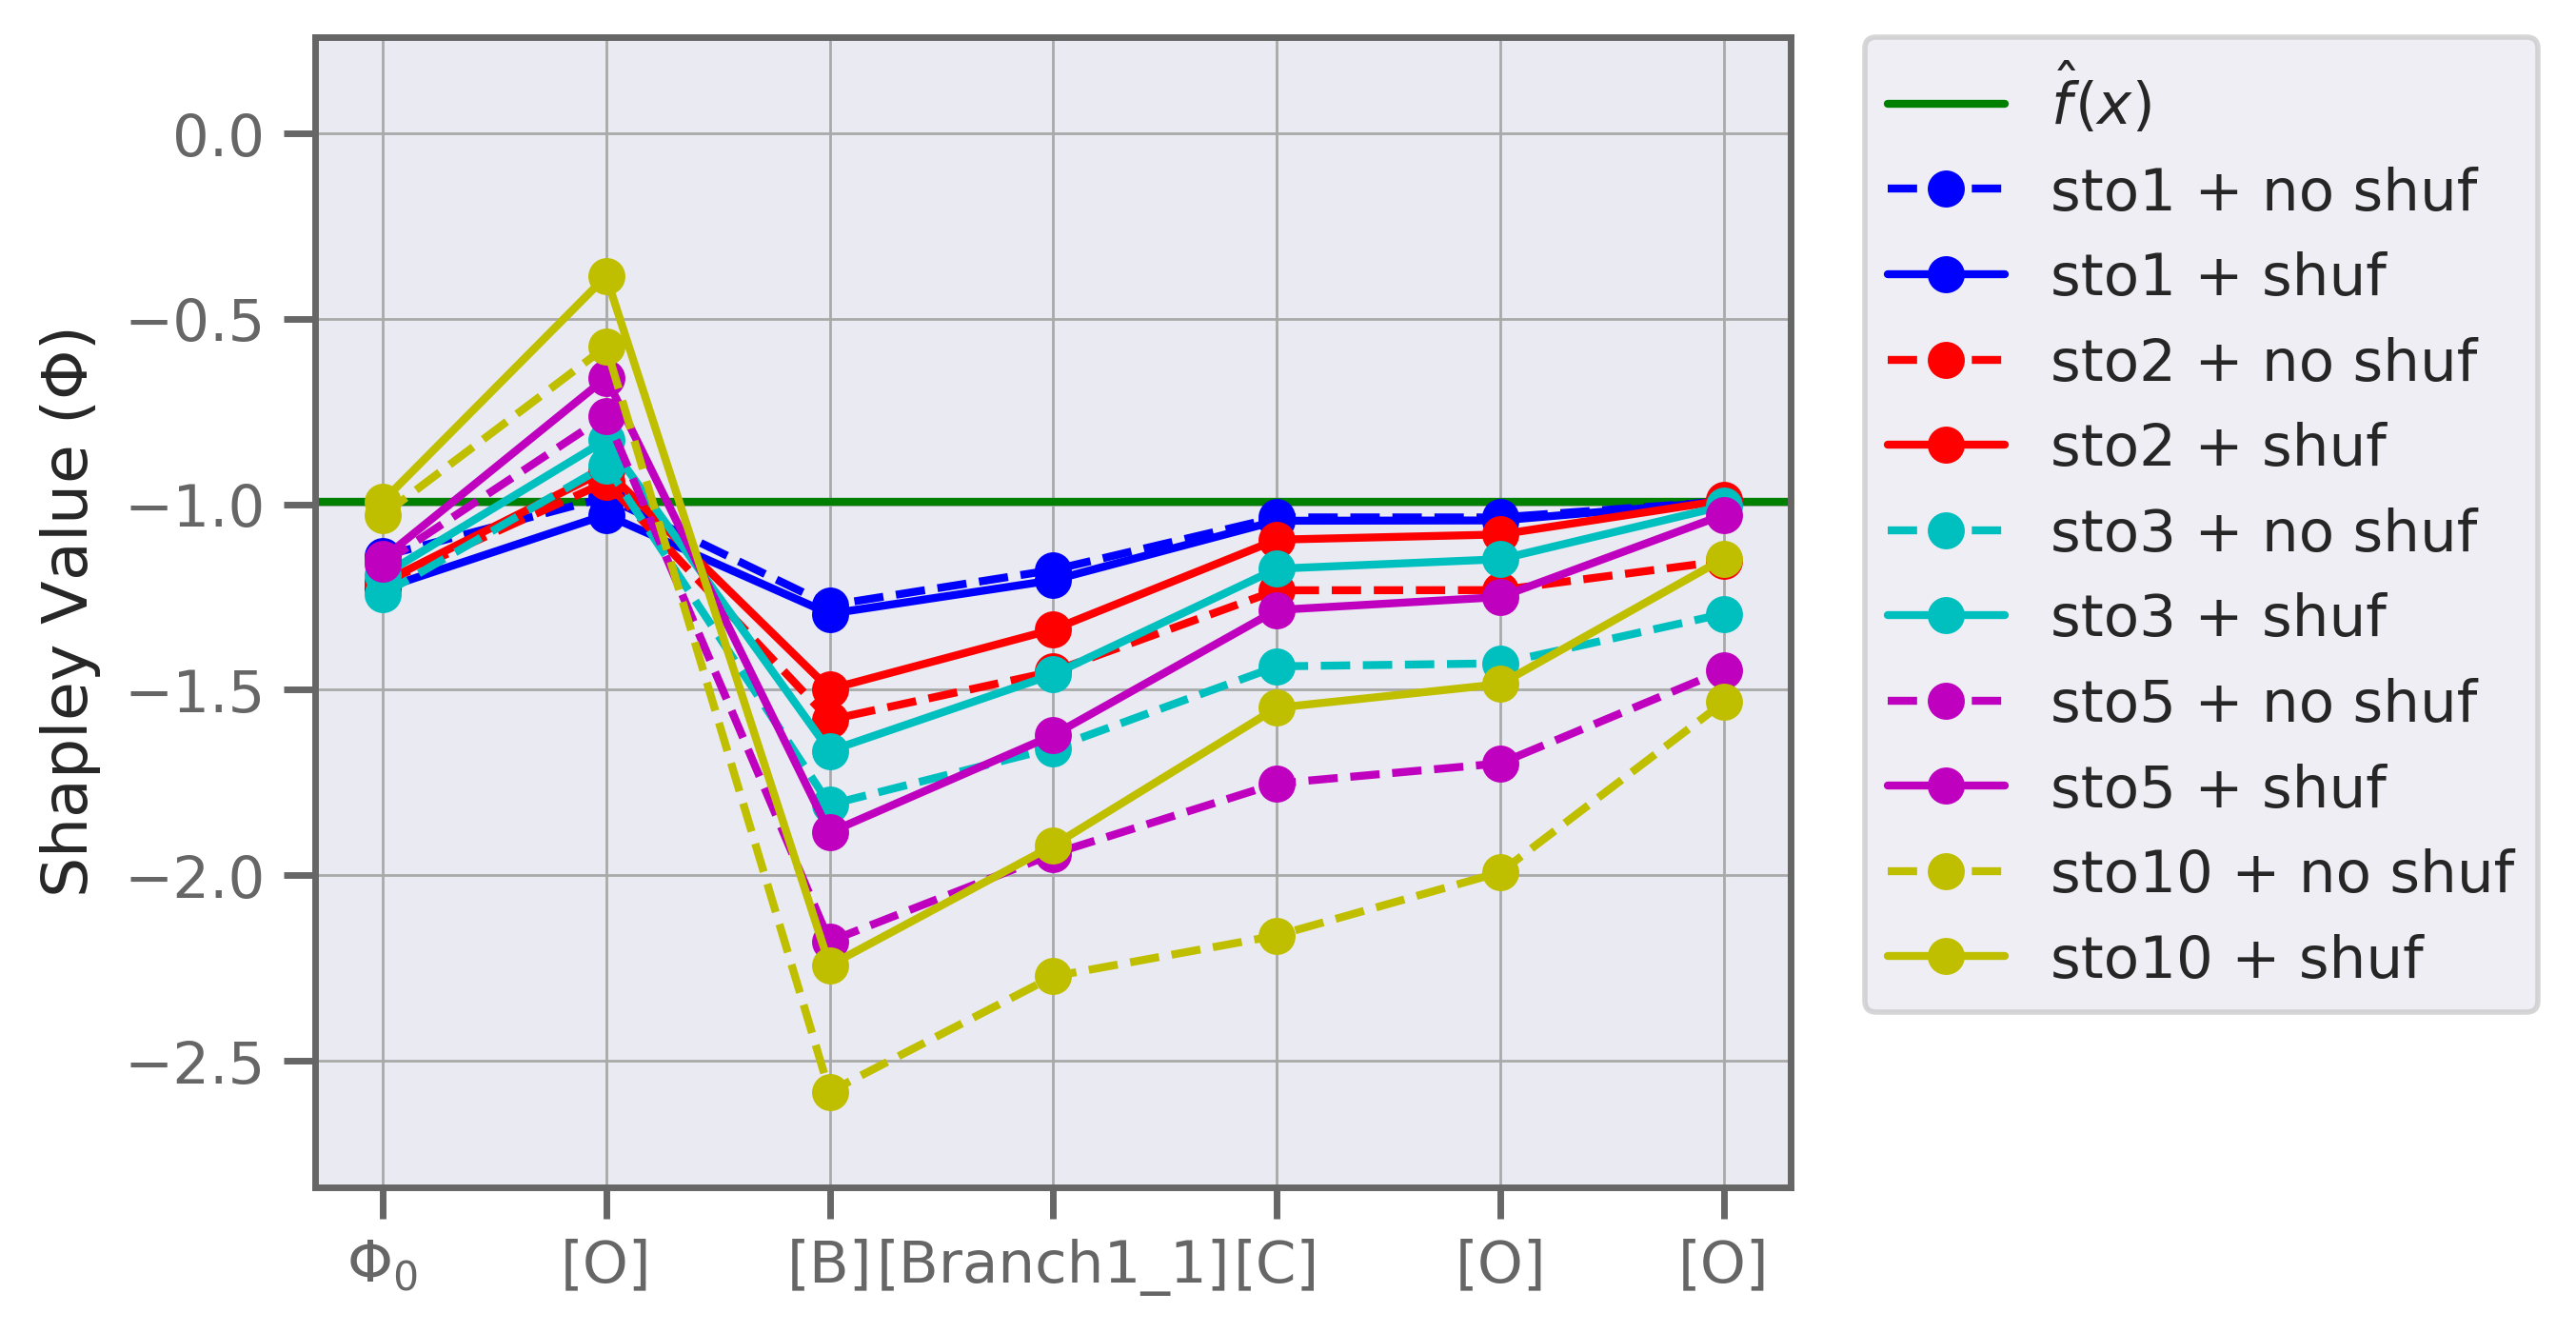

In [104]:
instance = selfies_list[2164]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

ls_shap_vals = []
ls_exp_val = []
ls_specs = []
ls_label = []

label =  np.reshape(model.predict([instance_ints]), (-1))[0]
num_mutations=1
print(f" Stoned {num_mutations} + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=False, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo--')
ls_label.append(f"sto{num_mutations} + no shuf")
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo-')
ls_label.append(f"sto{num_mutations} + shuf")
num_mutations=2
print(f" Stoned {num_mutations} + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=False, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('ro--')
ls_label.append(f"sto{num_mutations} + no shuf")
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('ro-')
ls_label.append(f"sto{num_mutations} + shuf")
num_mutations=3
print(f" Stoned {num_mutations} + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=False, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('co--')
ls_label.append(f"sto{num_mutations} + no shuf")
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('co-')
ls_label.append(f"sto{num_mutations} + shuf")
num_mutations=5
print(f" Stoned {num_mutations} + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=False, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('mo--')
ls_label.append(f"sto{num_mutations} + no shuf")
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('mo-')
ls_label.append(f"sto{num_mutations} + shuf")
num_mutations=10
print(f" Stoned {num_mutations} + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=False, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('yo--')
ls_label.append(f"sto{num_mutations} + no shuf")
print(f" Stoned {num_mutations} + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'stoned', steps, model, shuffle=True, num_mutations=num_mutations)
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('yo-')
ls_label.append(f"sto{num_mutations} + shuf")
line_plot(instance, label, ls_shap_vals, ls_exp_val, ls_specs, ls_label, dpi=400)

In [ ]:
instance = selfies_list[22]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()


label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples[:,:instance_len])
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
line_plot(instance, shap_val, sample_mean, label)

In [ ]:
instance = selfies_list[22]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

ls_shap_vals = []
ls_exp_val = []
ls_specs = []
ls_label = []

label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=False, train_data = train_samples[:,:instance_len])
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo--')
ls_label.append("train + no shuf")
label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print(" Train Sampling + Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'train', steps, model, shuffle=True, train_data = train_samples[:,:instance_len])
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)
print()
ls_shap_vals.append(shap_val)
ls_exp_val.append(sample_mean)
ls_specs.append('bo-')
ls_label.append("train + shuf")

## Molecule Plots

In [421]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

In [422]:
sf.decoder(selfies_list[0])

'CN(C)C(=O)NC1=CC=C(Cl)C(Cl)=C1'

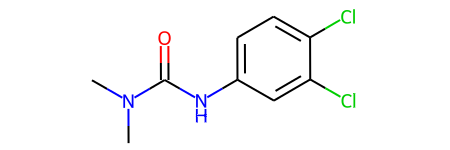

In [423]:
smi = sf.decoder(selfies_list[0])#'c1cc(F)ccc1Cl'
mol = Chem.MolFromSmiles(smi)
mol

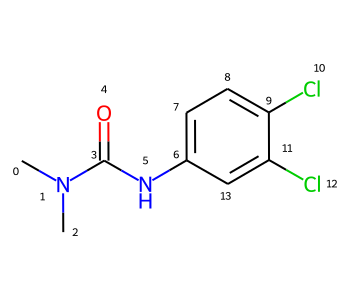

In [424]:
d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(mol)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

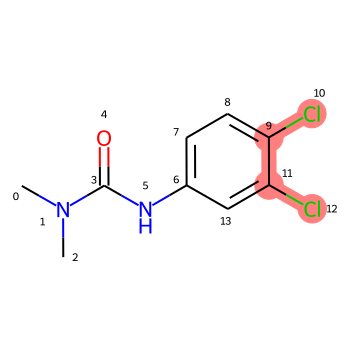

In [425]:
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('ClccCl')#Chem.MolFromSmarts('ClccccF')
hit_ats = list(mol.GetSubstructMatch(patt))
hit_bonds = []
for bond in patt.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
    
d = rdMolDraw2D.MolDraw2DSVG(350, 350) # or MolDraw2DCairo to get PNGs
d.drawOptions().addAtomIndices=True
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats, highlightBonds=hit_bonds)
d.FinishDrawing()
SVG(d.GetDrawingText())

[10, 9, 11, 12]


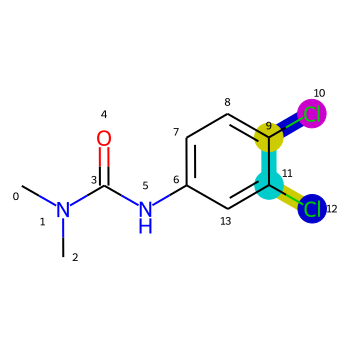

In [269]:
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('ClccCl')
hit_ats = list(mol.GetSubstructMatch(patt))
print(hit_ats)
hit_bonds = []
for bond in patt.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())


colours = [(0.8,0.0,0.8),(0.8,0.8,0),(0,0.8,0.8),(0,0,0.8)]

atom_cols = {}
for i, at in enumerate(hit_ats):
     atom_cols[at] = colours[i%4]
bond_cols = {}
for i, bd in enumerate(hit_bonds):
     bond_cols[bd] = colours[3 - i%4]

d = rdMolDraw2D.MolDraw2DSVG(350, 350) # or MolDraw2DCairo to get PNGs
d.drawOptions().addAtomIndices=True
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats, highlightBonds=hit_bonds, highlightAtomColors=atom_cols, highlightBondColors=bond_cols)
d.FinishDrawing()
SVG(d.GetDrawingText())

In [205]:
instance = selfies_list[0]
instance_ints = selfies2ints(instance)
instance_len = len(instance_ints)

steps = 2000

print("instance: ",instance)
print("instance ints: ",instance_ints)
print("instance len: ",instance_len)
print()

print(" Uniform Sampling + No Shuffle")
shap_val, sample_mean, sample_std = get_shap_vals(instance, 'random', steps, model, shuffle=False, dist_type='uni')
print("shapley values: ", shap_val)
print("Sum SV: ", np.sum(shap_val))
print("Expectation Value: ", sample_mean," +- ",sample_std)
full_sum = np.sum(shap_val) + sample_mean
print("Full Sum: ", full_sum)
label =  np.reshape(model.predict([instance_ints]), (-1))[0]
print("f(s): ", label)
print("%err: ", (label-full_sum)*100/label)

instance:  [C][N][Branch1_1][C][C][C][Branch1_2][C][=O][N][C][=C][C][=C][Branch1_1][C][Cl][C][Branch1_1][C][Cl][=C][Ring1][Branch2_1]
instance ints:  [0, 7, 2, 0, 0, 0, 4, 0, 6, 7, 0, 1, 0, 1, 2, 0, 8, 0, 2, 0, 8, 1, 3, 11]
instance len:  24

 Uniform Sampling + No Shuffle
shapley values:  [0.024111820220947267, 0.06485074615478516, -0.056803192138671875, 0.025487850189208985, 0.020592796325683595, 0.02125828170776367, -0.03647779083251953, 0.019395065307617188, -0.07406817626953124, 0.13997453308105468, 0.026978675842285155, -0.144838134765625, 0.01956316947937012, -0.16908889770507812, -0.18551535034179686, 0.020998275756835938, -0.3584634399414062, 0.02681977081298828, -0.26397885131835935, 0.01896467590332031, -0.4103517456054688, -0.2665707702636719, -0.3883993225097656, 0.369991943359375]
Sum SV:  -1.5555680675506594
Expectation Value:  -1.7661076  +-  1.2188979
Full Sum:  -3.321675626754761
f(s):  -3.6409247
%err:  8.768351240198422


In [207]:
[2*(s-min(shap_val))/(max(shap_val)-min(shap_val)) - 1 for s in shap_val]

[0.11351849696573768,
 0.21793127433535964,
 -0.09386451517076333,
 0.11704522496449177,
 0.10449933285887658,
 0.10620495409088249,
 -0.041771055343812535,
 0.10142958029983373,
 -0.138114207646042,
 0.4104715306060913,
 0.12086617123254917,
 -0.31949571811862054,
 0.10186042679511575,
 -0.3816497748051626,
 -0.4237503334923459,
 0.10553856579402154,
 -0.8670116606366244,
 0.120458901893298,
 -0.6248501875339603,
 0.10032650376988106,
 -1.0,
 -0.6314932064548944,
 -0.9437365268505628,
 1.0]

In [211]:
[s*100/label for s in shap_val]

[-0.6622444093091907,
 -1.7811614256822264,
 1.560130926659396,
 -0.7000378295144207,
 -0.5655924817687213,
 -0.5838704039546477,
 1.0018825962296867,
 -0.5326961403352531,
 2.034323215449791,
 -3.844477568643346,
 -0.7409841763666051,
 3.9780590649882503,
 -0.5373132139076671,
 4.644119612511046,
 5.09528117243337,
 -0.5767291974504858,
 9.845395613753913,
 -0.7366197623033505,
 7.250324399381971,
 -0.5208752585349691,
 11.270536479091778,
 7.32151287935515,
 10.667601099983006,
 -10.162032303406196]

In [245]:
[s*100/np.sum(shap_val) for s in shap_val]

[-1.5500331180565348,
 -4.168943005939739,
 3.6516044089354516,
 -1.6384914759365832,
 -1.3238119729539228,
 -1.3665928319829928,
 2.3449819775457414,
 -1.246815598249966,
 4.761487318658854,
 -8.998290463846654,
 -1.7343294970540757,
 9.310948057302426,
 -1.2576222080833512,
 10.869913135419354,
 11.925890882673013,
 -1.3498782981511734,
 23.043892930113287,
 -1.724114255907664,
 16.969932516936453,
 -1.2191479305165602,
 26.379542892751306,
 17.136554537494746,
 24.968327044751245,
 -23.785005045902672]

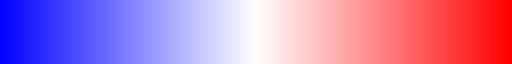

In [225]:
plt.get_cmap('bwr')

In [224]:
norm_shap_val = [s*100/np.sum(shap_val) for s in shap_val]

In [218]:
mycmap = plt.get_cmap('bwr')

In [244]:
mycmap()

(1.0, 0.0, 0.0, 1.0)

In [249]:
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=min(norm_shap_val), vmax=max(norm_shap_val))
cmap = cm.bwr

m = cm.ScalarMappable(norm=norm, cmap=cmap)
print(m.to_rgba(norm_shap_val))

[[0.88627451 0.88627451 1.         1.        ]
 [0.78431373 0.78431373 1.         1.        ]
 [1.         0.90196078 0.90196078 1.        ]
 [0.88627451 0.88627451 1.         1.        ]
 [0.89411765 0.89411765 1.         1.        ]
 [0.89411765 0.89411765 1.         1.        ]
 [1.         0.95686275 0.95686275 1.        ]
 [0.90196078 0.90196078 1.         1.        ]
 [1.         0.8627451  0.8627451  1.        ]
 [0.58823529 0.58823529 1.         1.        ]
 [0.87843137 0.87843137 1.         1.        ]
 [1.         0.68235294 0.68235294 1.        ]
 [0.89411765 0.89411765 1.         1.        ]
 [1.         0.61960784 0.61960784 1.        ]
 [1.         0.57254902 0.57254902 1.        ]
 [0.89411765 0.89411765 1.         1.        ]
 [1.         0.13333333 0.13333333 1.        ]
 [0.87843137 0.87843137 1.         1.        ]
 [1.         0.37647059 0.37647059 1.        ]
 [0.90196078 0.90196078 1.         1.        ]
 [1.         0.         0.         1.        ]
 [1.         

[C][N][Branch1_1][C][C][C][Branch1_2][C][=O][N][C][=C][C][=C][Branch1_1][C][Cl][C][Branch1_1][C][Cl][=C][Ring1][Branch2_1]
CN(C)C(=O)NC1=CC=C(Cl)C(Cl)=C1


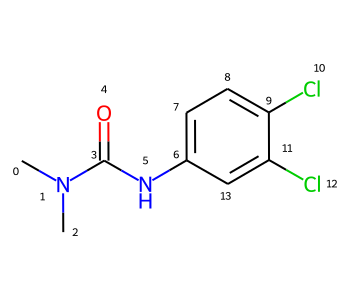

In [279]:
instance = selfies_list[0]
print(instance)
smi = sf.decoder(instance)#'c1cc(F)ccc1Cl'
print(smi)
mol = Chem.MolFromSmiles(smi)

d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(mol)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

In [268]:
Chem.MolToSmarts(mol)

'[#6]-[#7](-[#6])-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]:[#6](-[#17]):[#6](-[#17]):[#6]:1'

[C][N][Branch1_1][C][C][C][Branch1_2][C][=O][N][C][=C][C][=C][Branch1_1][C][Cl][C][Branch1_1][C][Cl][=C][Ring1][Branch2_1]
[C][N][Branch1_1][C][C][Branch1_2][C][=O][N][C][=C][C][=C][Branch1_1][C][Cl][C][Branch1_1][C][Cl][=C][Ring1][Branch2_1]
CN(C)C=O


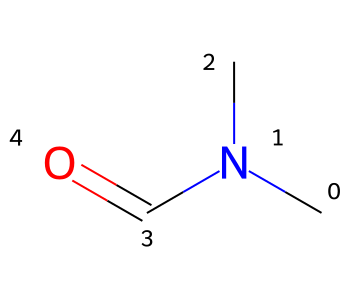

In [278]:
instance = selfies_list[0]
print(instance)
instance_ls = list(sf.split_selfies(instance))
#print(instance_ls)
instance_mod = ''.join(instance_ls[:3]+instance_ls[4:])
print(instance_mod)

smi = sf.decoder(instance_mod)#'c1cc(F)ccc1Cl'
print(smi)
mol = Chem.MolFromSmiles(smi)

d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(mol)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

In [280]:
instance = selfies_list[0]
print(instance)
print()
print(sf.decoder(instance))
print()

patt_ls = []
for i,tok in enumerate(list(sf.split_selfies(instance))):
    smi_tok = sf.decoder(tok)
    print(i," ",tok," ",smi_tok," ",shap_val[i])
    patt = Chem.MolFromSmarts(smi_tok)
    
    #Draw.MolsToGridImage([patt])
    #hit_ats = list(mol.GetSubstructMatch(patt))
    #print(hit_ats)

[C][N][Branch1_1][C][C][C][Branch1_2][C][=O][N][C][=C][C][=C][Branch1_1][C][Cl][C][Branch1_1][C][Cl][=C][Ring1][Branch2_1]

CN(C)C(=O)NC1=CC=C(Cl)C(Cl)=C1

0   [C]   C   0.024111820220947267
1   [N]   N   0.06485074615478516
2   [Branch1_1]      -0.056803192138671875
3   [C]   C   0.025487850189208985
4   [C]   C   0.020592796325683595
5   [C]   C   0.02125828170776367
6   [Branch1_2]      -0.03647779083251953
7   [C]   C   0.019395065307617188
8   [=O]   O   -0.07406817626953124
9   [N]   N   0.13997453308105468
10   [C]   C   0.026978675842285155
11   [=C]   C   -0.144838134765625
12   [C]   C   0.01956316947937012
13   [=C]   C   -0.16908889770507812
14   [Branch1_1]      -0.18551535034179686
15   [C]   C   0.020998275756835938
16   [Cl]   Cl   -0.3584634399414062
17   [C]   C   0.02681977081298828
18   [Branch1_1]      -0.26397885131835935
19   [C]   C   0.01896467590332031
20   [Cl]   Cl   -0.4103517456054688
21   [=C]   C   -0.2665707702636719
22   [Ring1]      -0.388399322509765